In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [3]:
df = pd.read_csv('../../02_Daten/Validierung/4.csv', sep=',')

C:\Users\pauls\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Richtige Zeit für alle Einträge
df['date'] = [datetime.utcfromtimestamp(x/1000) for x in df['timestamp']]

In [5]:
df.dropna(axis=1, inplace=True)

In [6]:
df_col = df[['iomaster','druck','temperatur','leck', 'liveleck', 'status','date']]

In [7]:
time_series = []
# wenn es eine Änderung des Status gibt, wird der Index an dieser Stelle abgespeichert
ind_changes = df_col[df_col["status"].shift() != df_col["status"]].index.tolist() 
# dann für jede Änderung abschneiden und DF_col der Liste hinzufügen
for index, elem in enumerate(ind_changes):
    # nur ts erstellen, wenn der erste Status 3 ist, da dann Bauteil in Maschine
    if df_col.status[elem] == 3:
        if index + 1 < len(ind_changes):
            # mit dem zweiten +1 wird der Wert des Index erhöht, damit der letzte Eintrag den resultierenden Status der Prüfung enthält
            next_el = ind_changes[index+1]+1  
            ts = df_col[elem:next_el].reset_index(drop=True)
        else:
            ts = df_col[elem:].reset_index(drop=True)
            
        time_series.append(ts)

In [8]:
status_4 = []
status_1 = []
for t in time_series:
    if t.status[len(t)-1] == 4:
        #status_4.append(t[:-1])
        status_4.append(t[:60]) # Daten müssen für to_time_series alle die gleiche Länge haben (60 ist die kleinste Länge mancher TS)
    else:
        #status_1.append(t[:-1])
        status_1.append(t[:60])

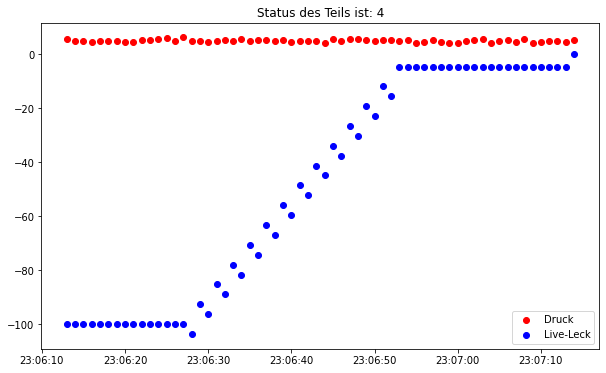

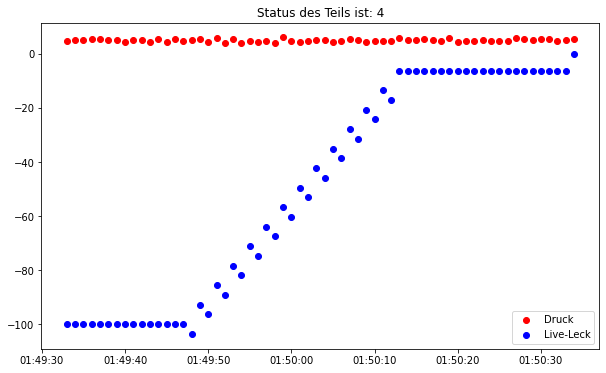

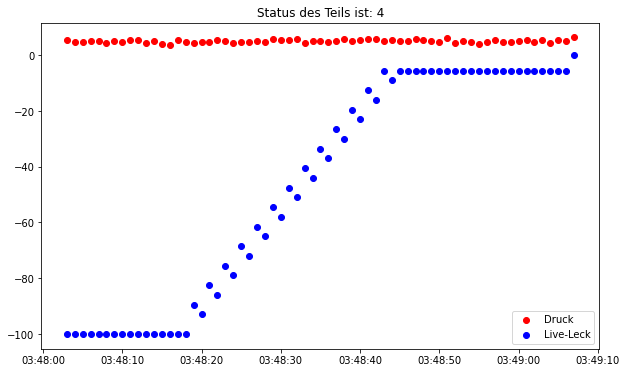

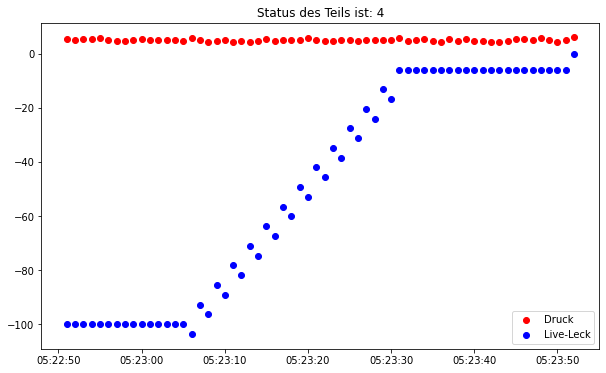

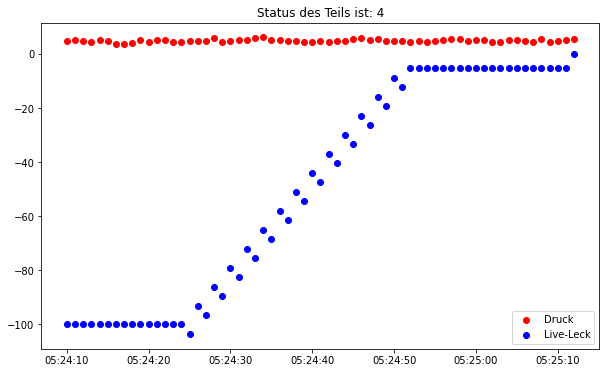

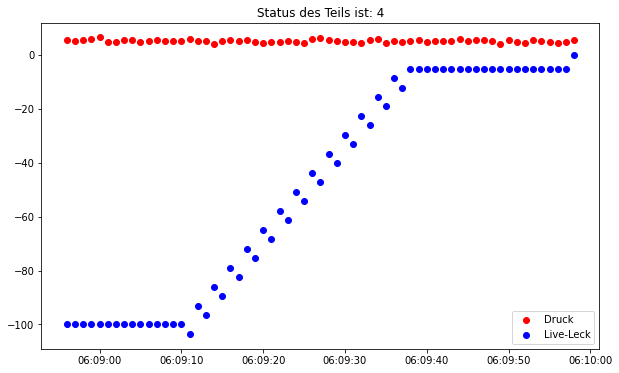

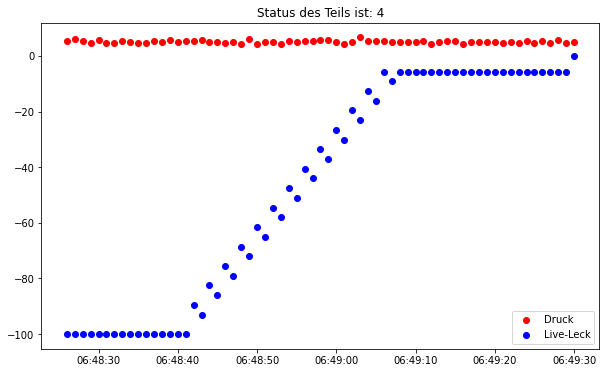

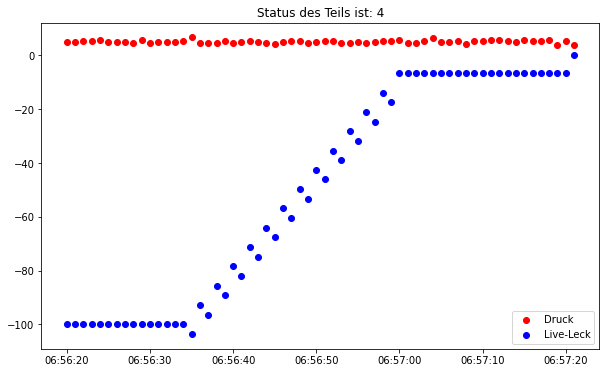

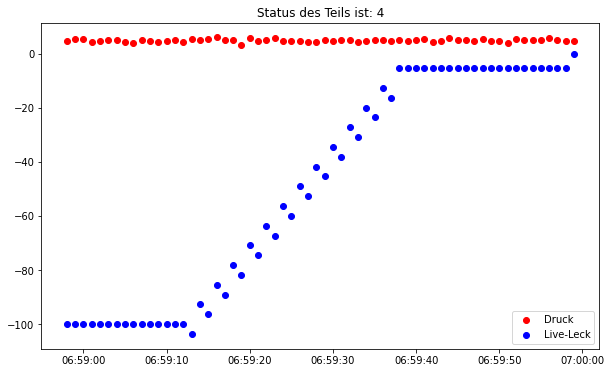

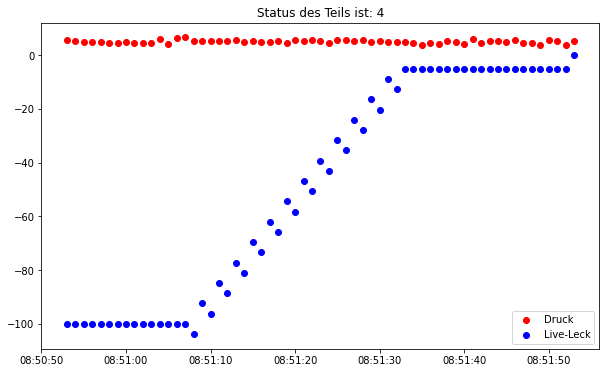

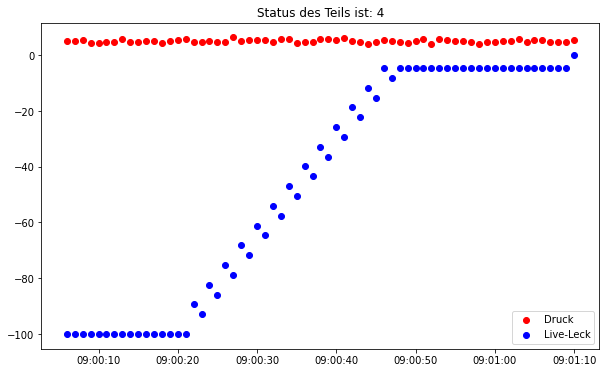

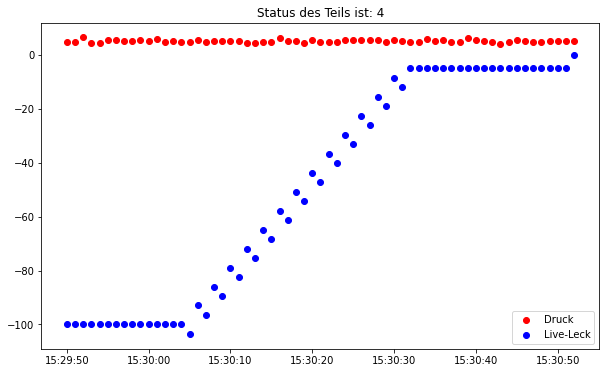

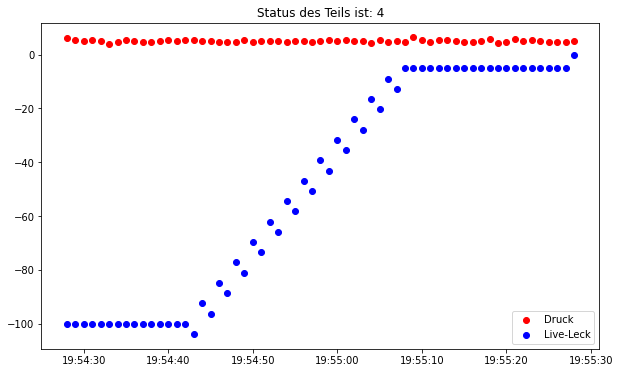

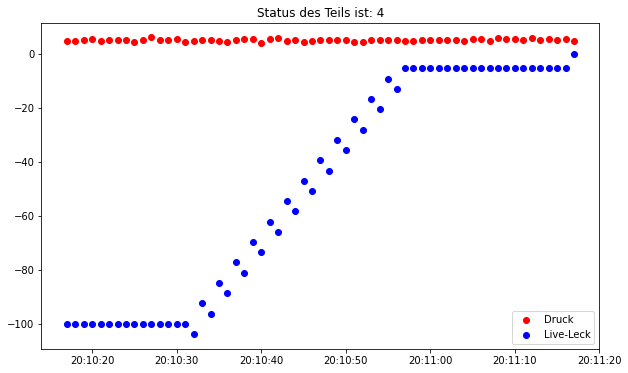

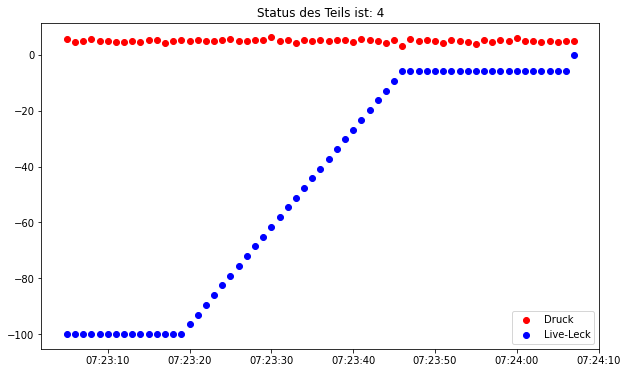

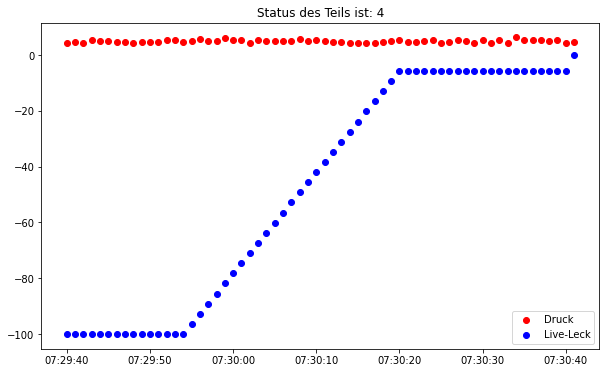

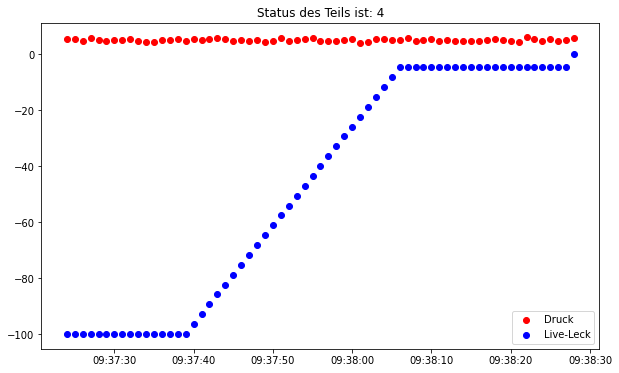

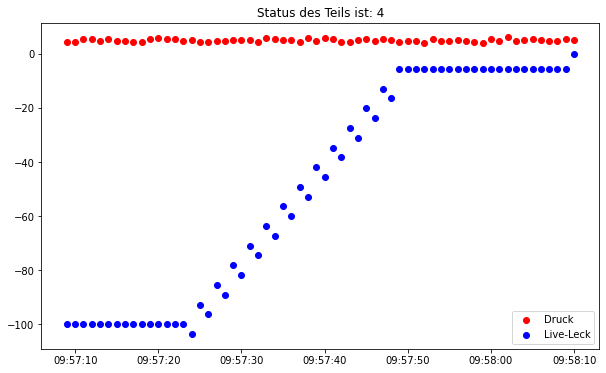

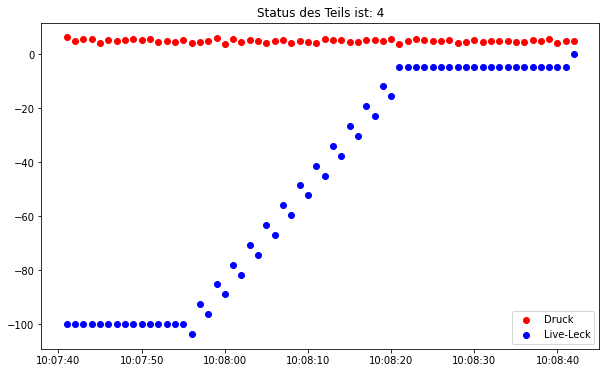

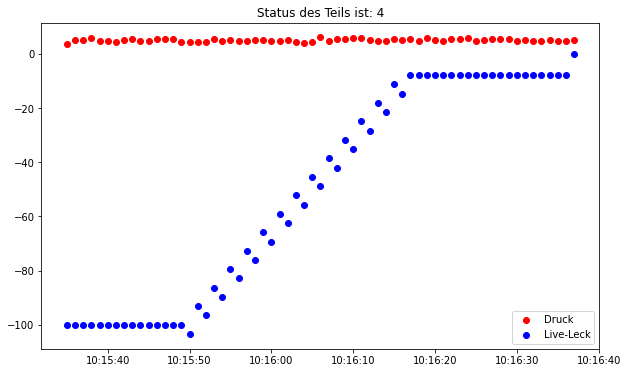

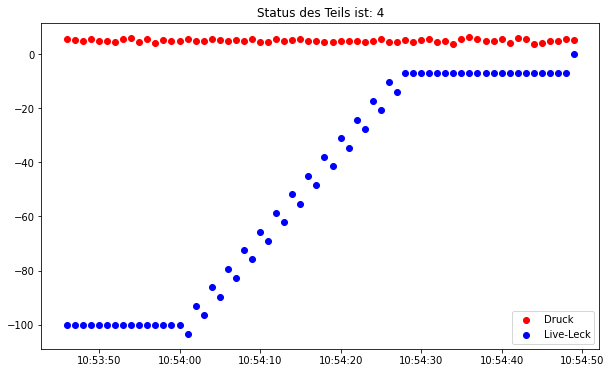

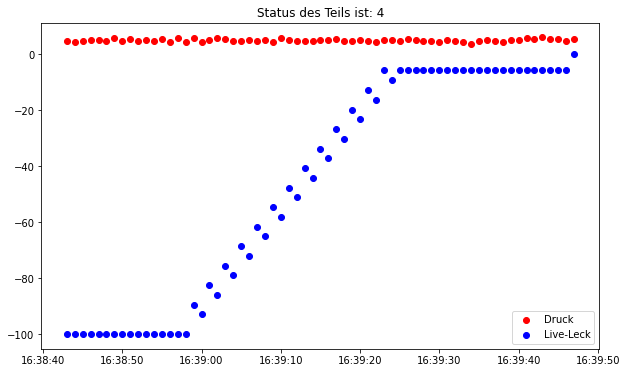

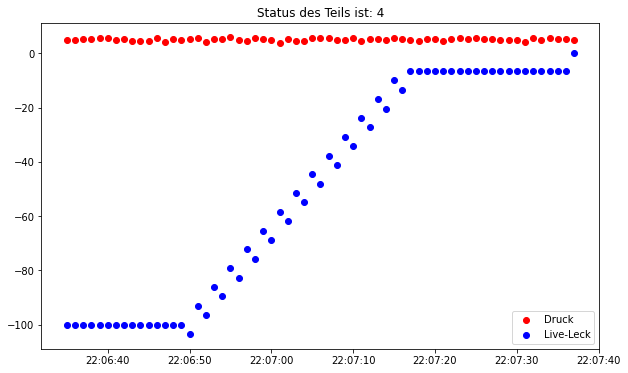

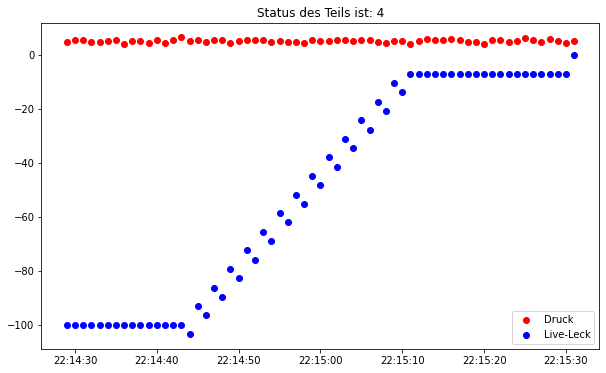

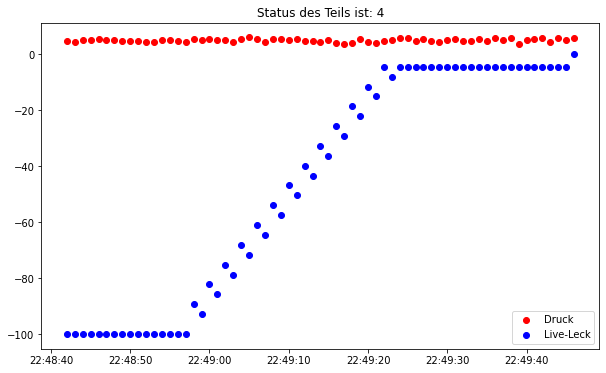

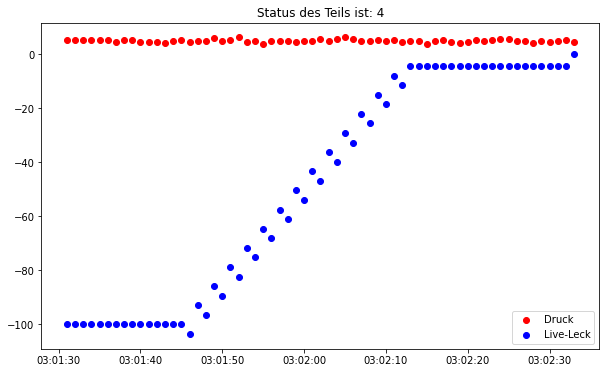

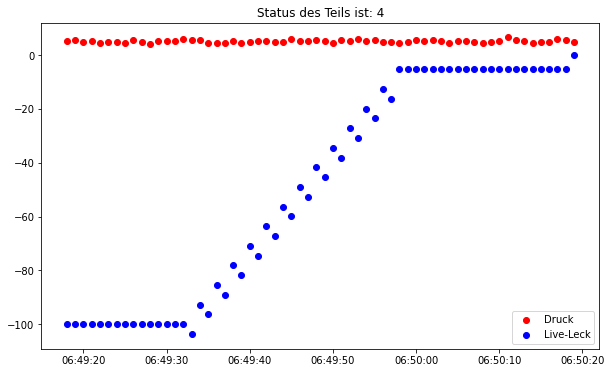

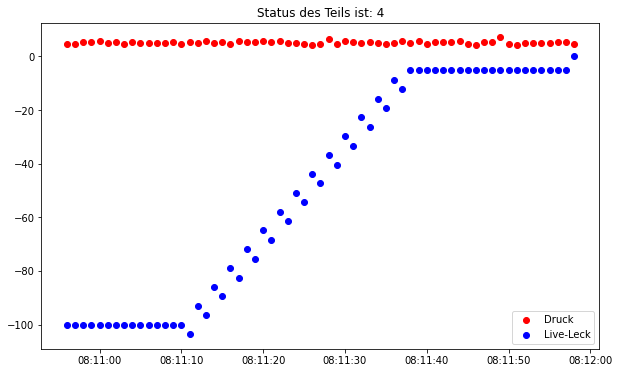

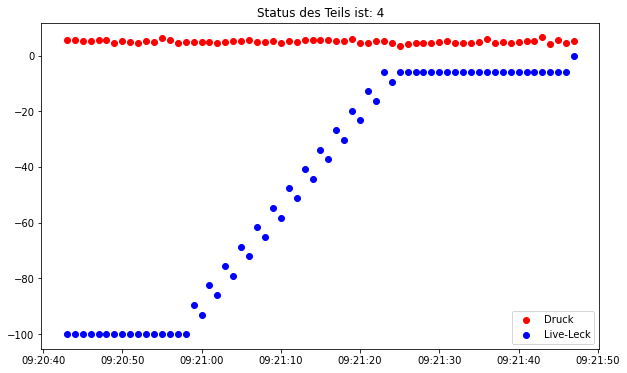

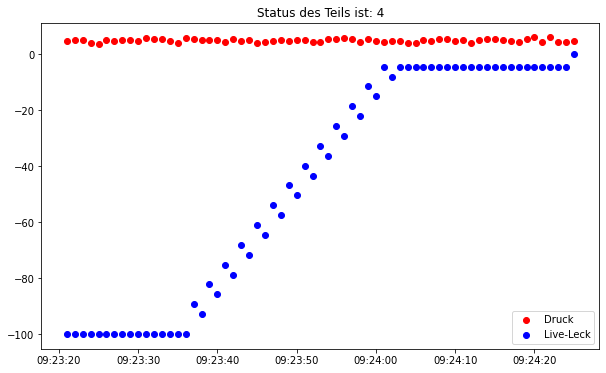

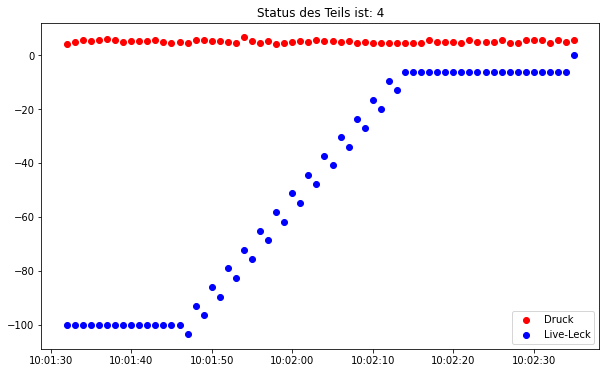

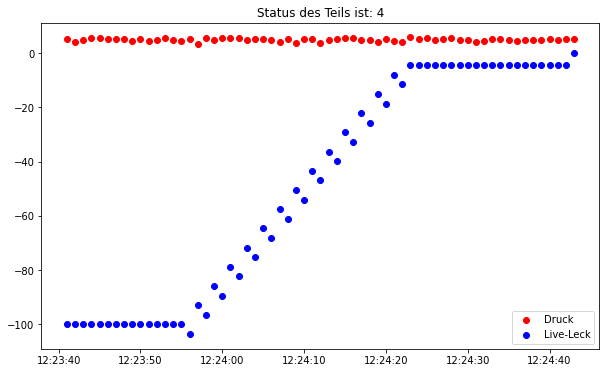

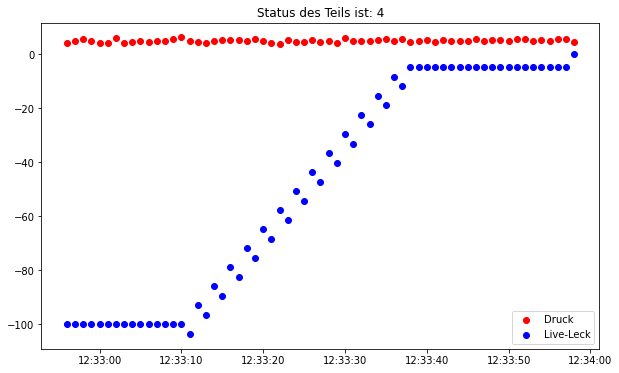

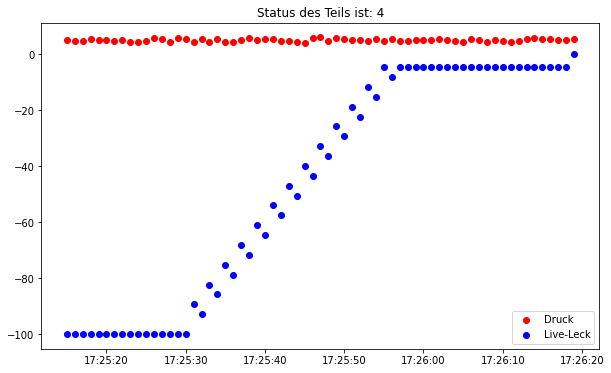

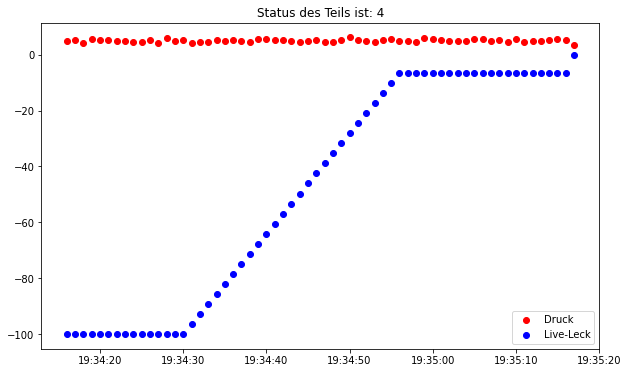

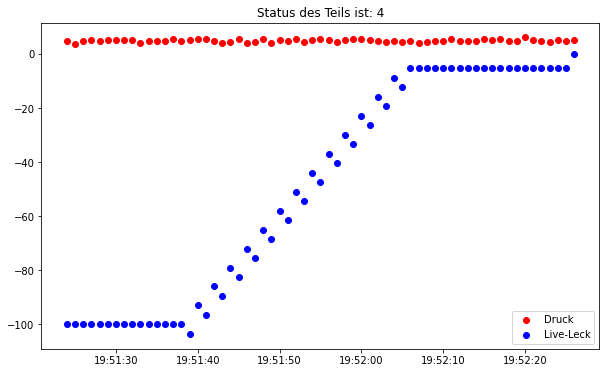

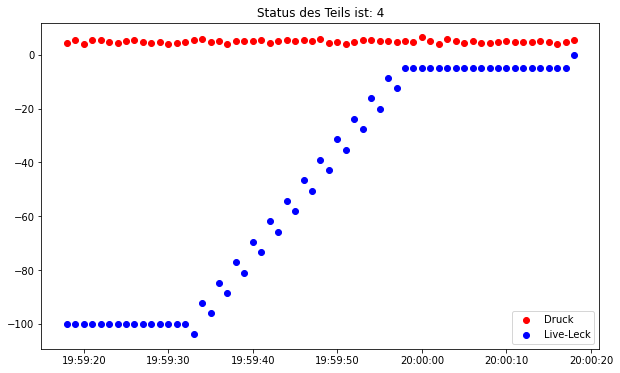

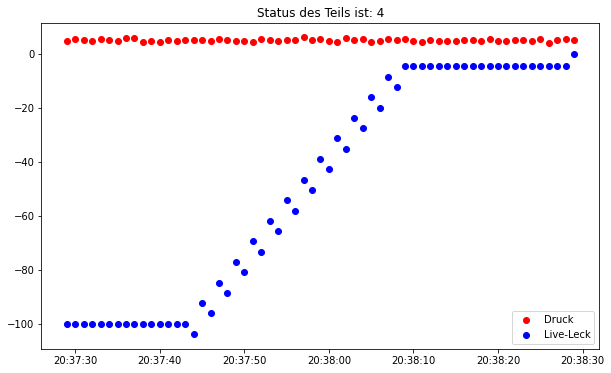

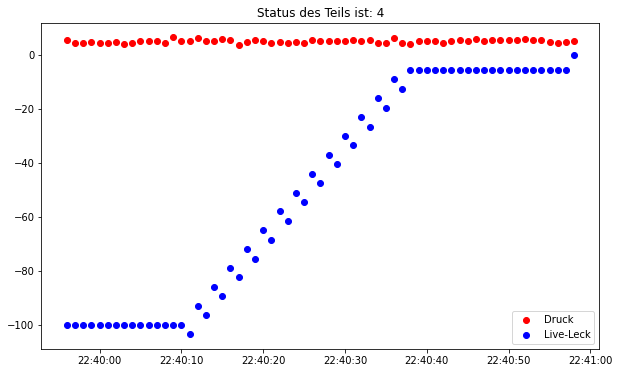

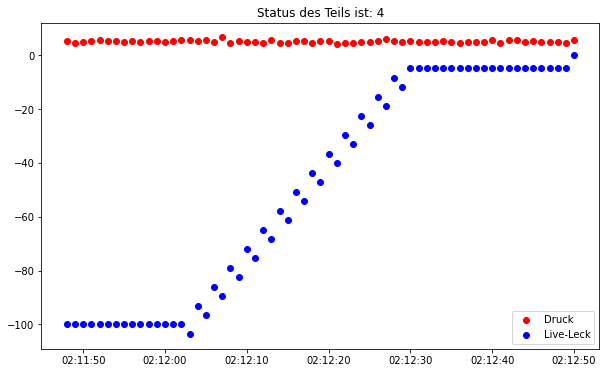

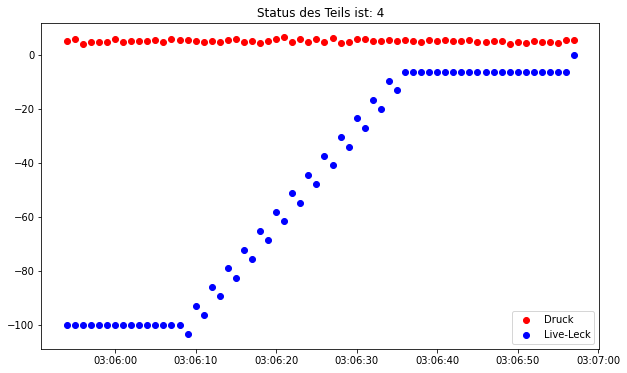

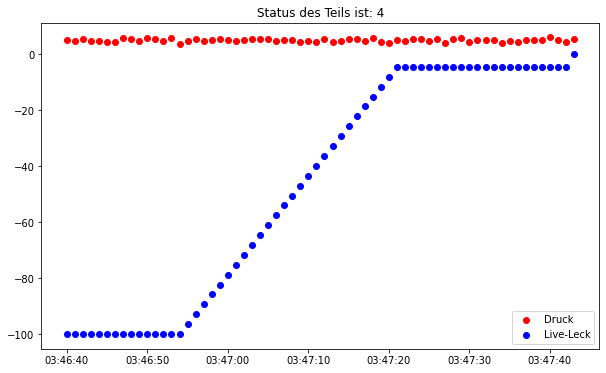

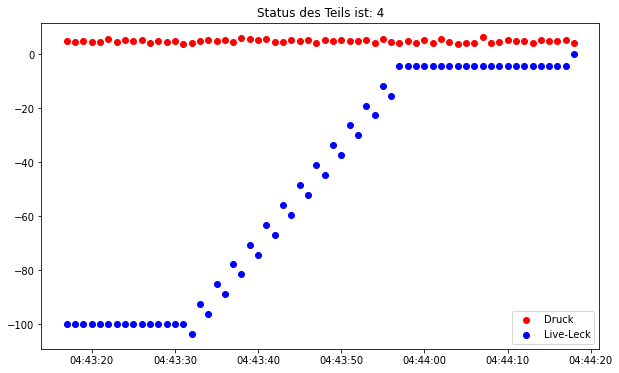

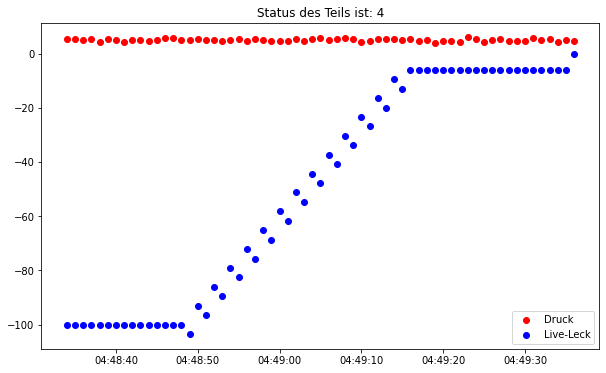

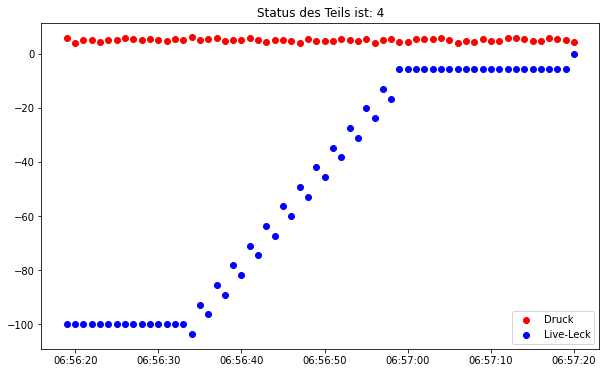

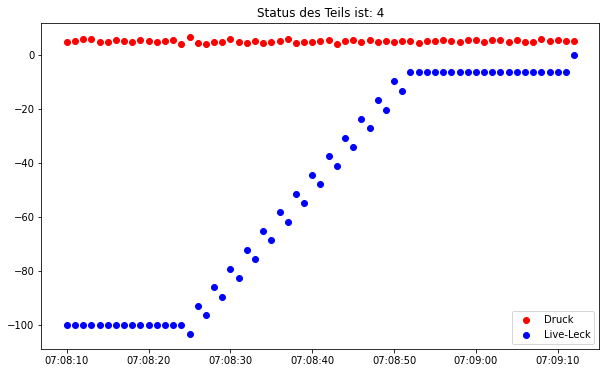

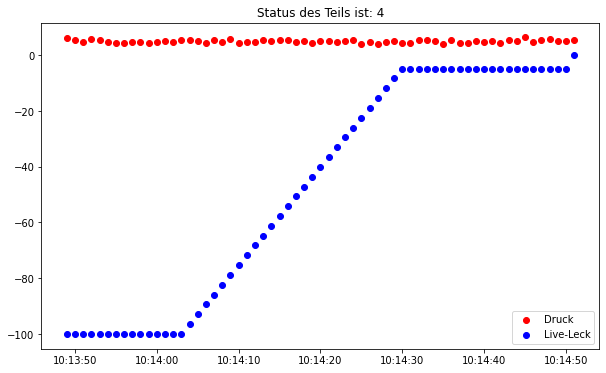

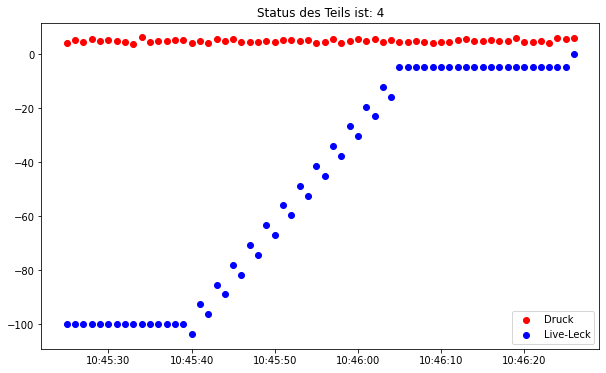

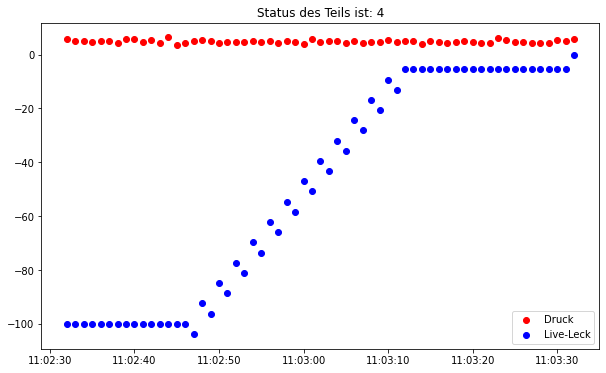

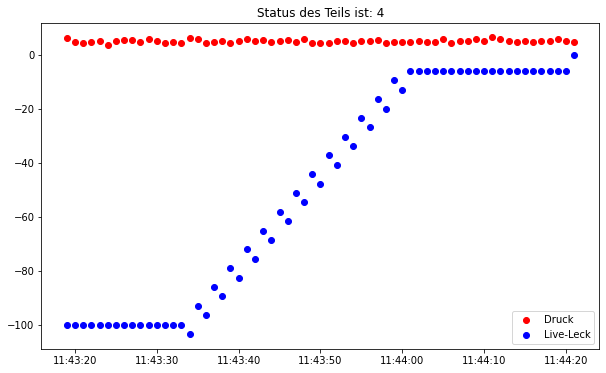

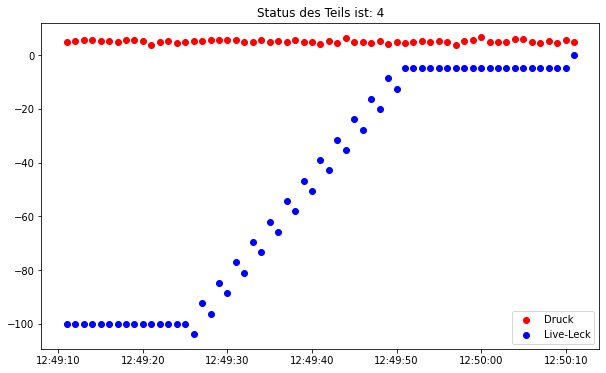

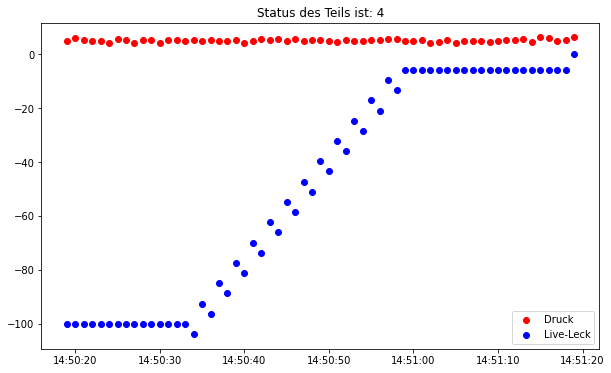

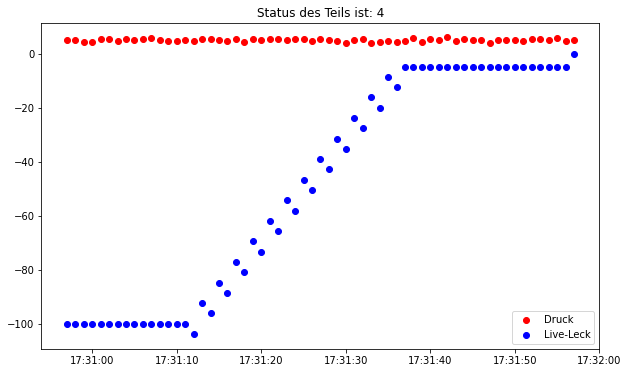

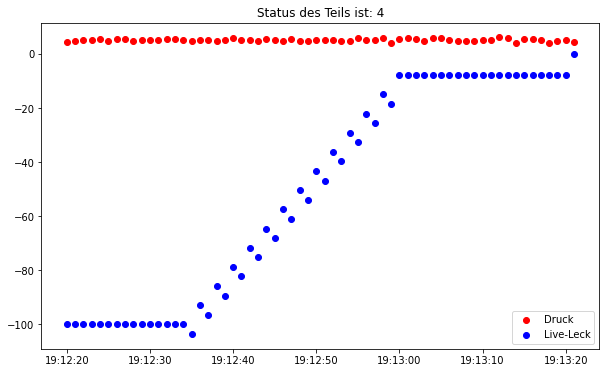

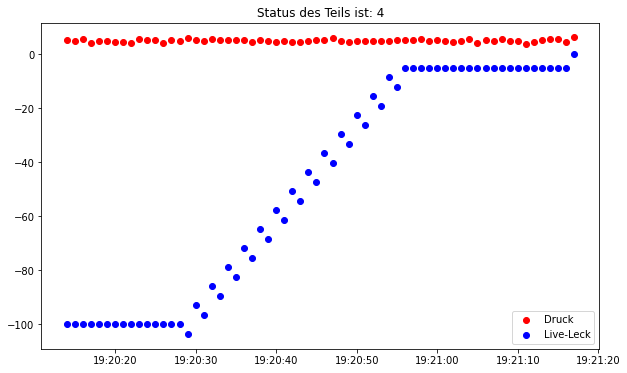

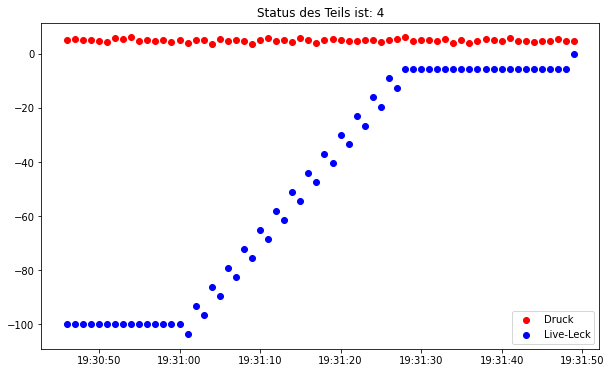

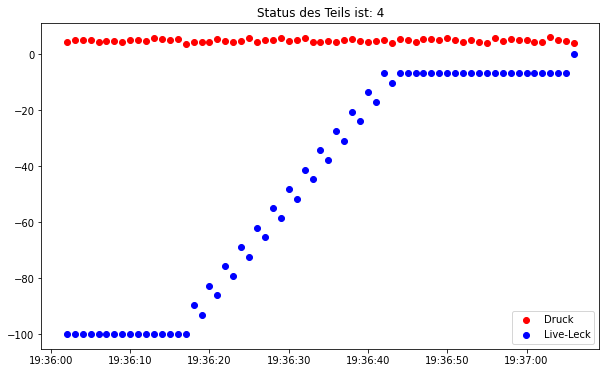

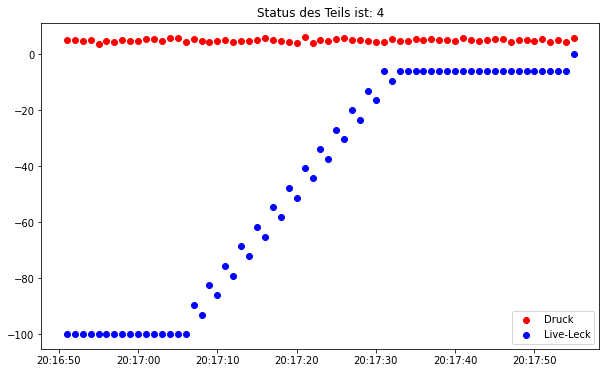

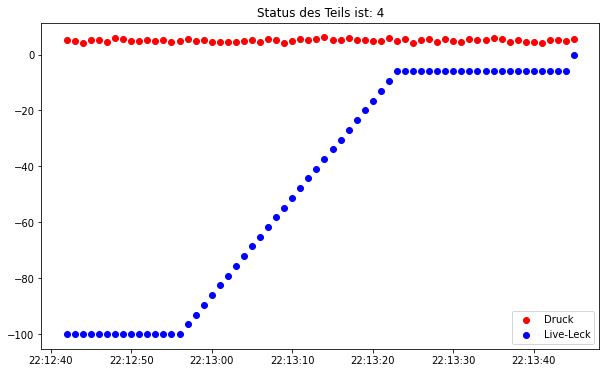

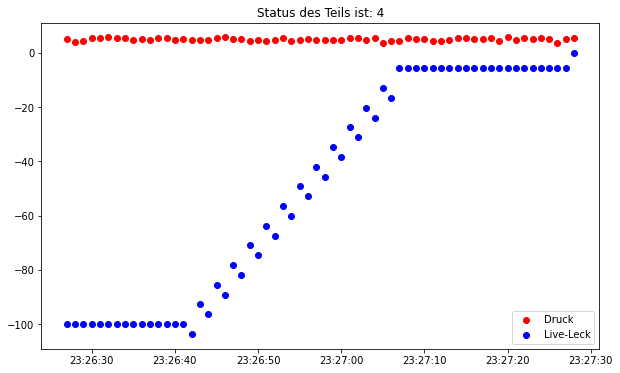

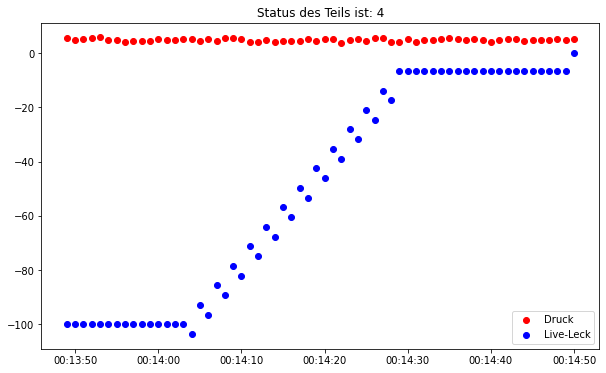

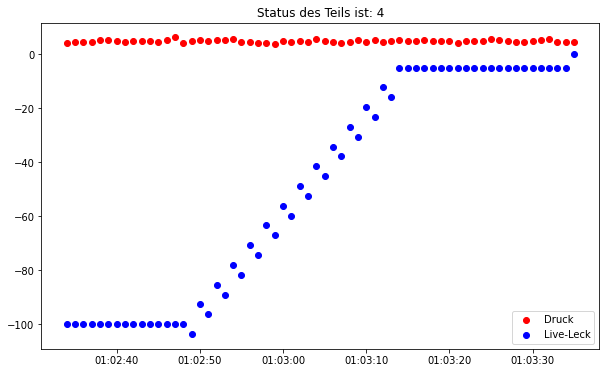

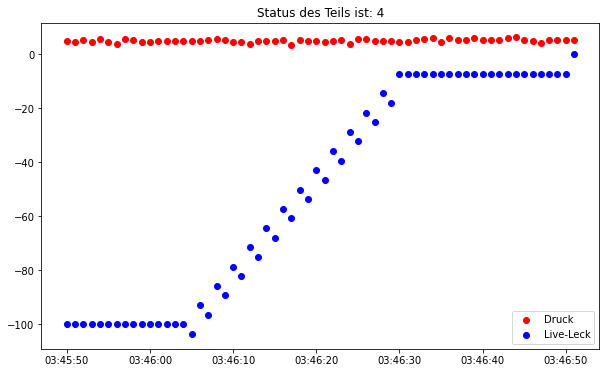

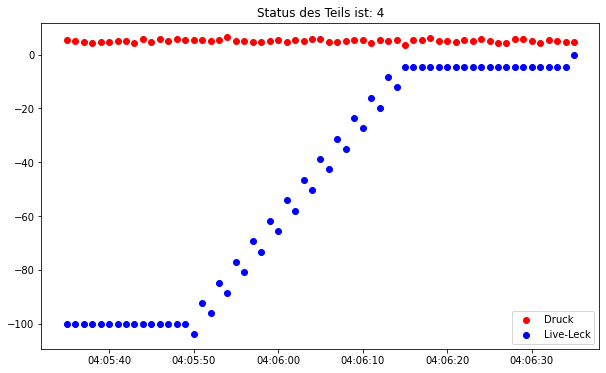

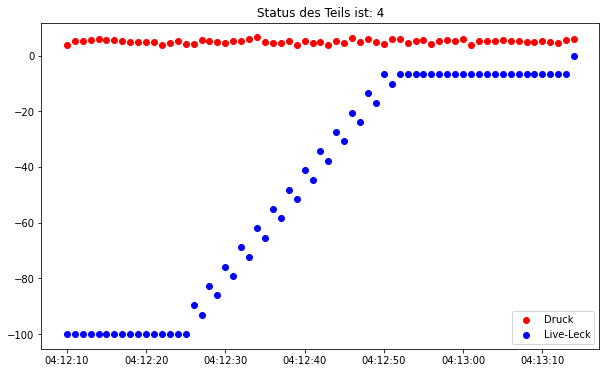

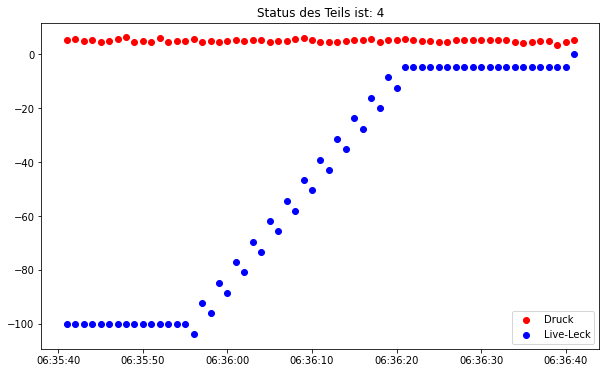

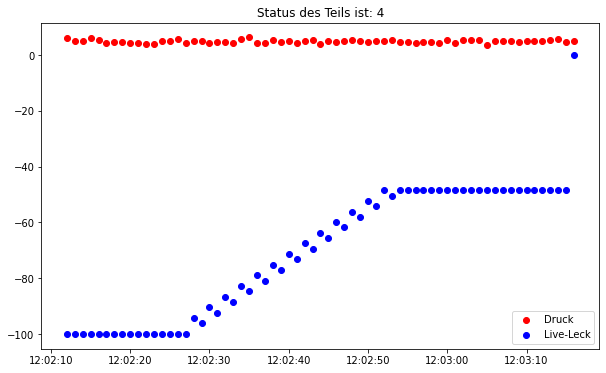

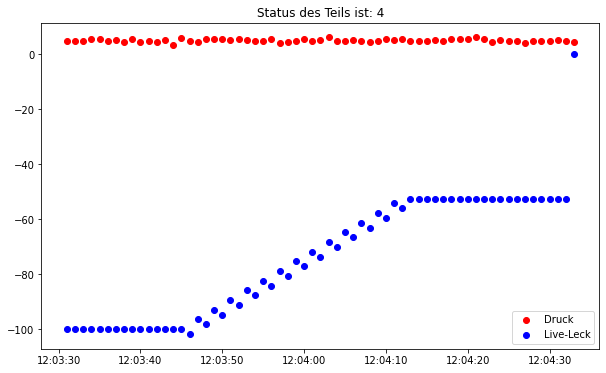

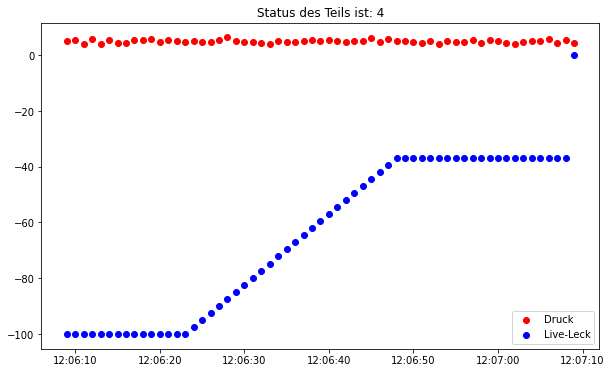

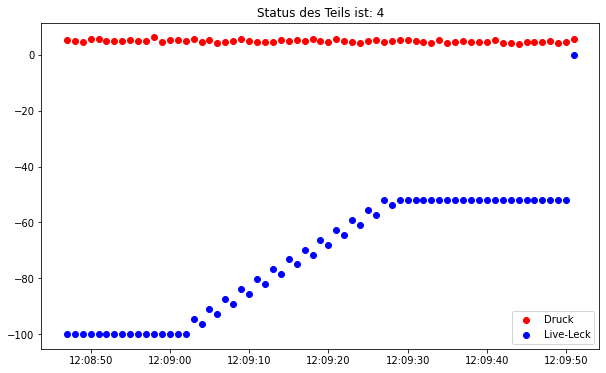

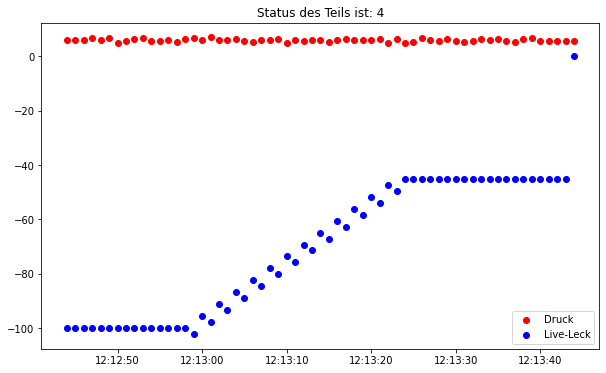

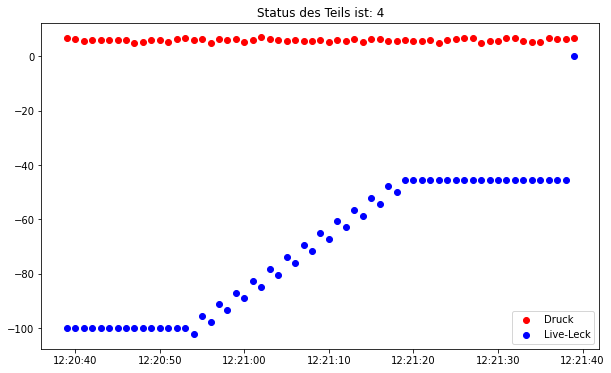

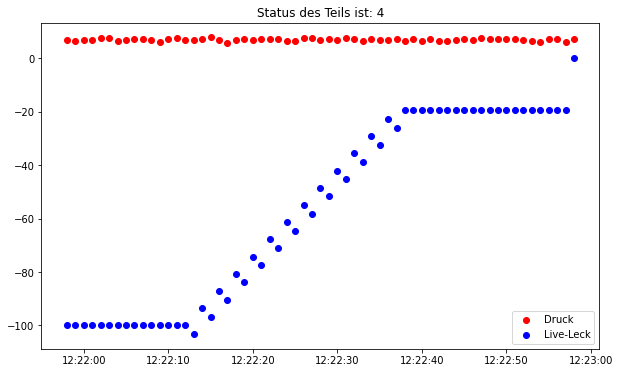

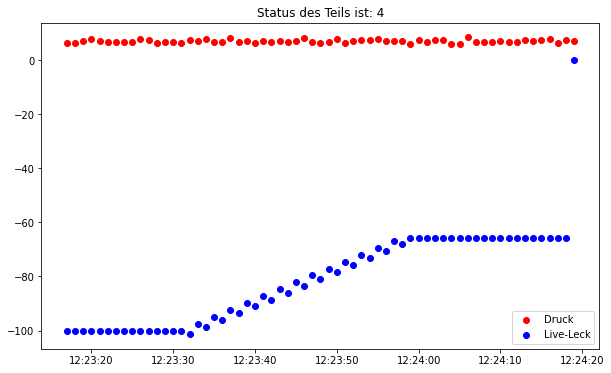

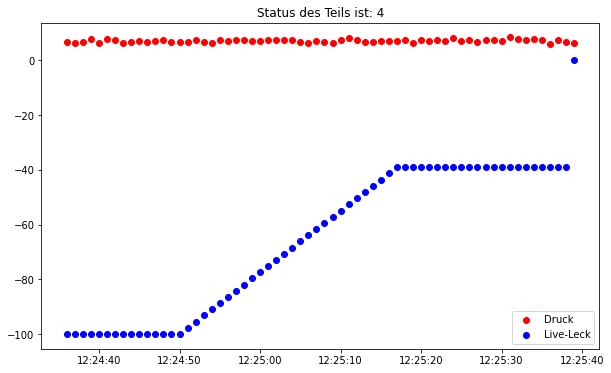

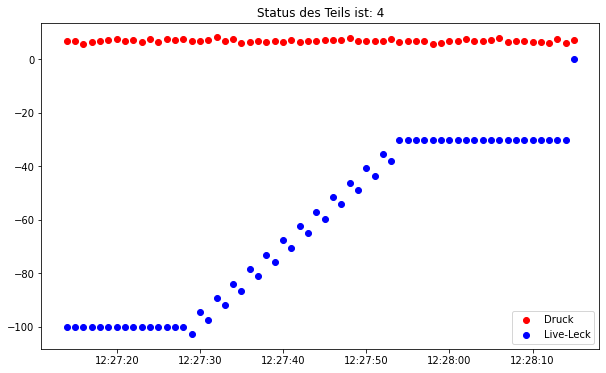

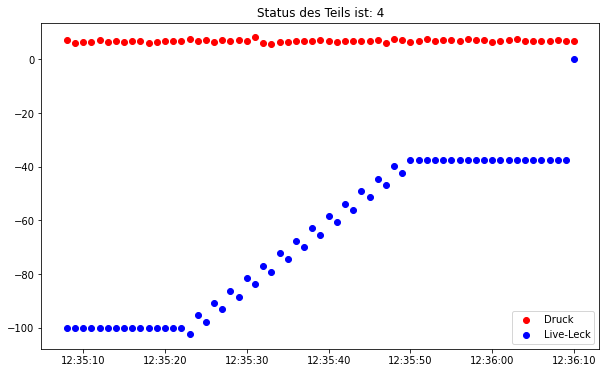

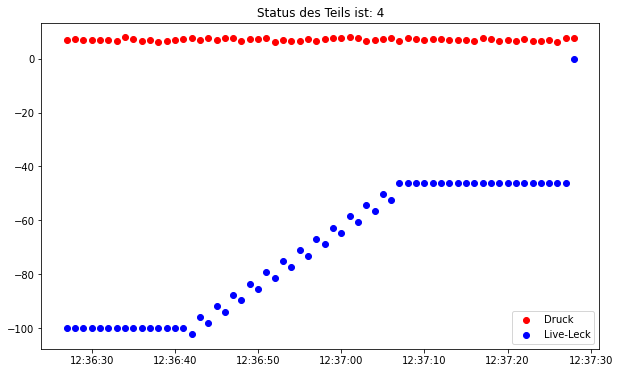

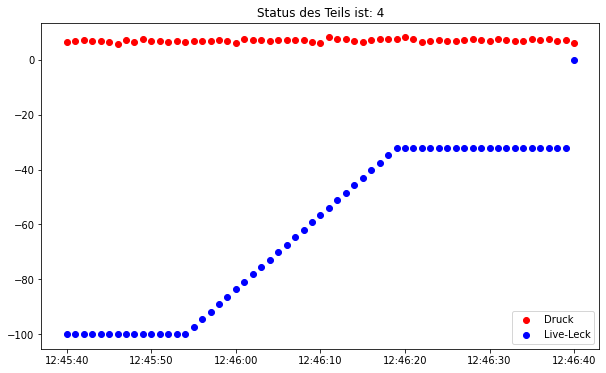

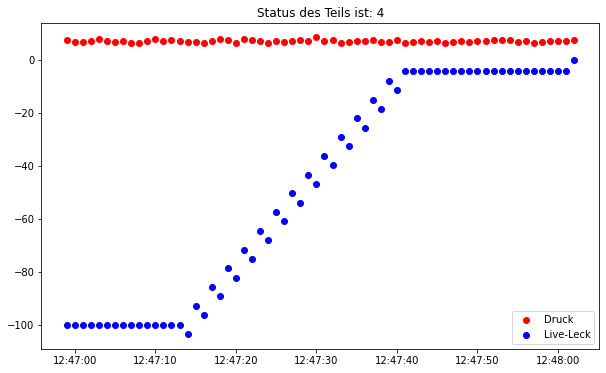

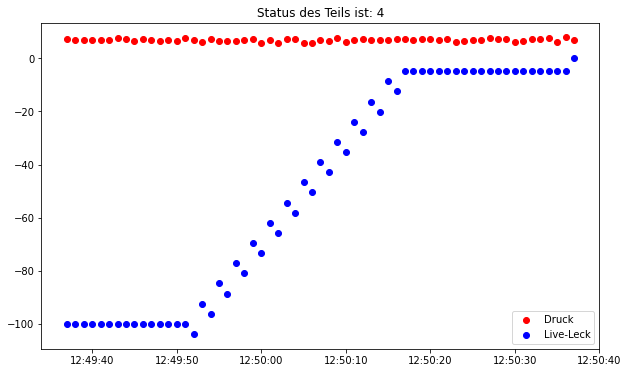

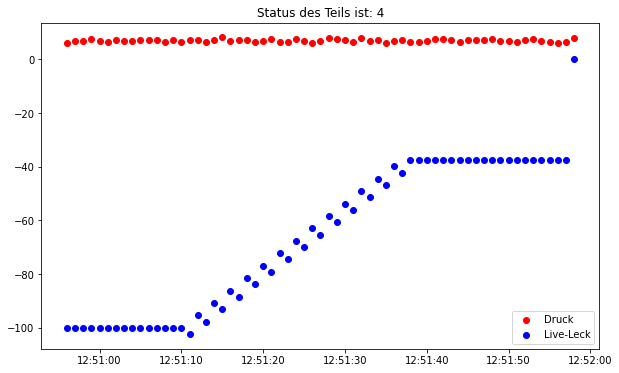

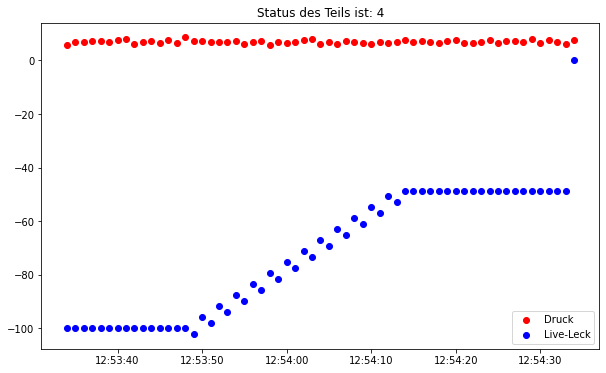

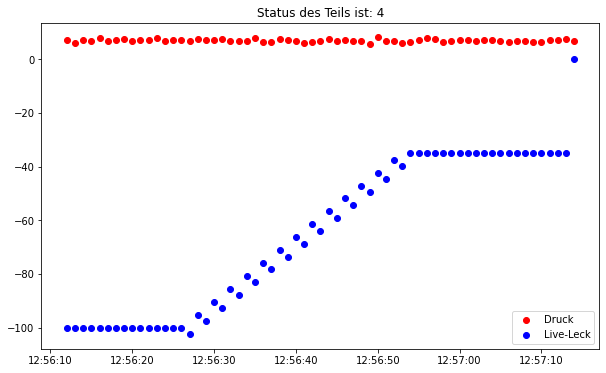

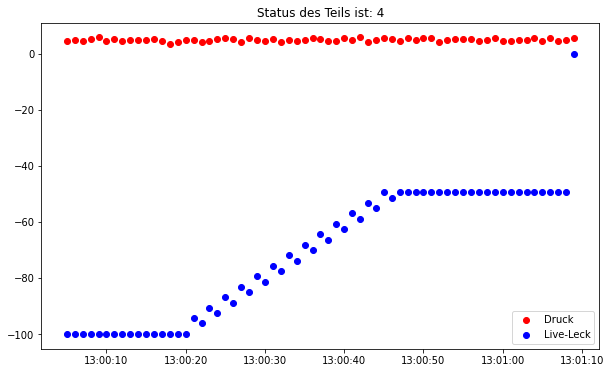

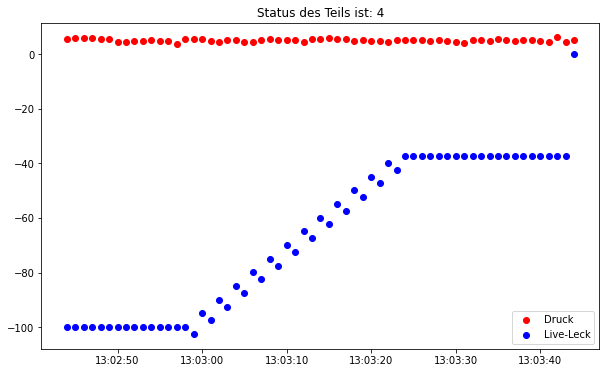

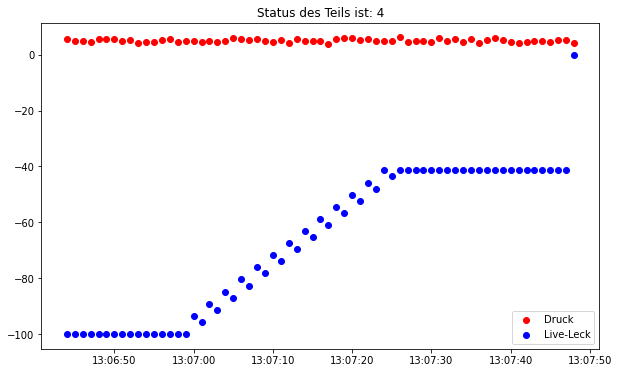

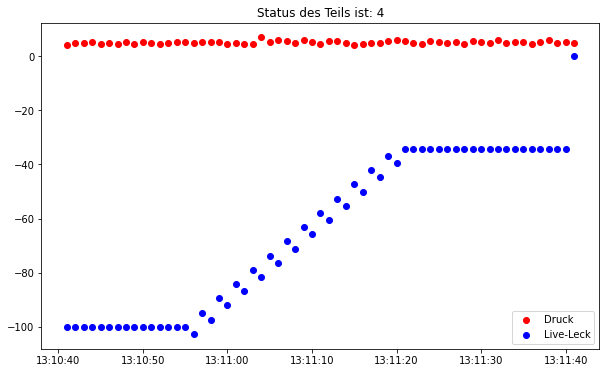

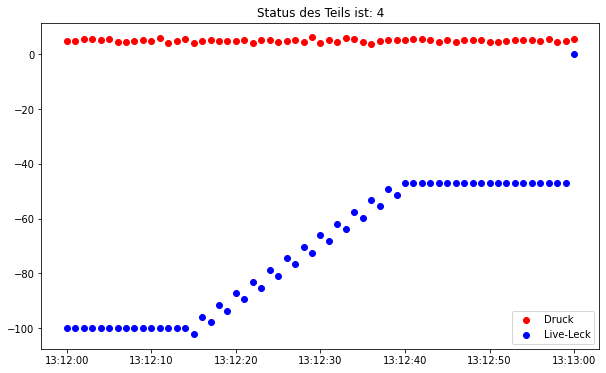

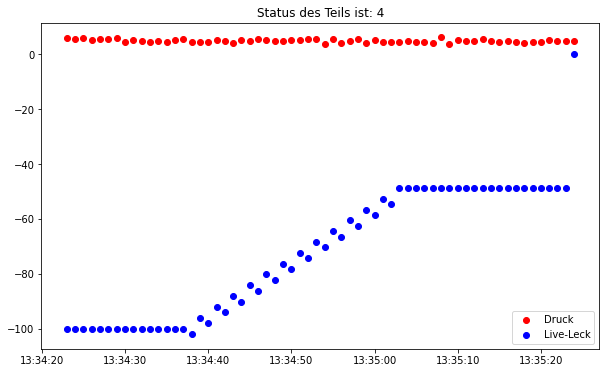

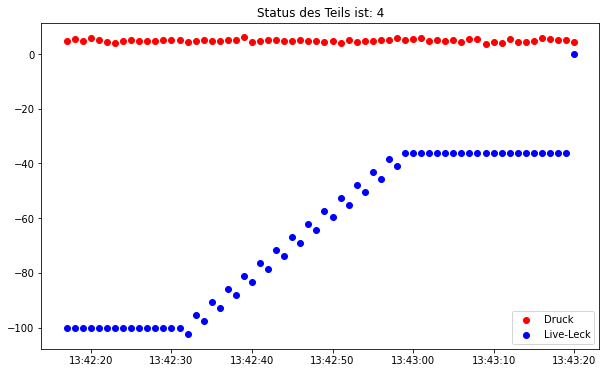

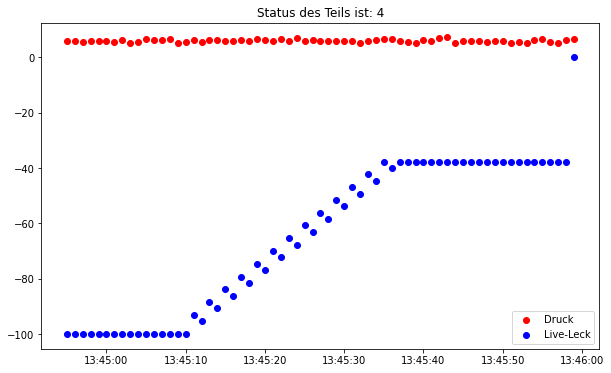

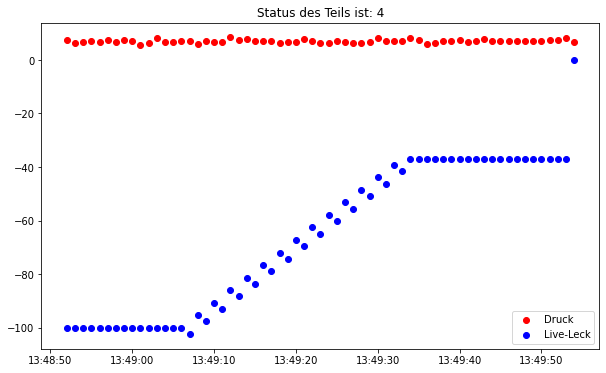

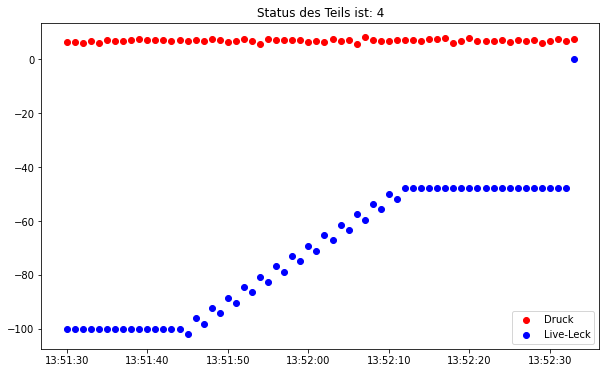

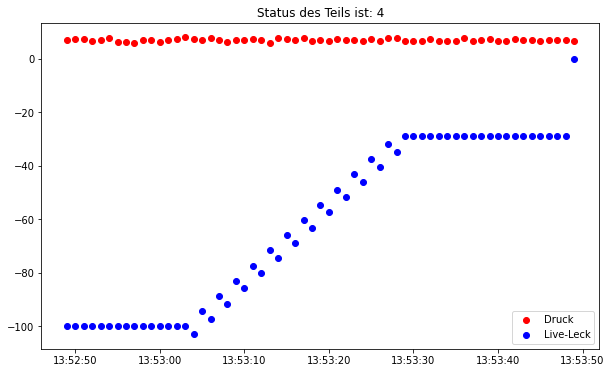

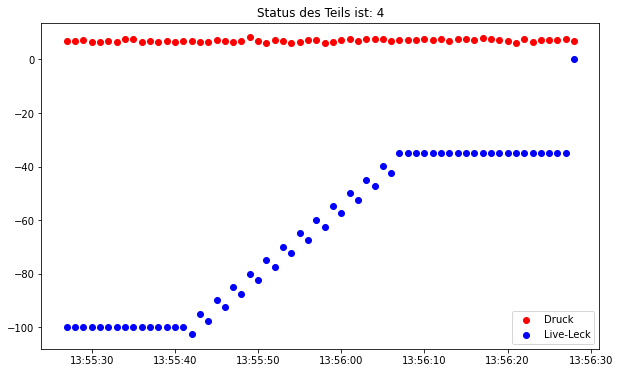

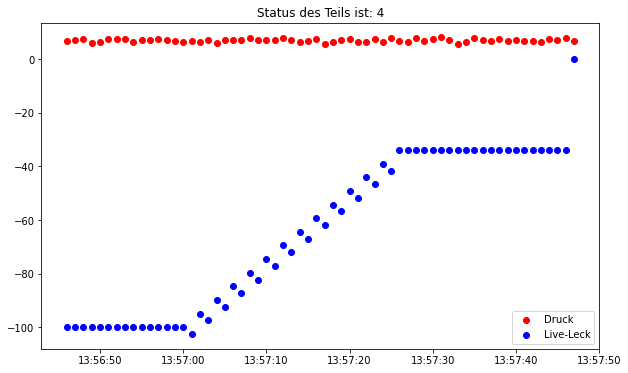

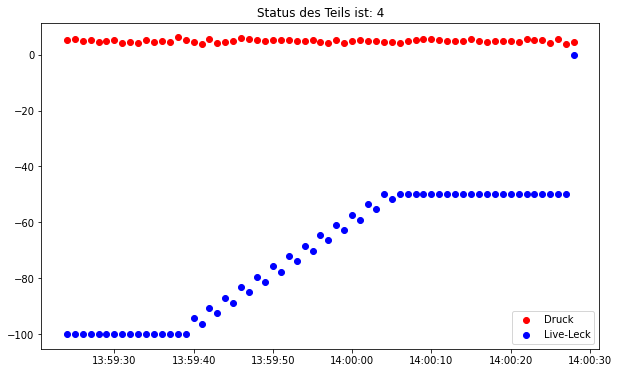

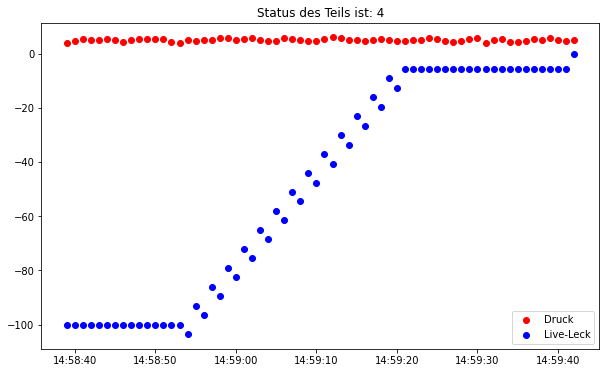

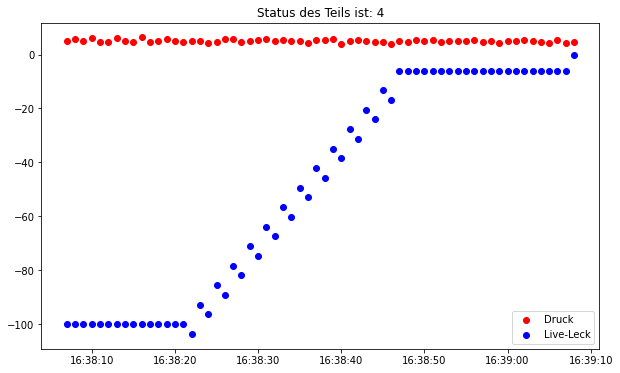

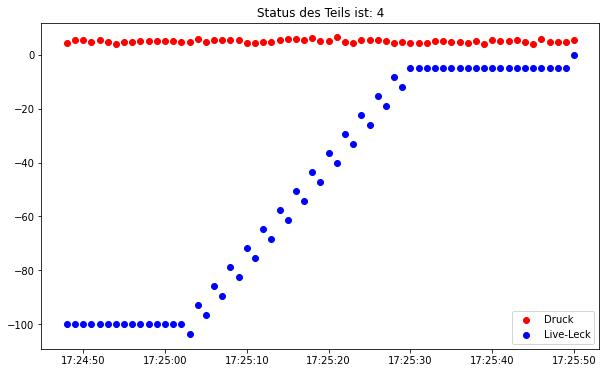

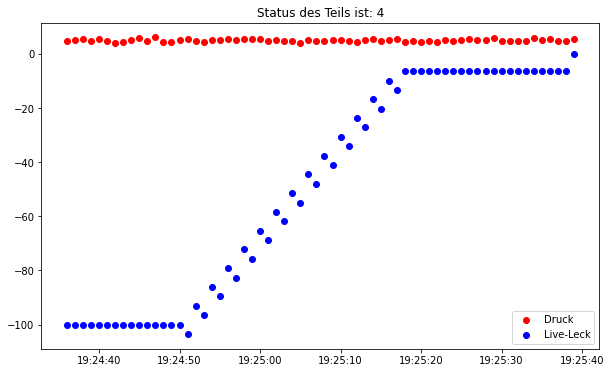

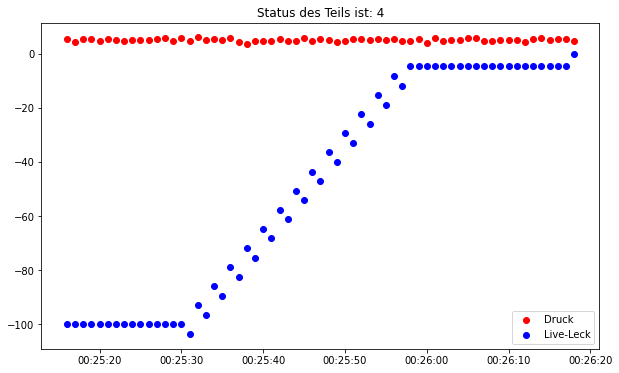

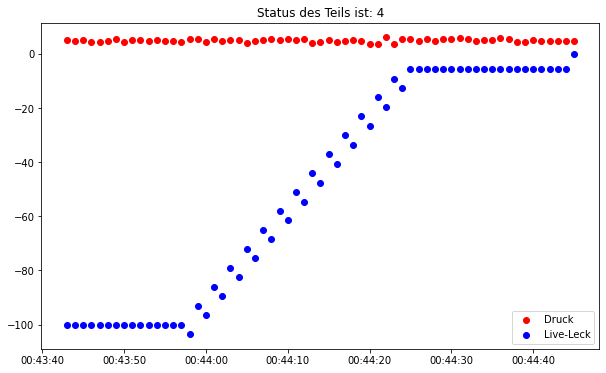

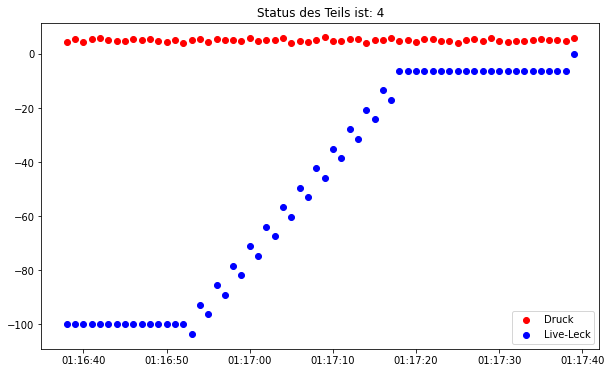

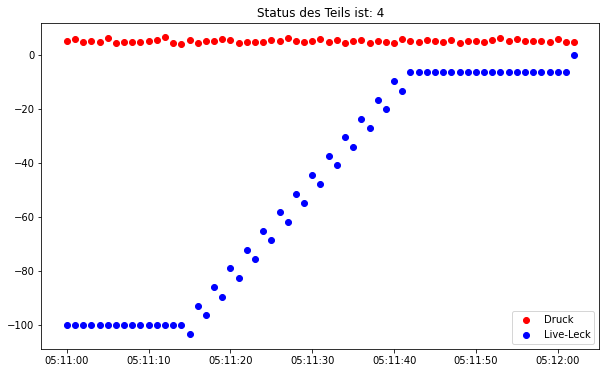

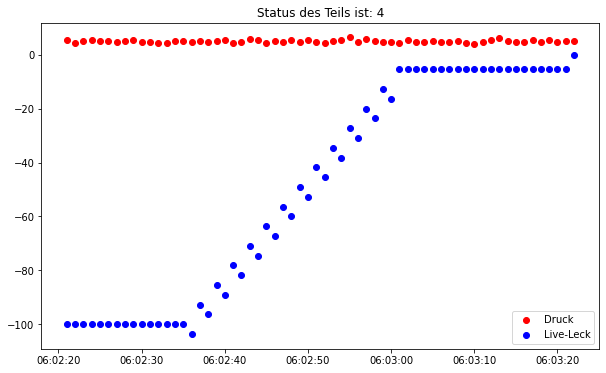

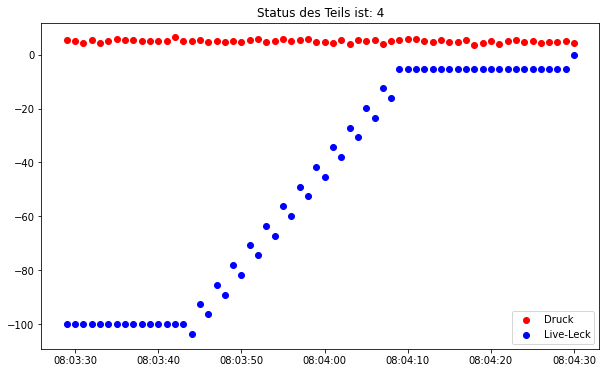

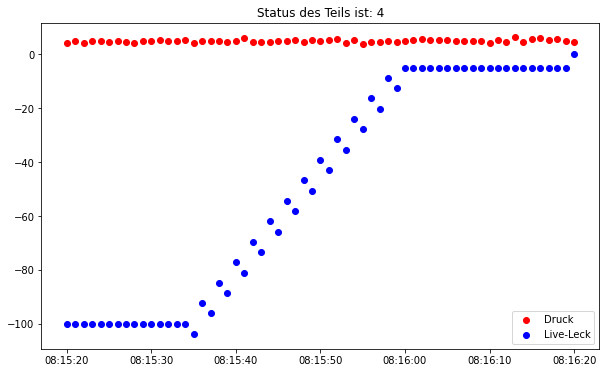

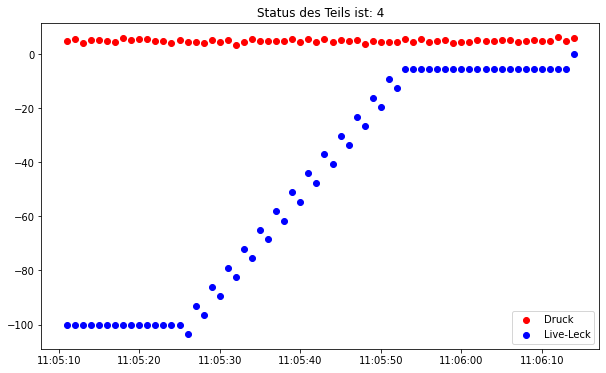

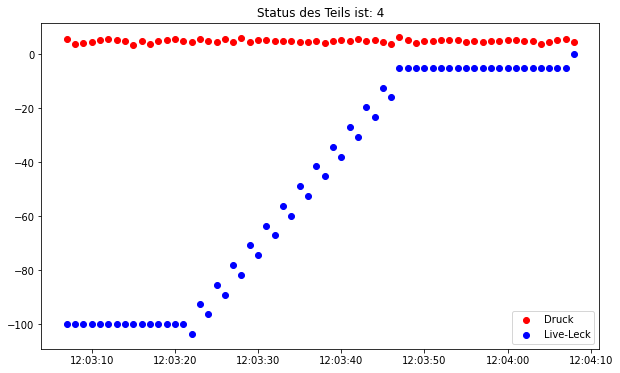

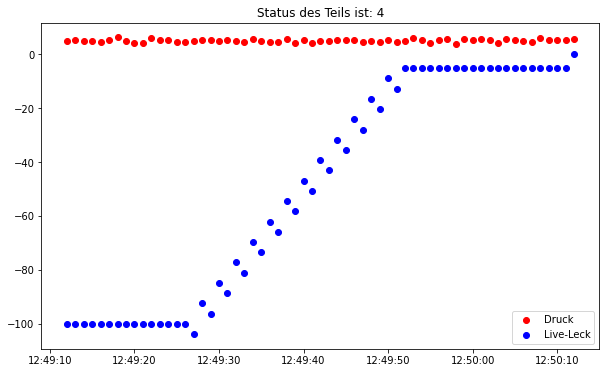

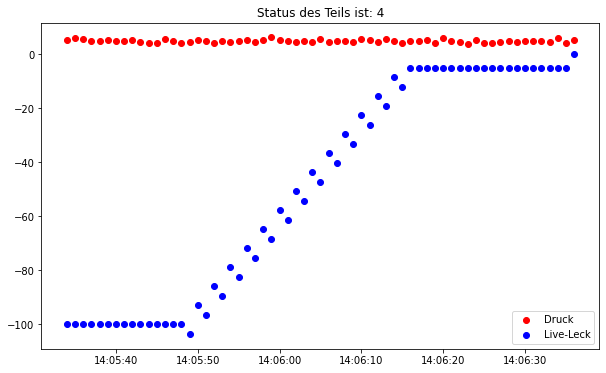

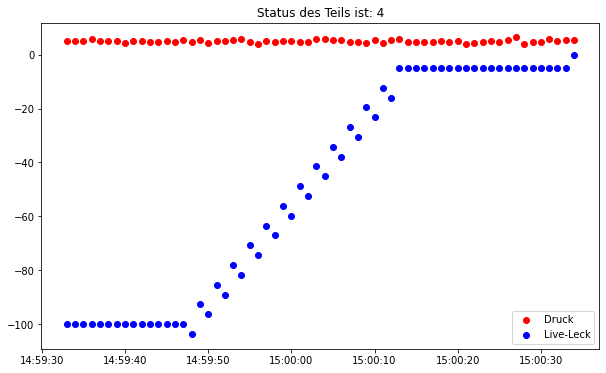

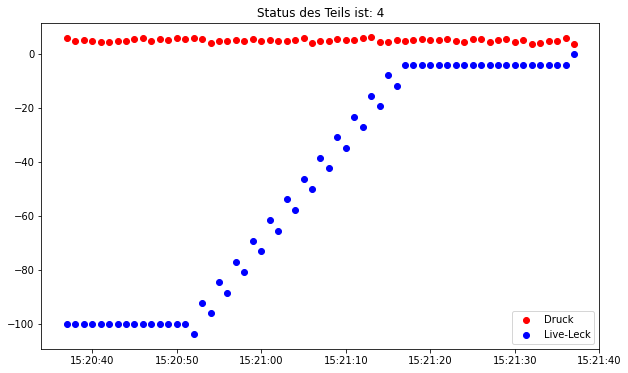

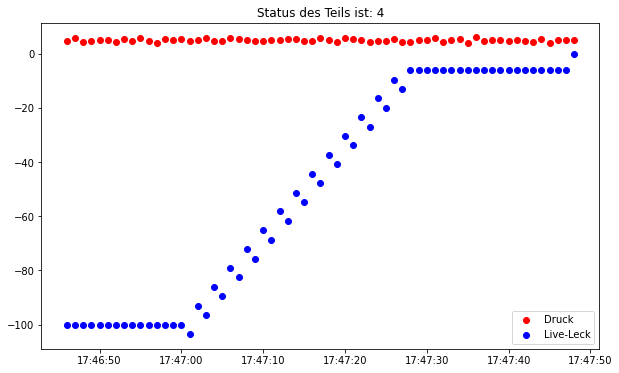

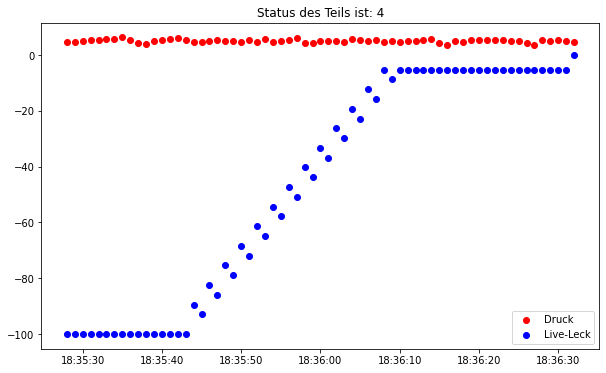

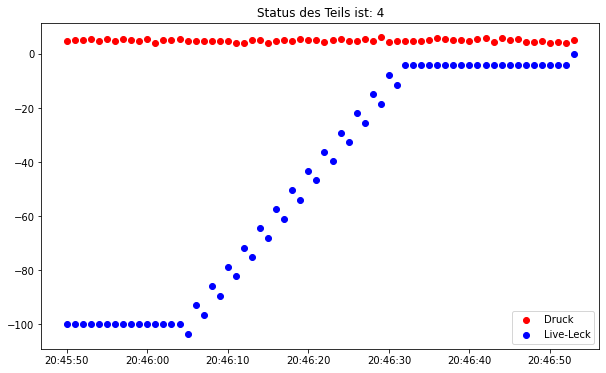

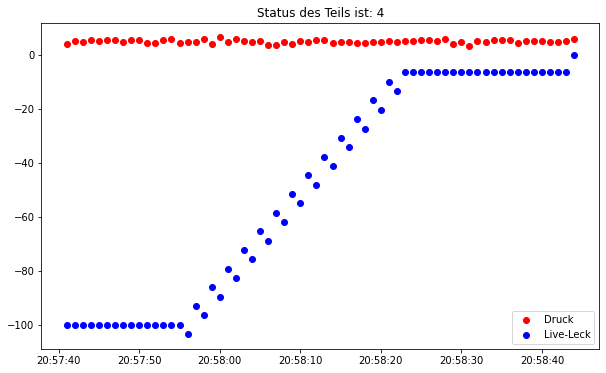

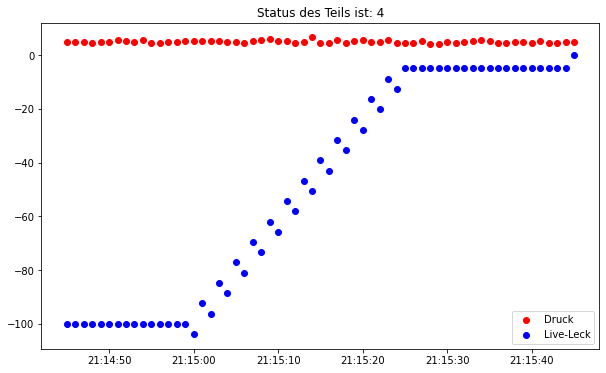

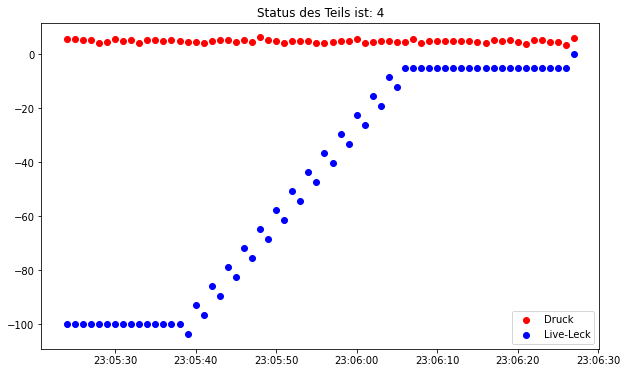

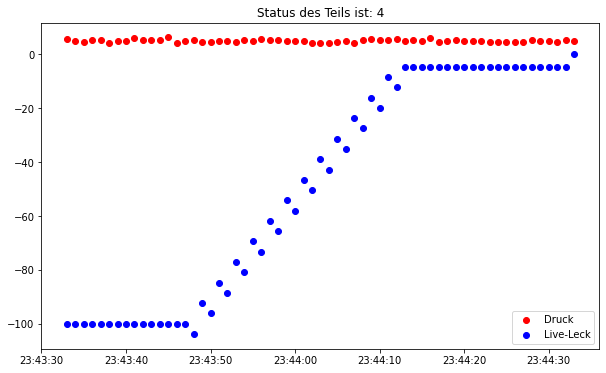

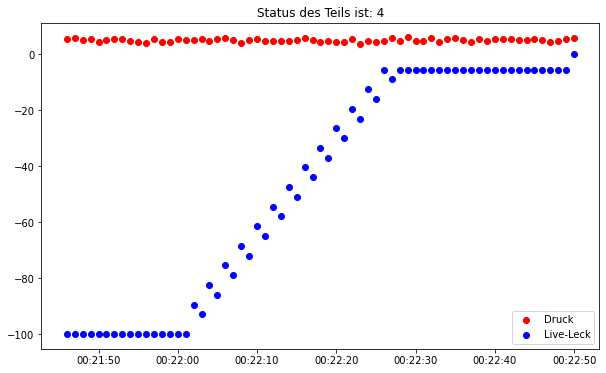

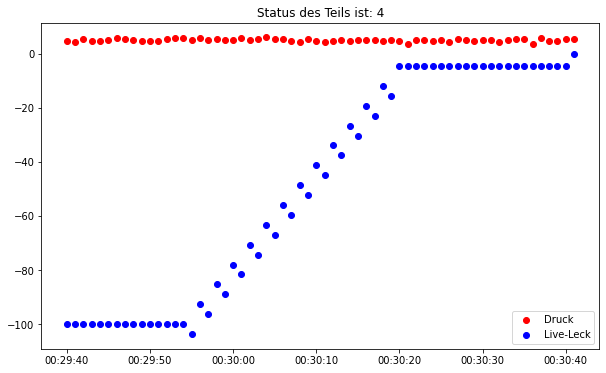

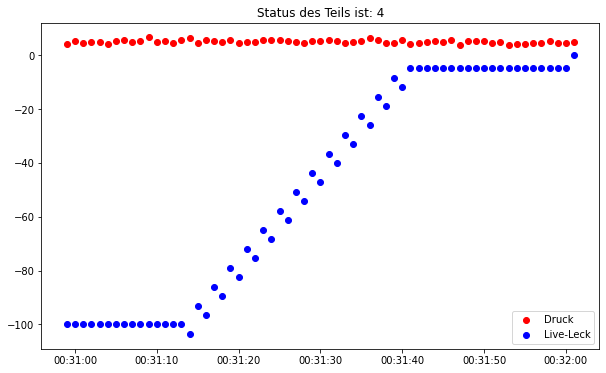

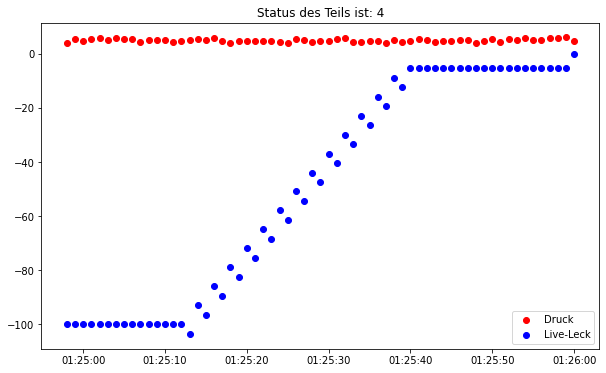

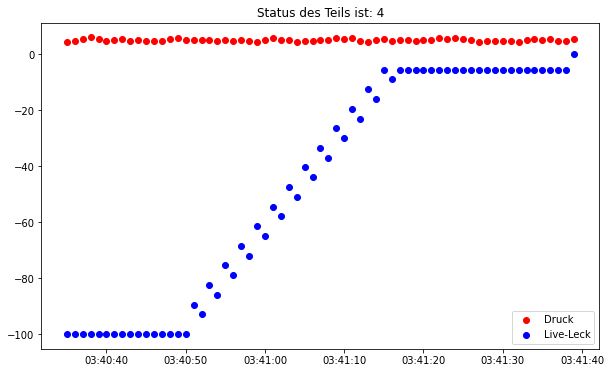

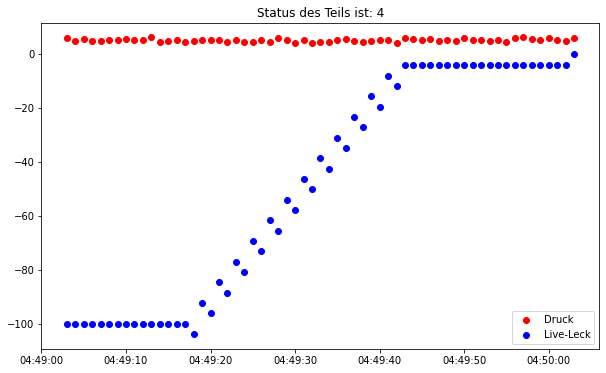

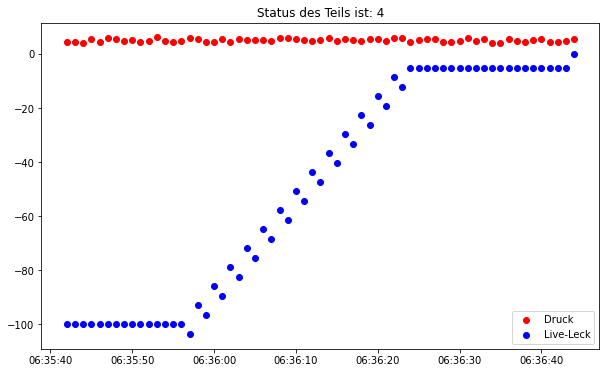

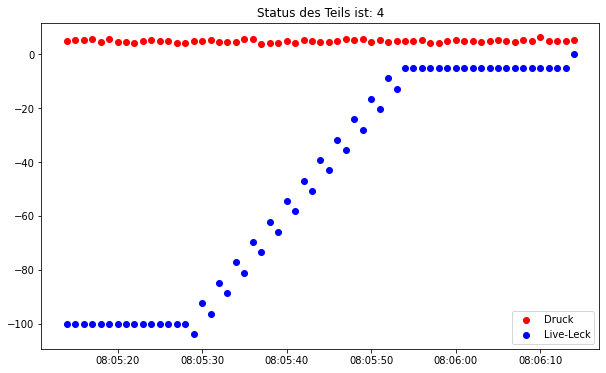

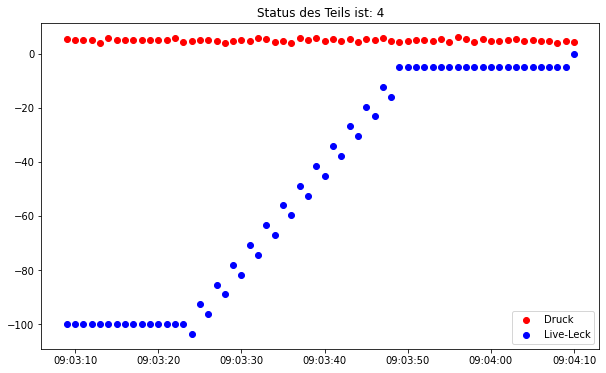

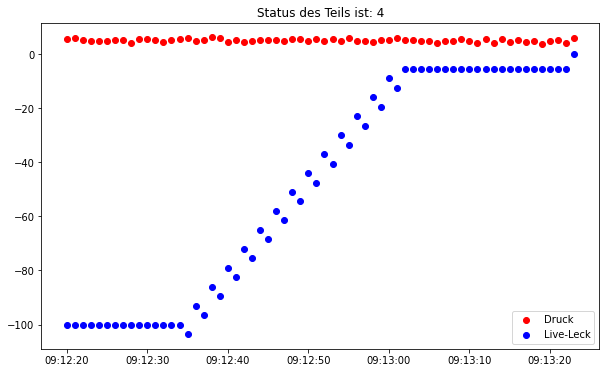

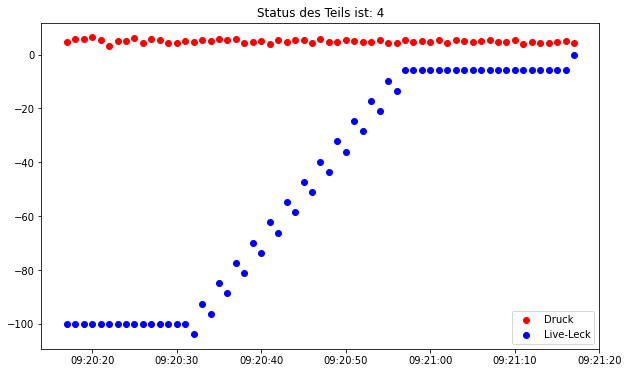

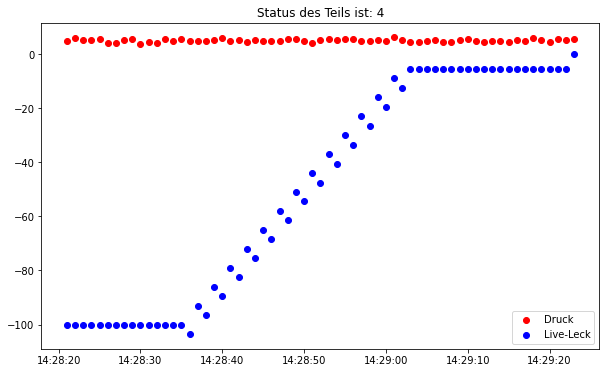

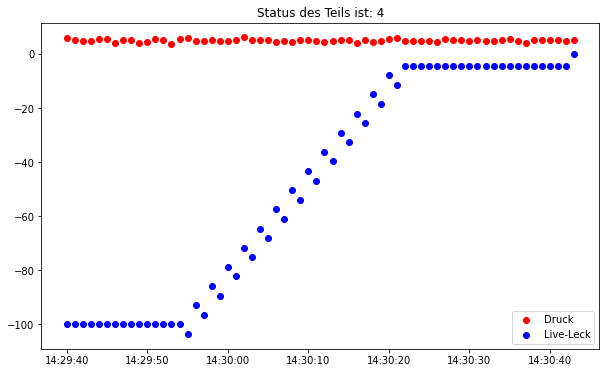

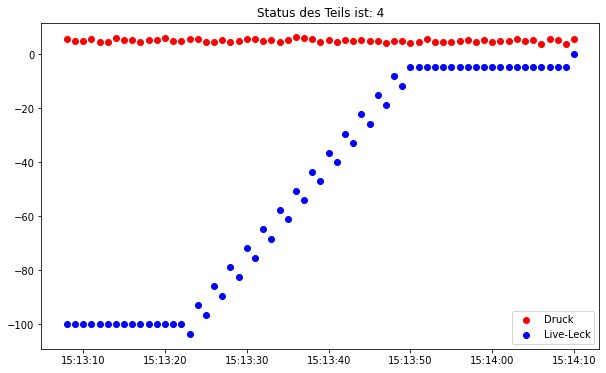

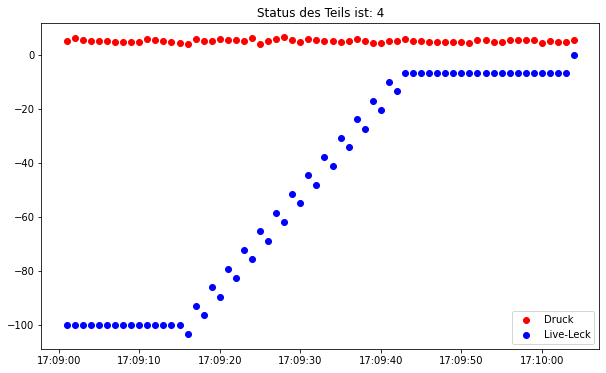

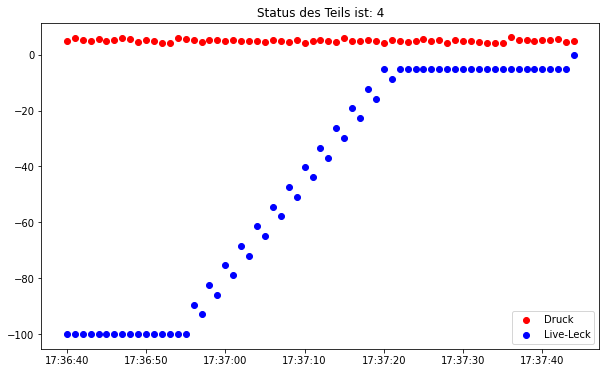

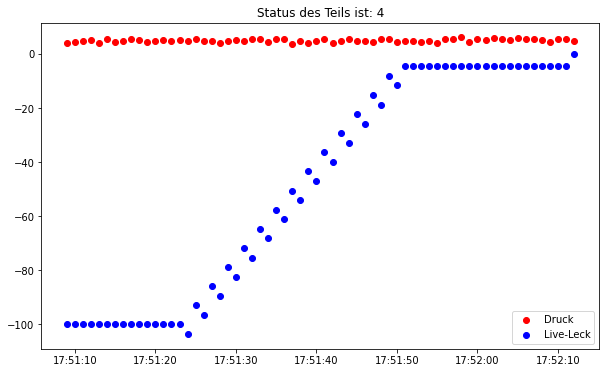

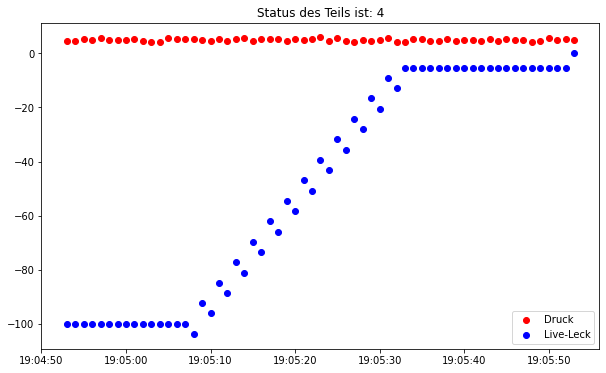

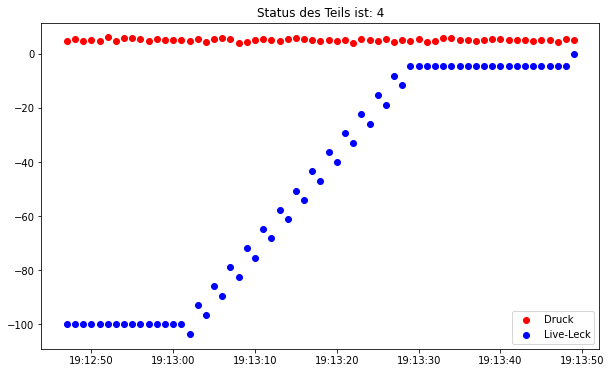

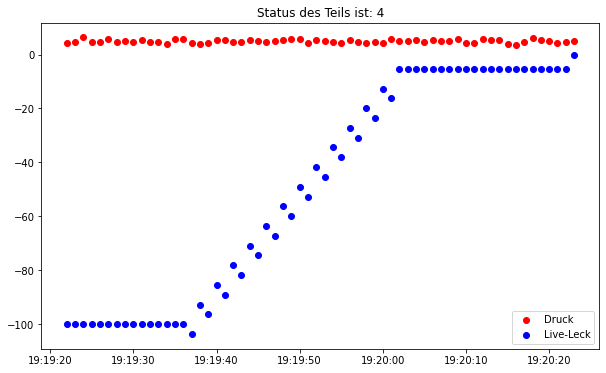

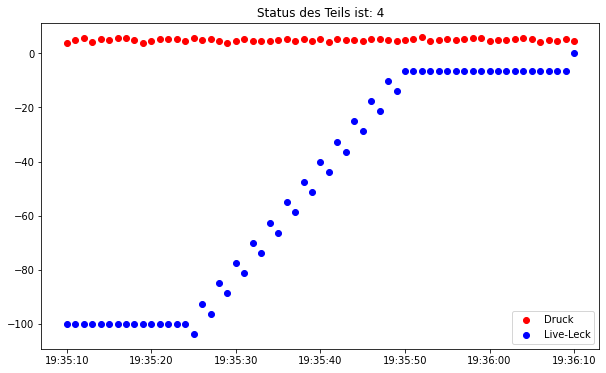

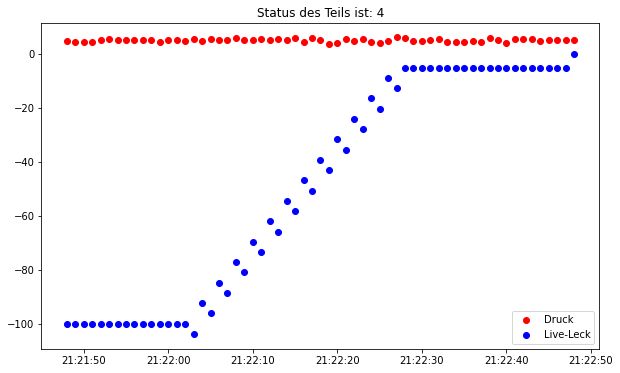

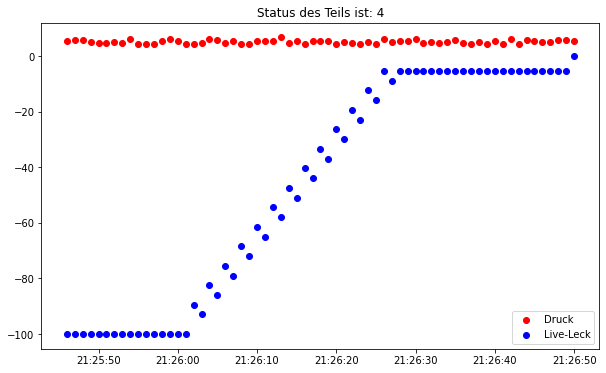

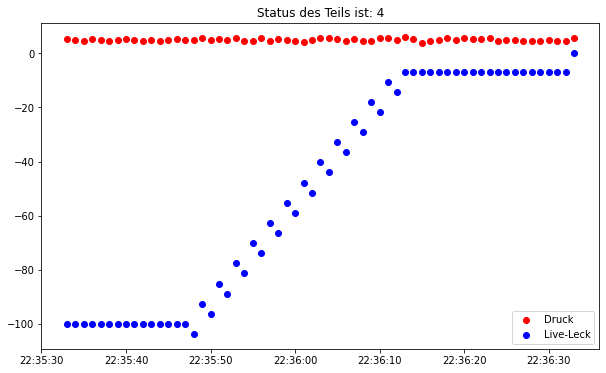

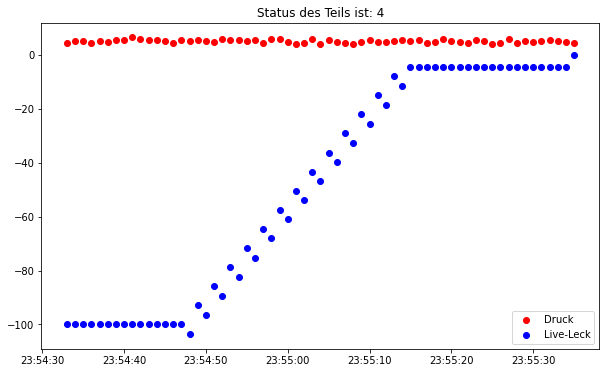

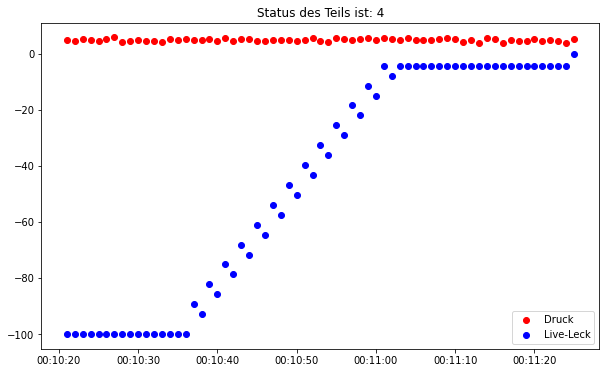

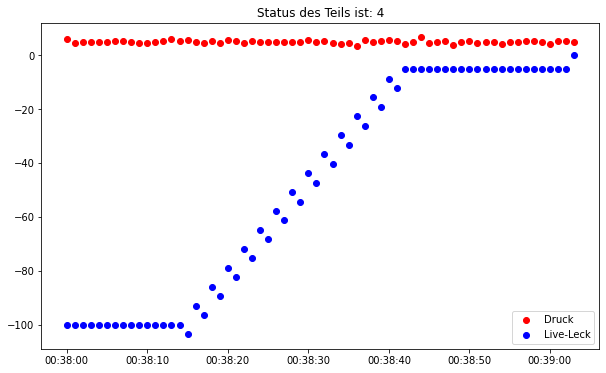

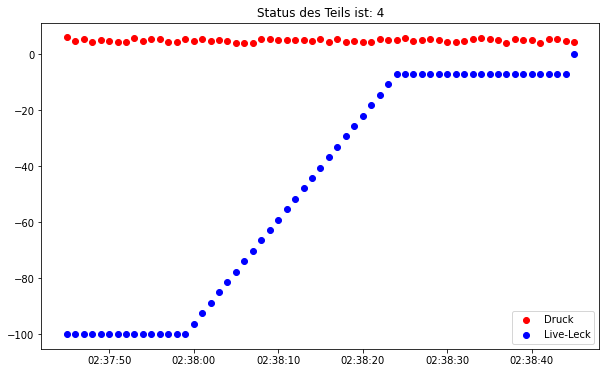

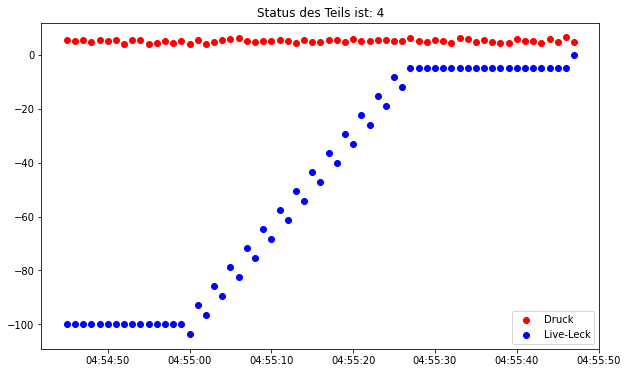

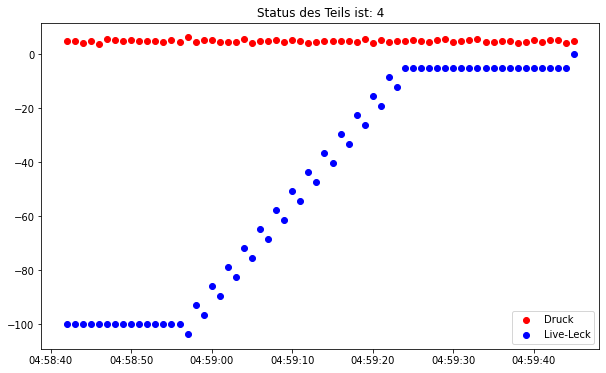

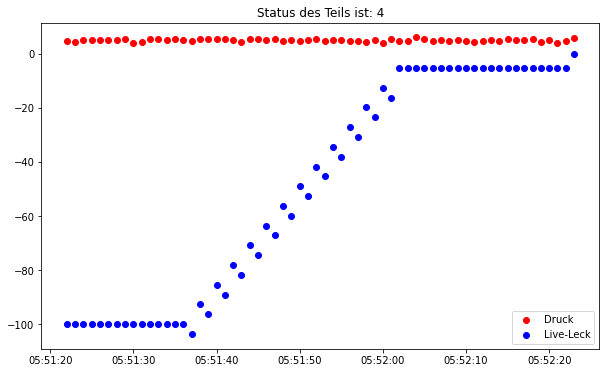

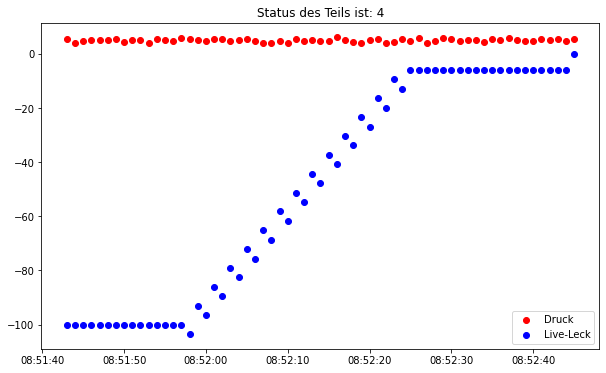

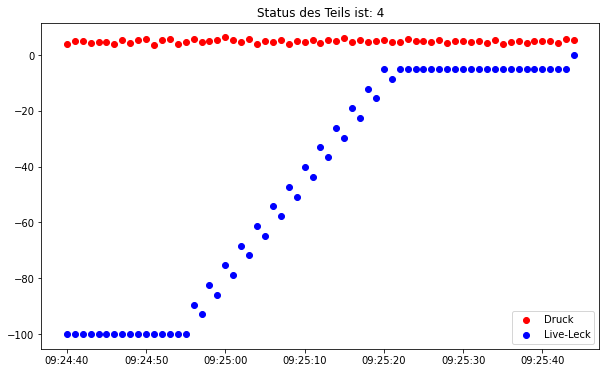

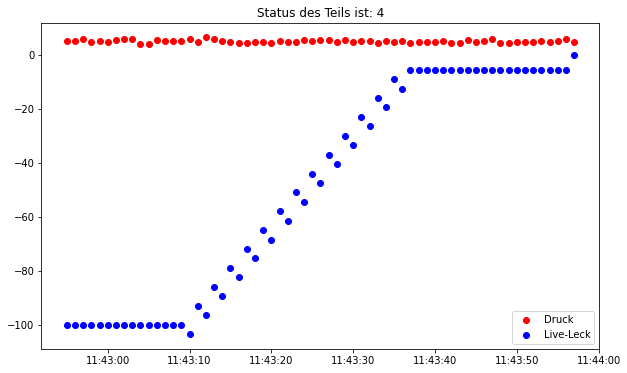

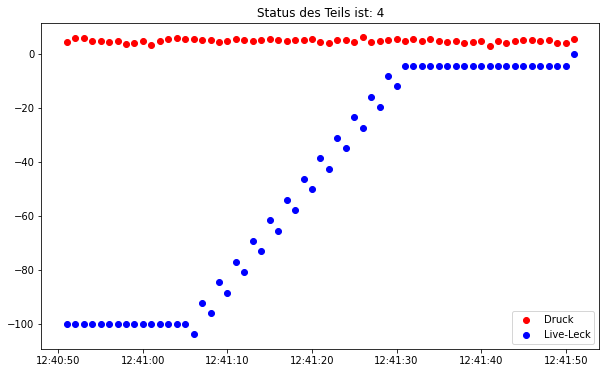

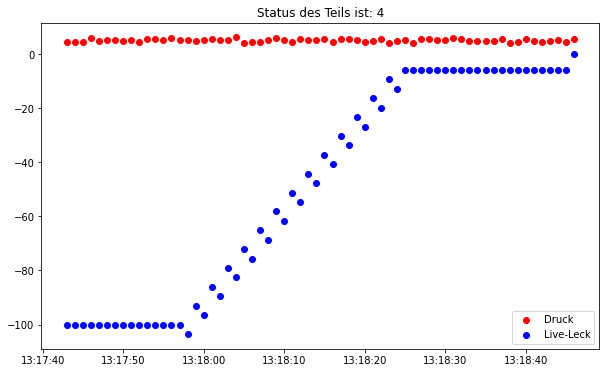

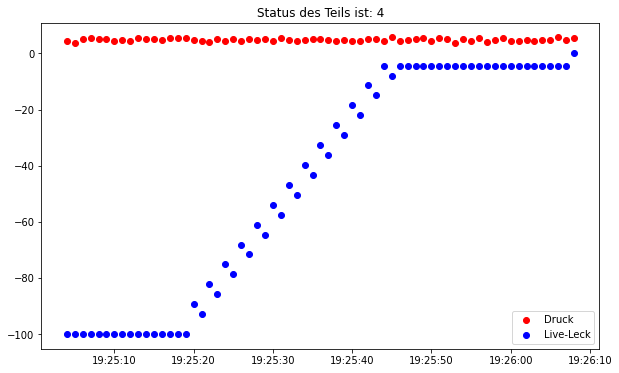

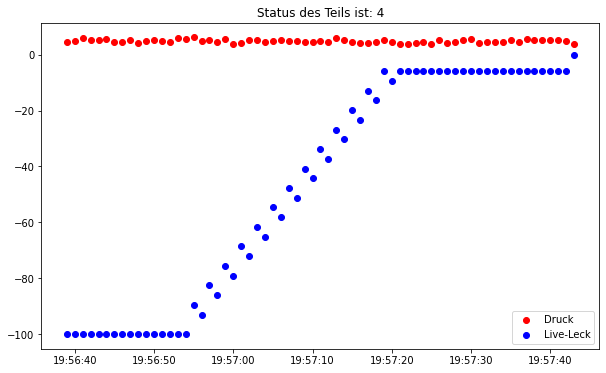

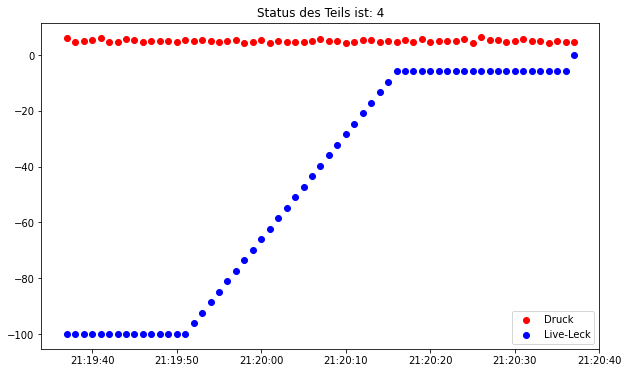

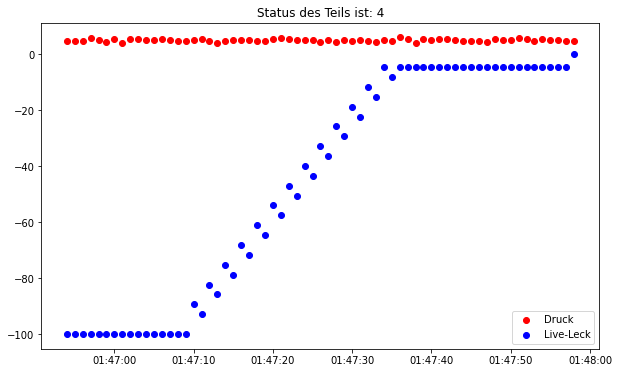

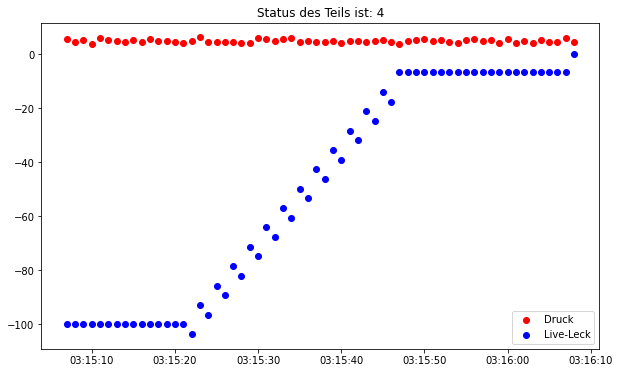

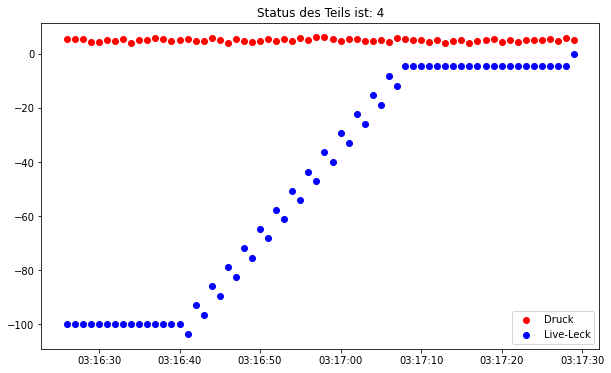

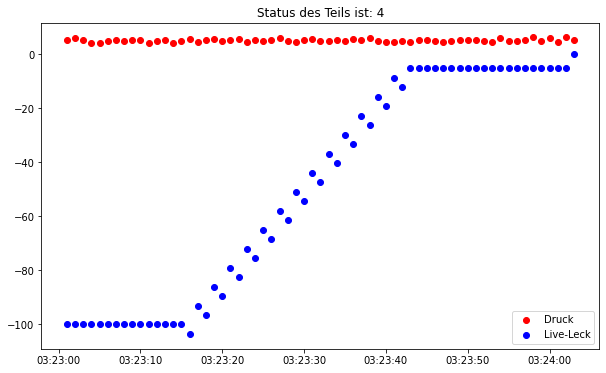

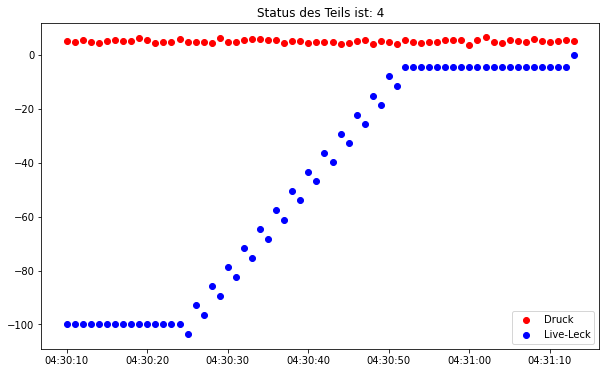

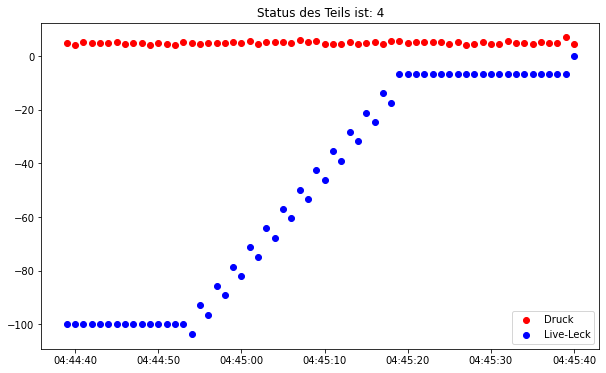

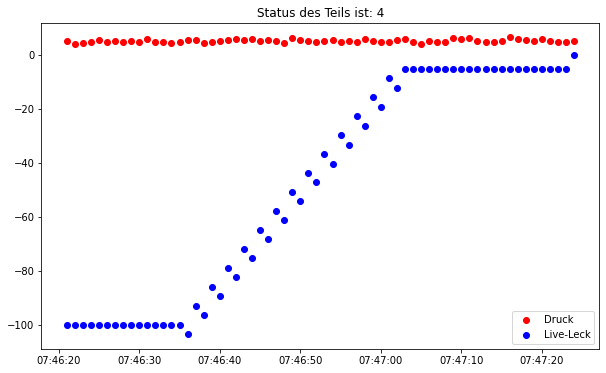

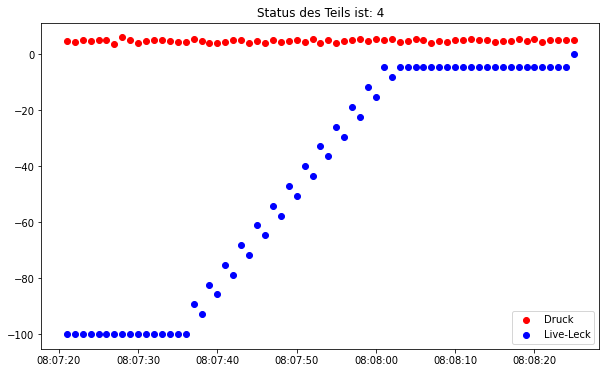

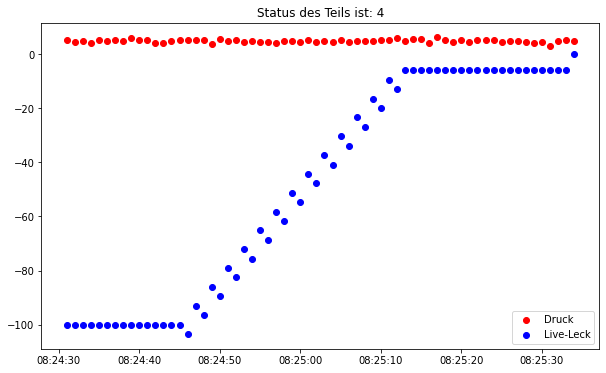

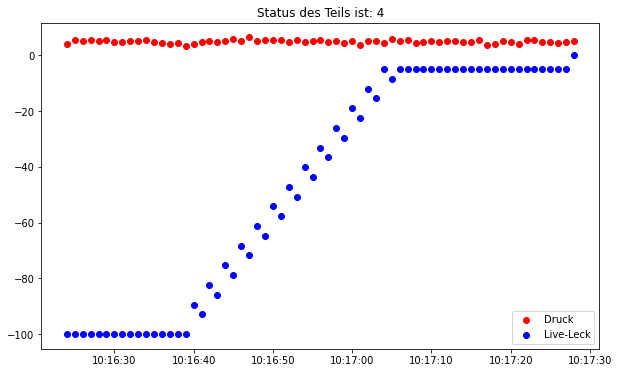

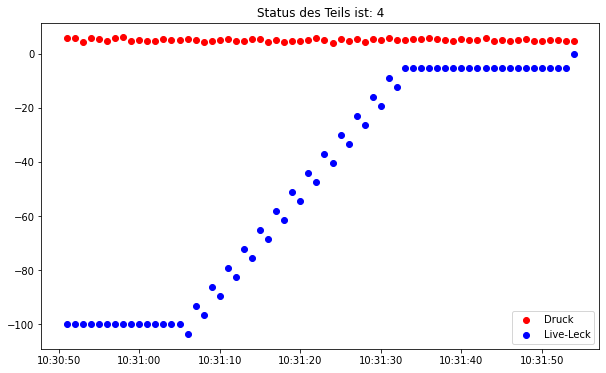

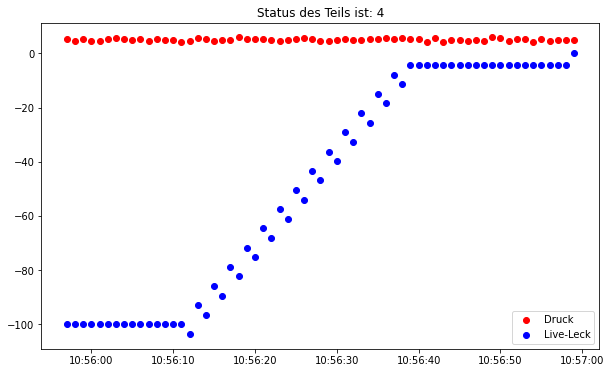

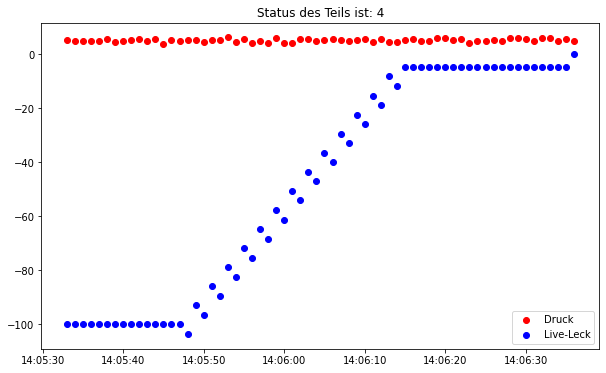

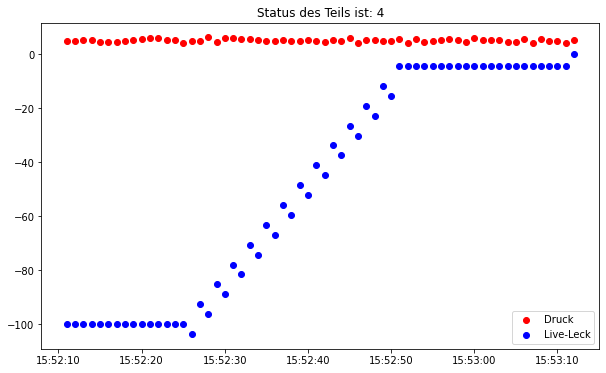

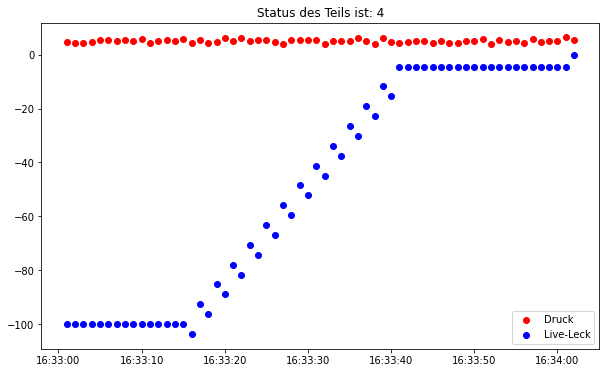

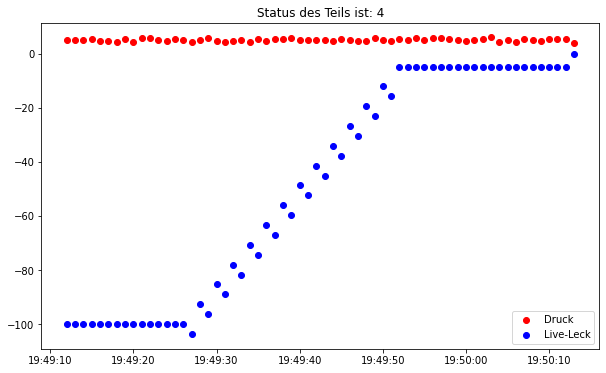

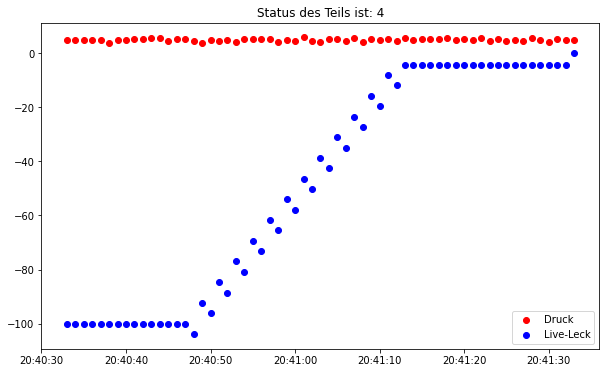

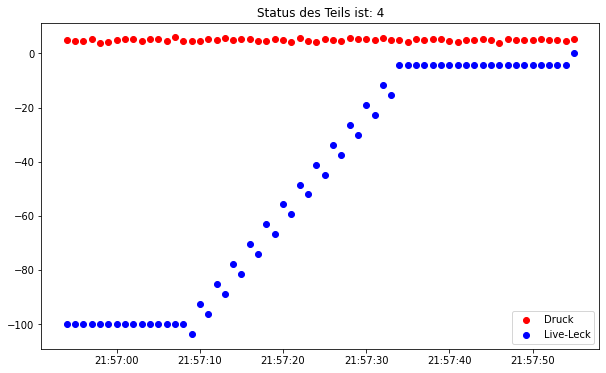

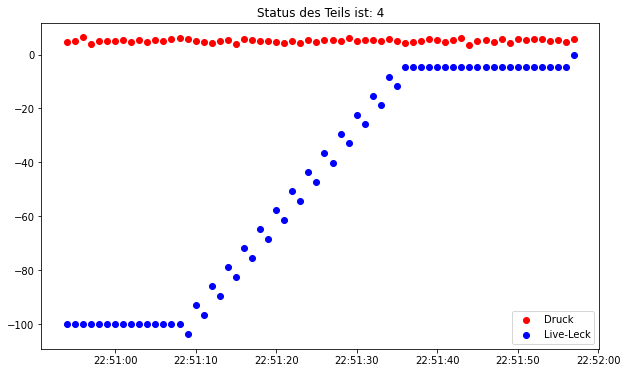

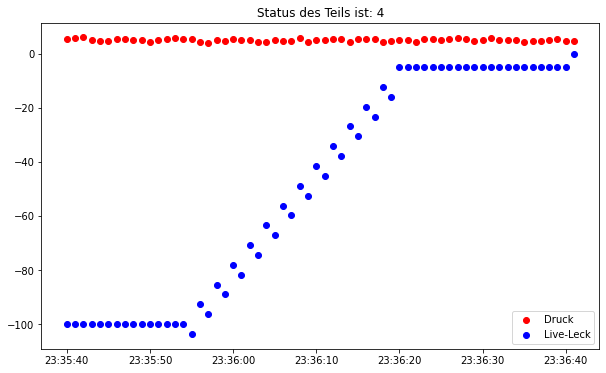

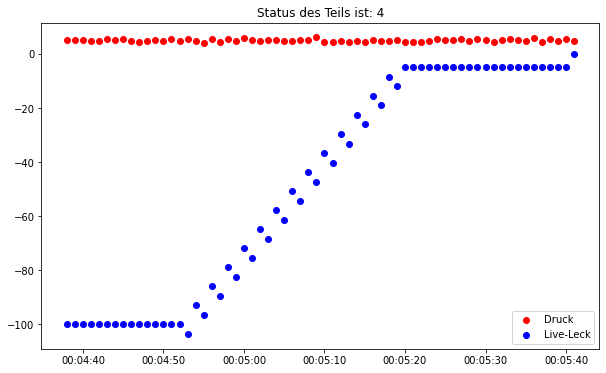

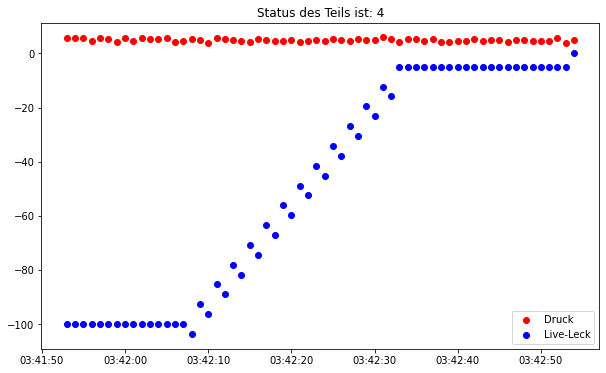

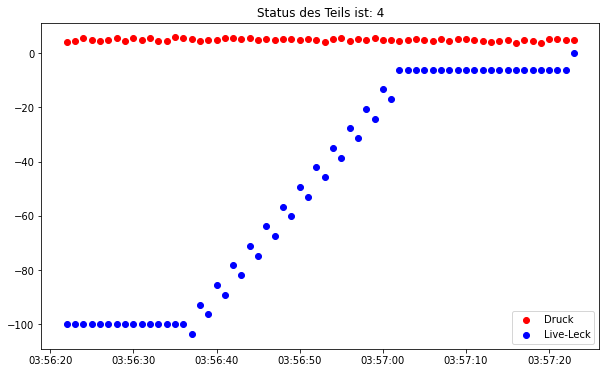

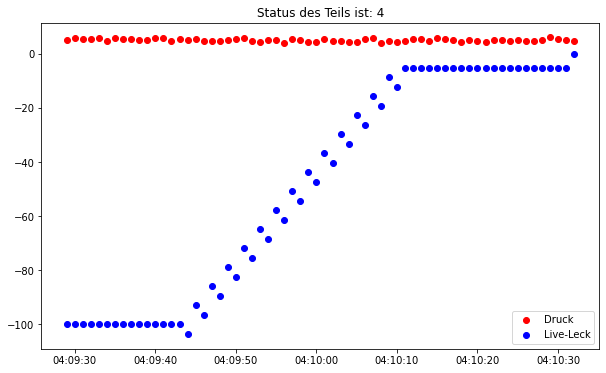

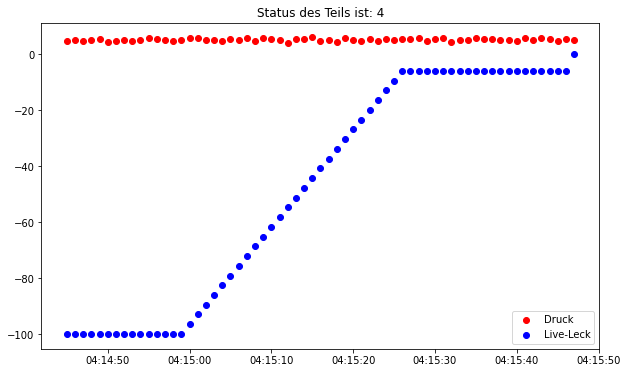

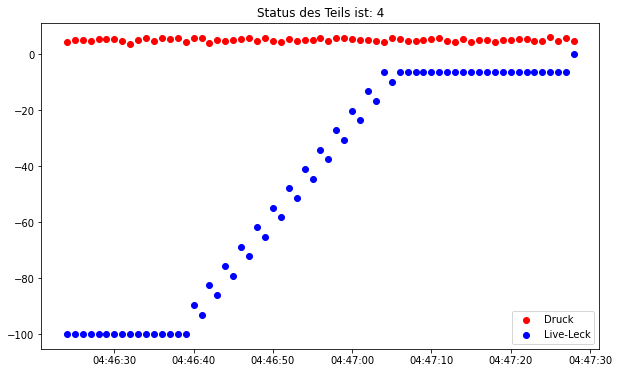

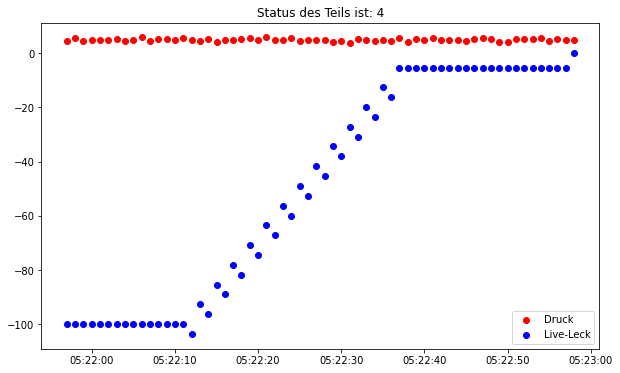

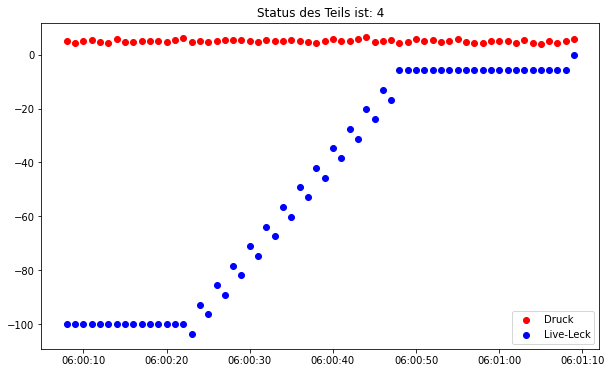

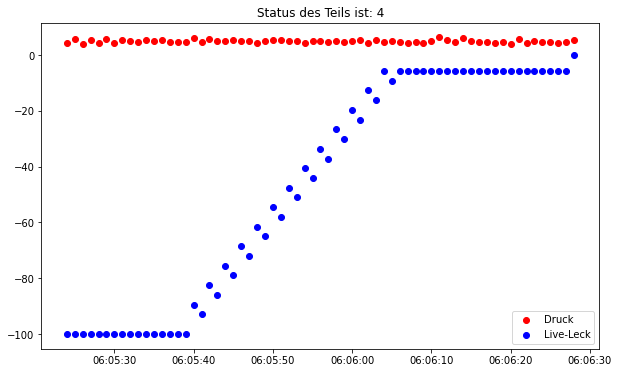

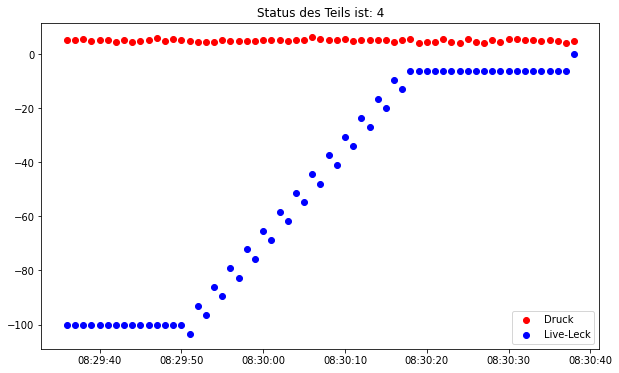

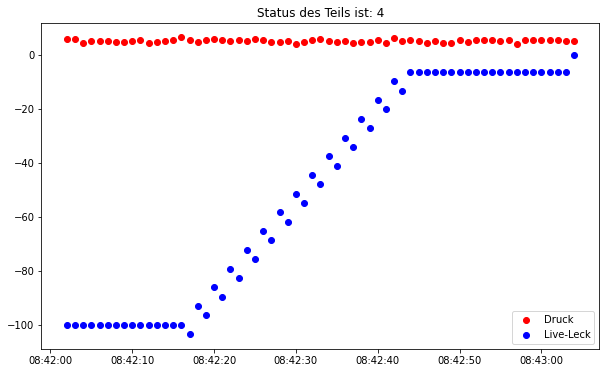

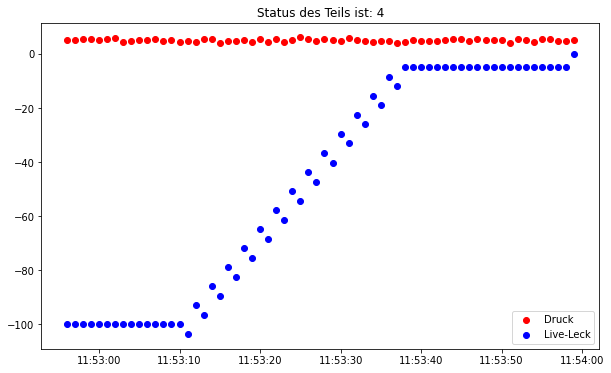

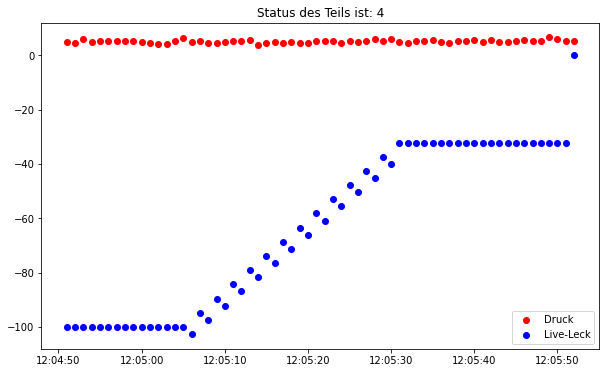

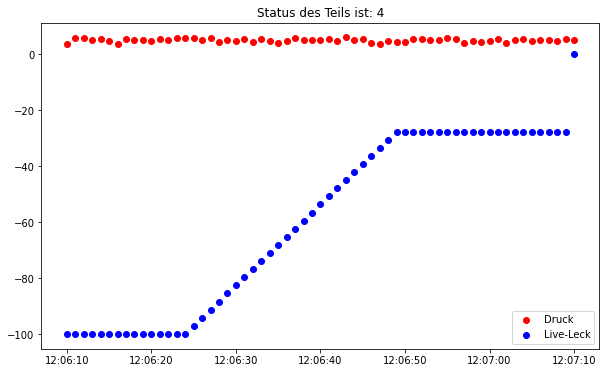

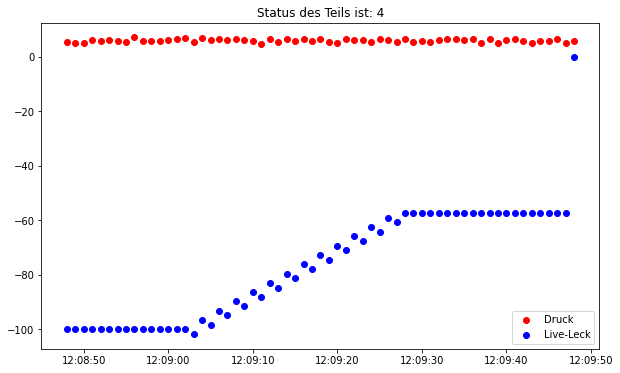

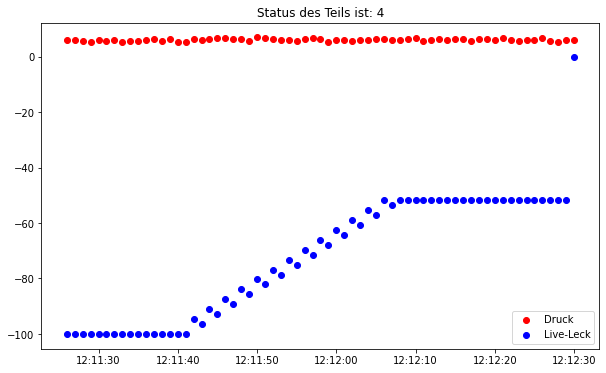

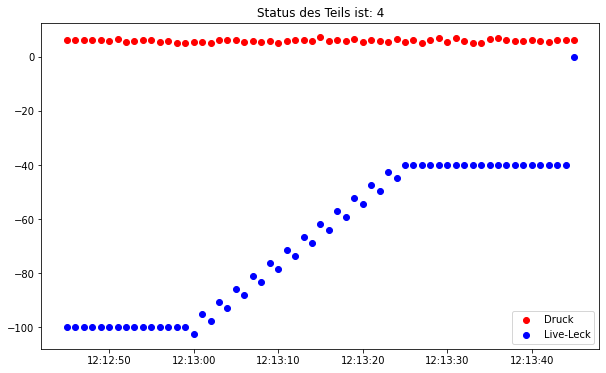

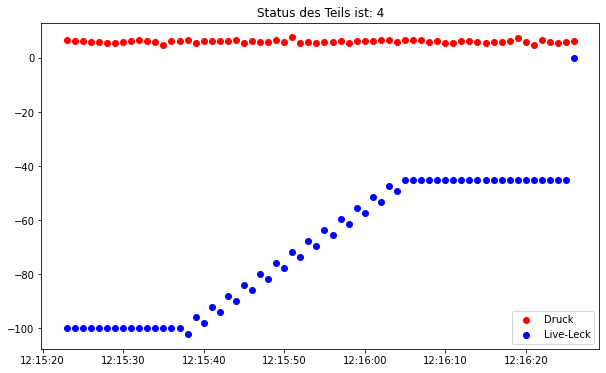

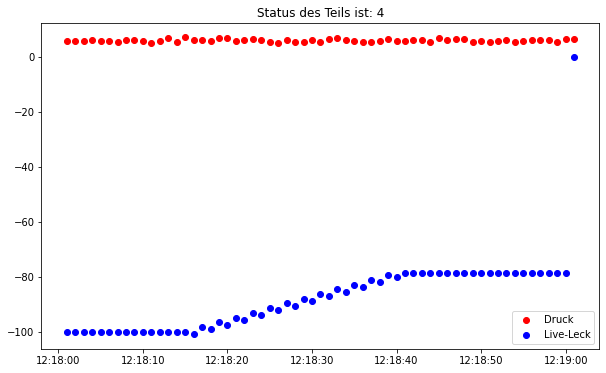

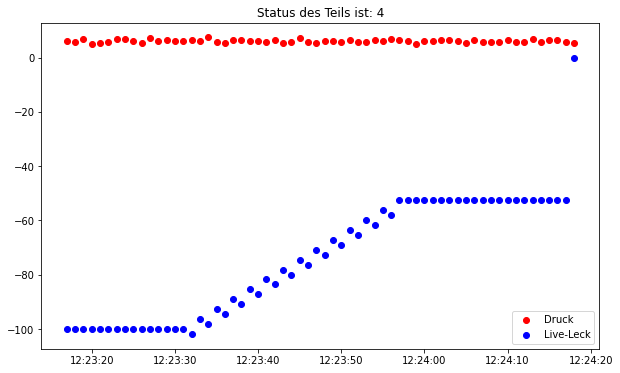

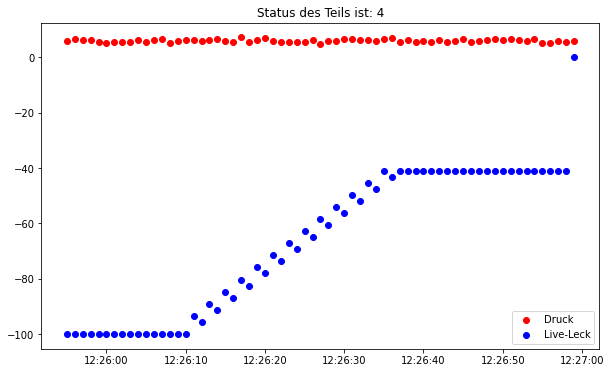

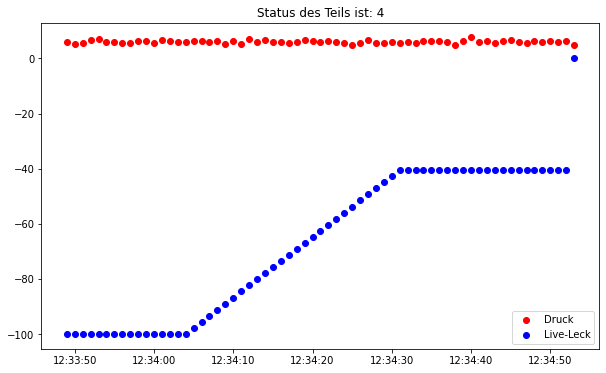

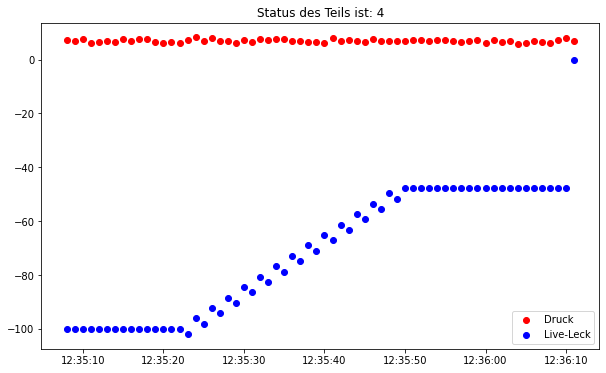

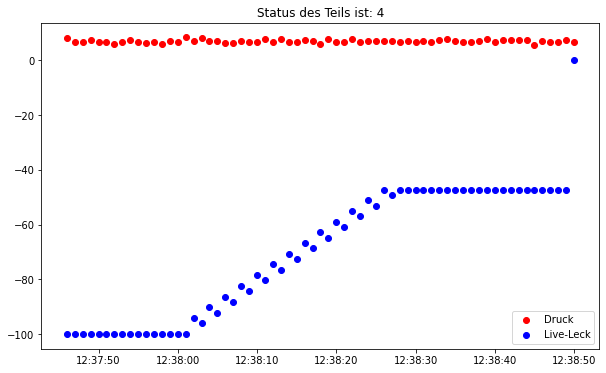

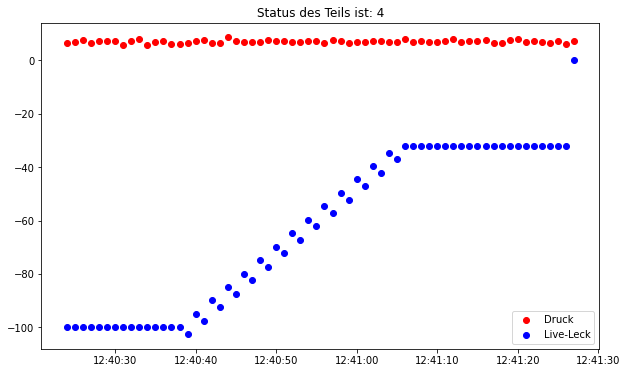

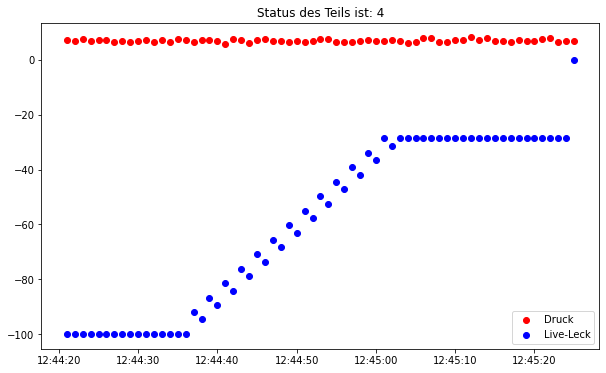

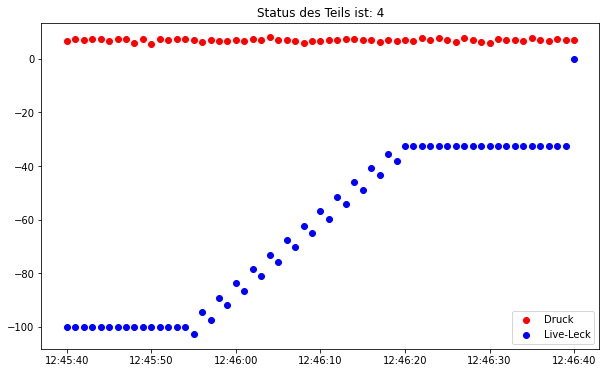

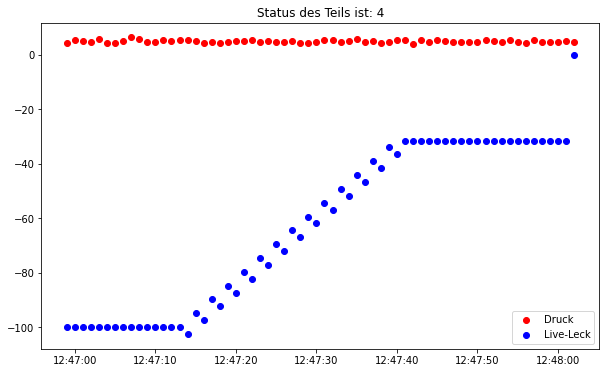

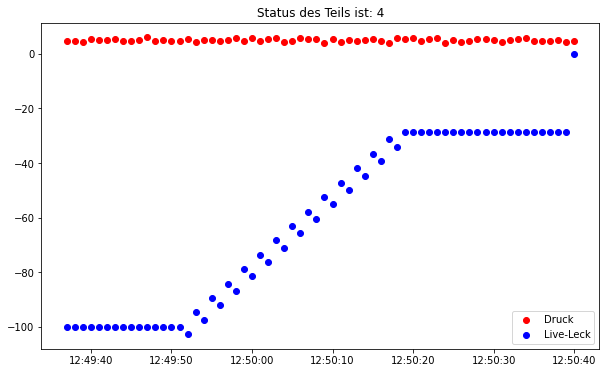

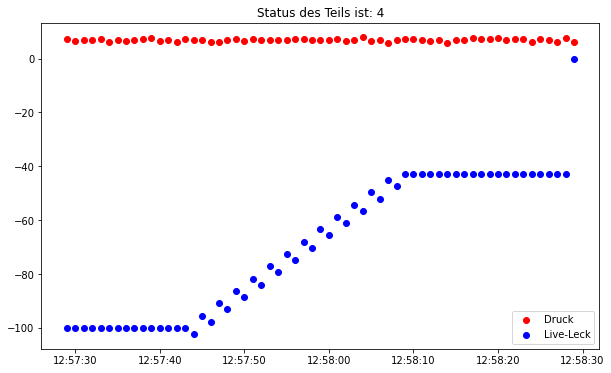

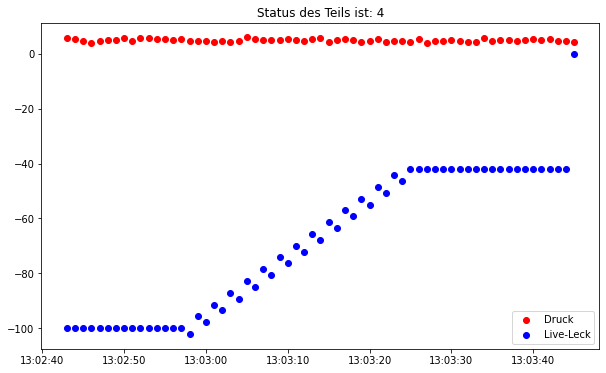

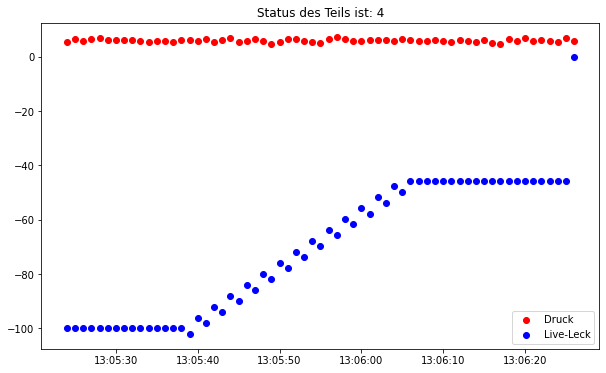

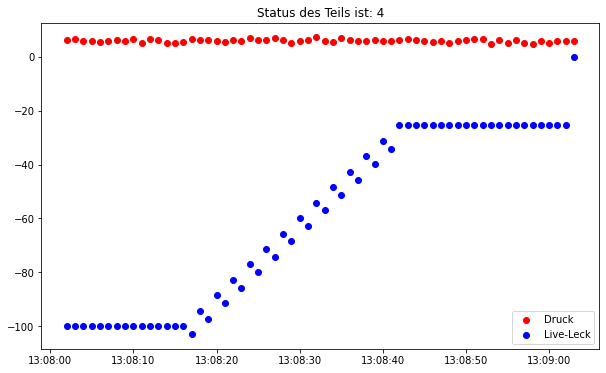

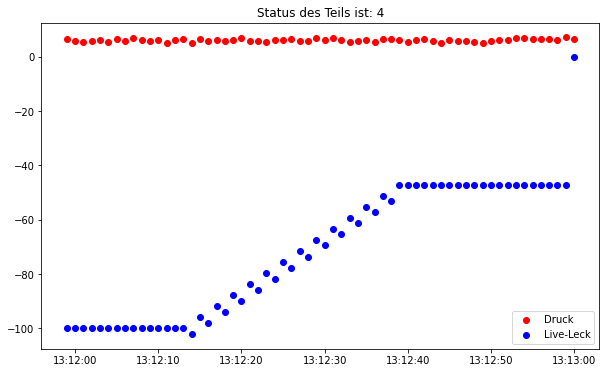

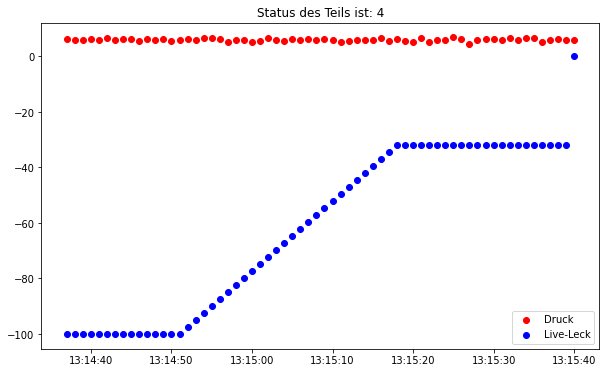

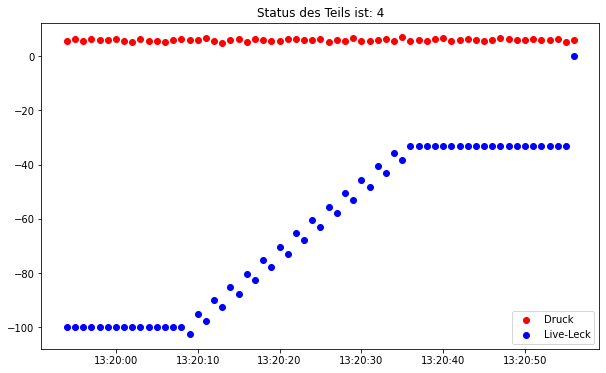

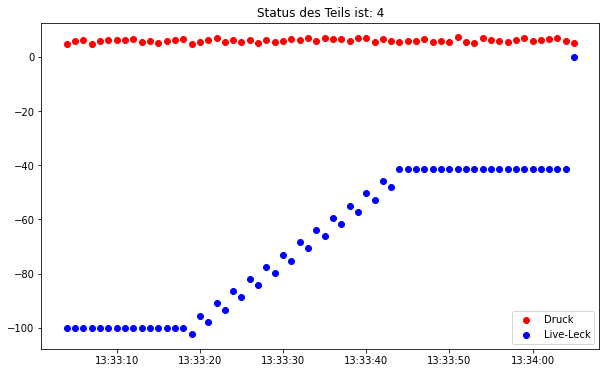

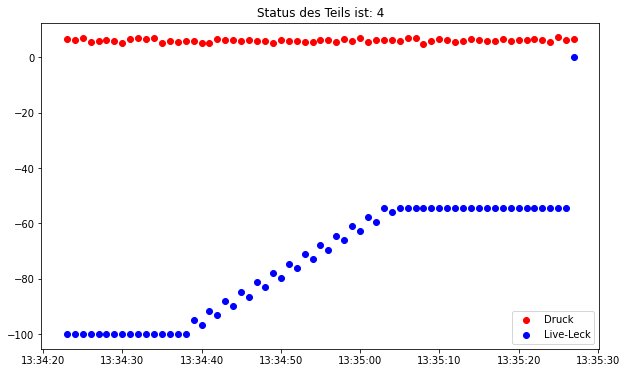

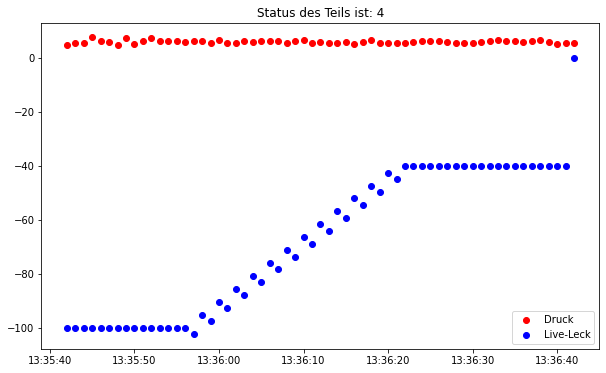

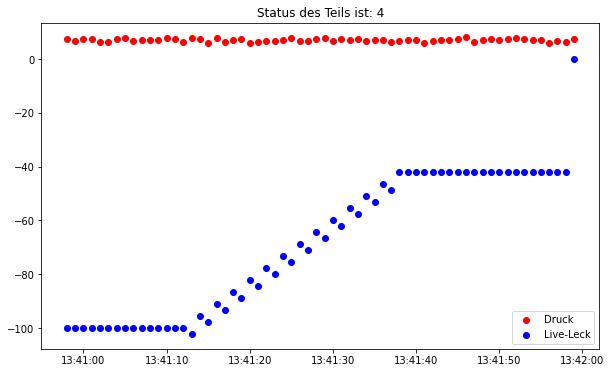

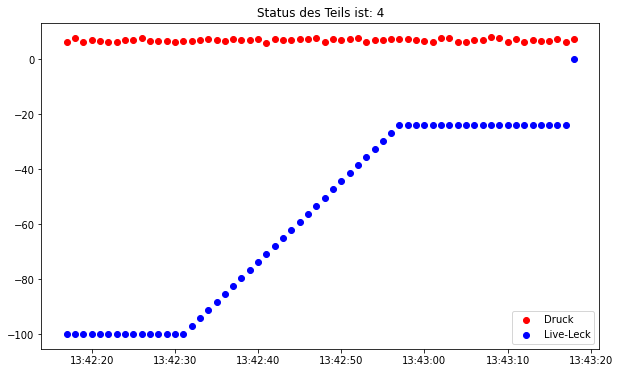

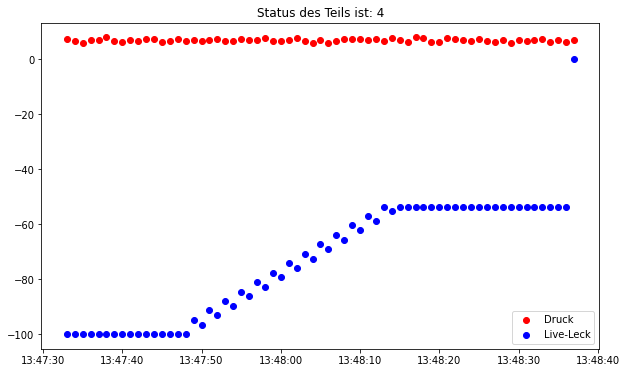

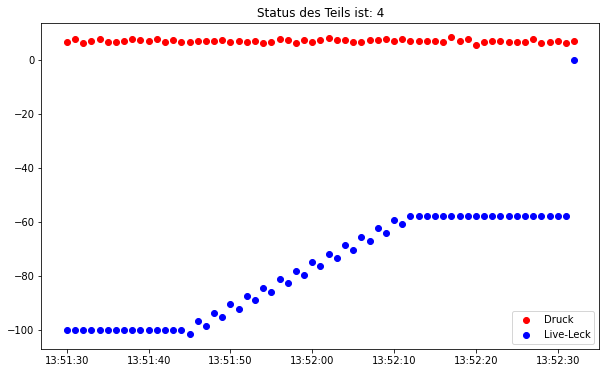

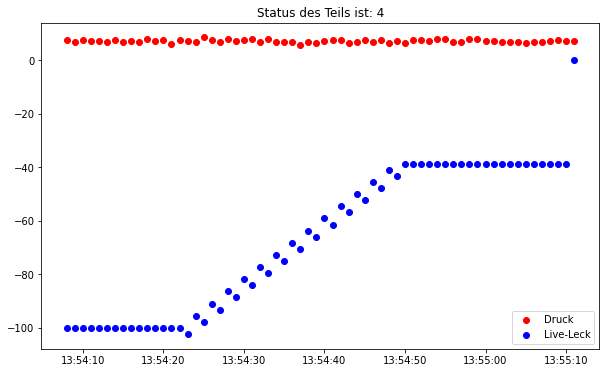

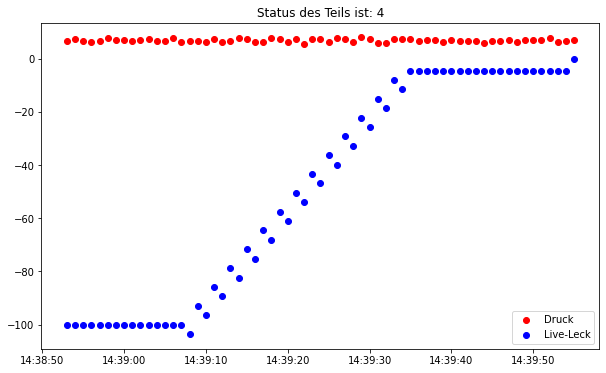

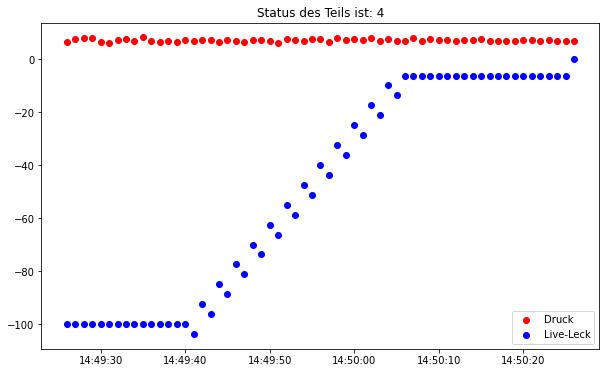

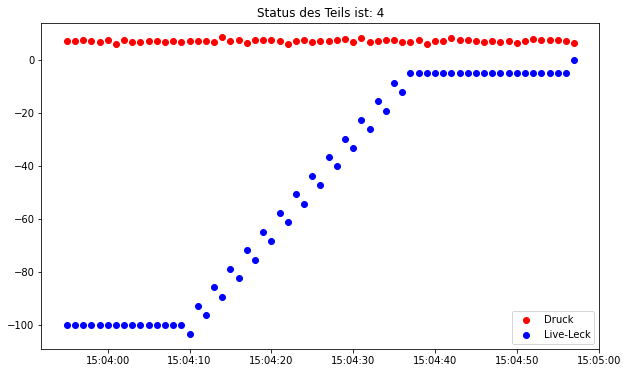

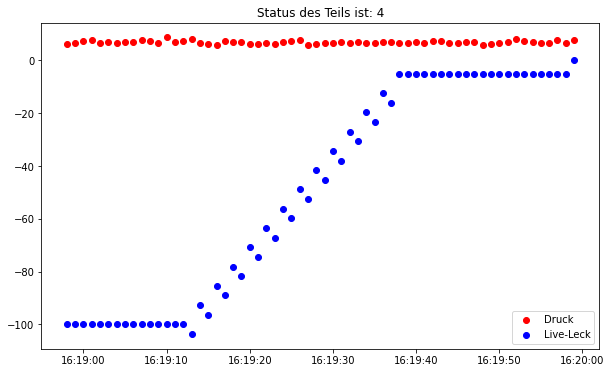

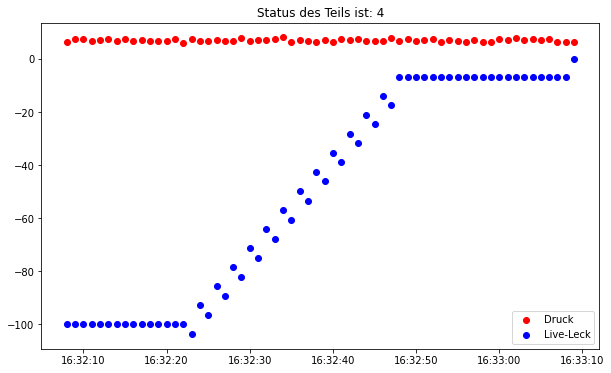

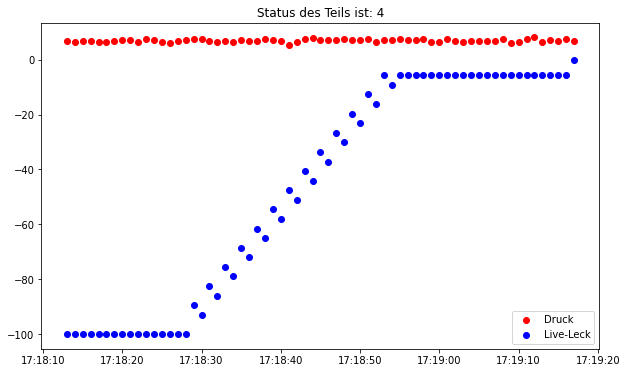

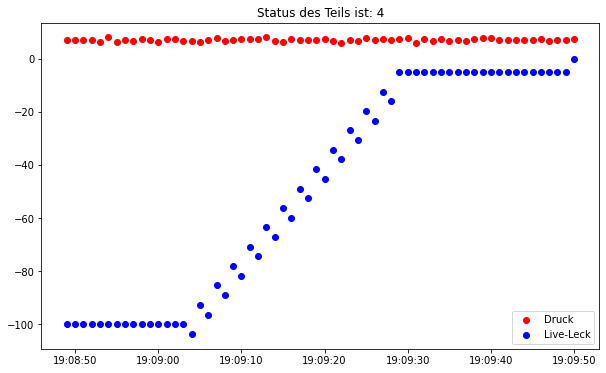

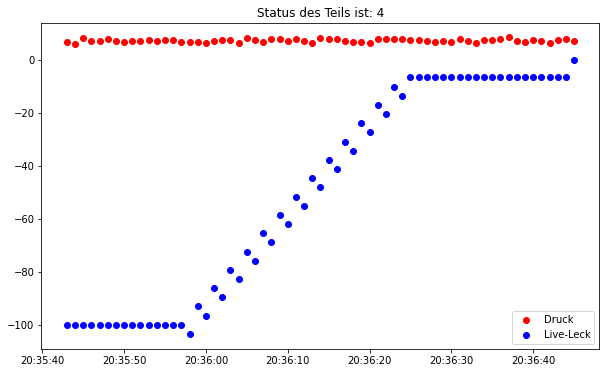

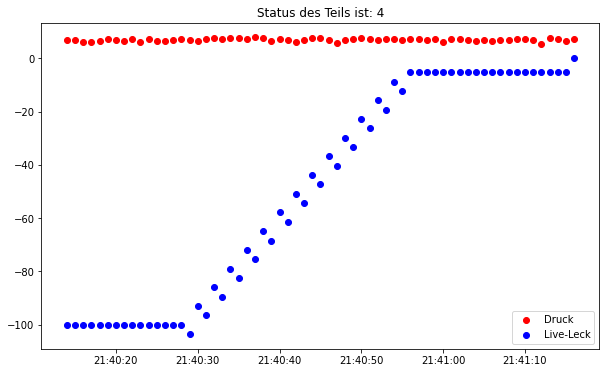

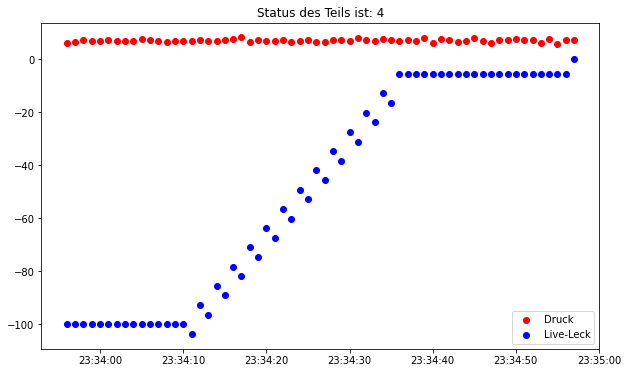

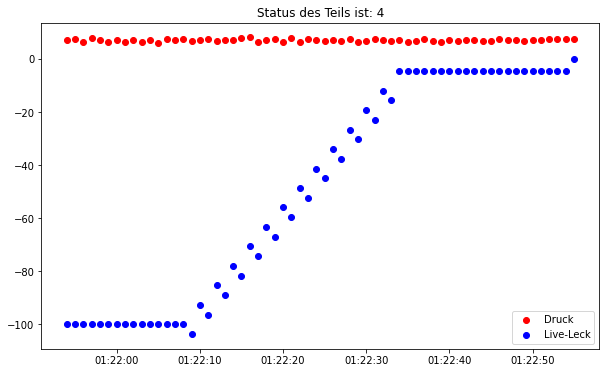

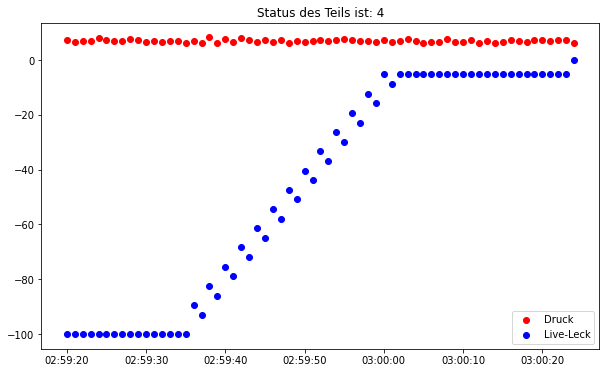

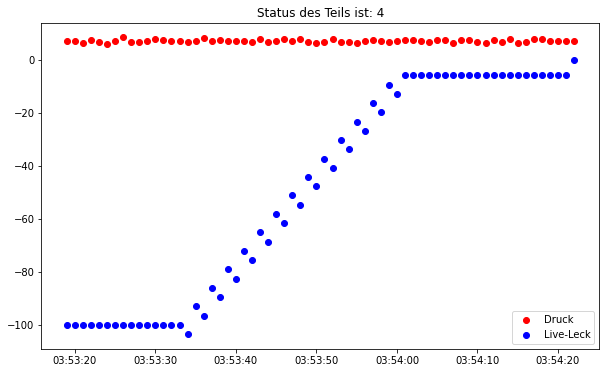

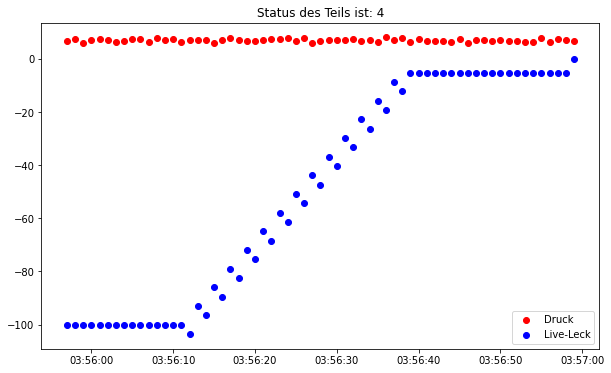

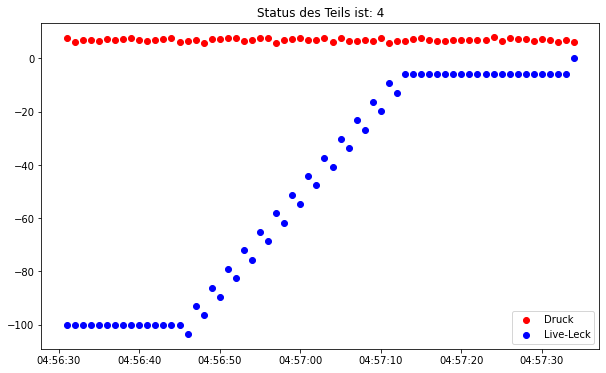

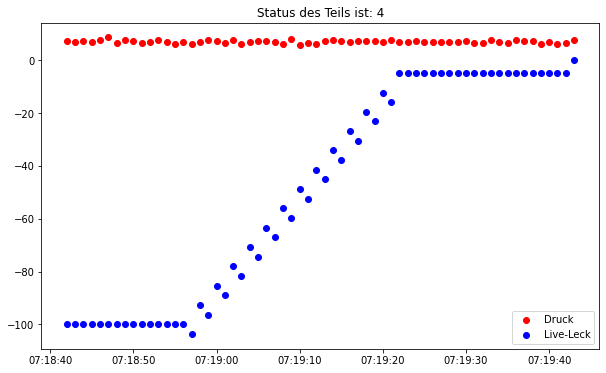

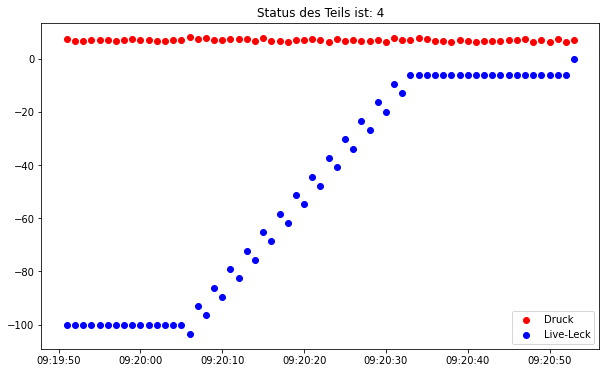

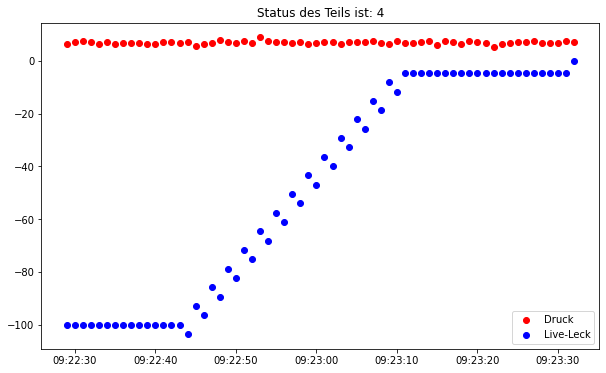

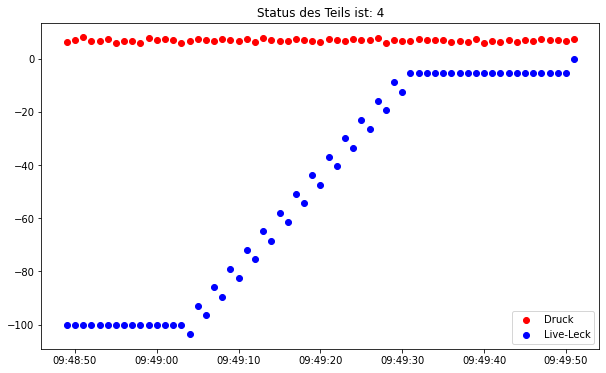

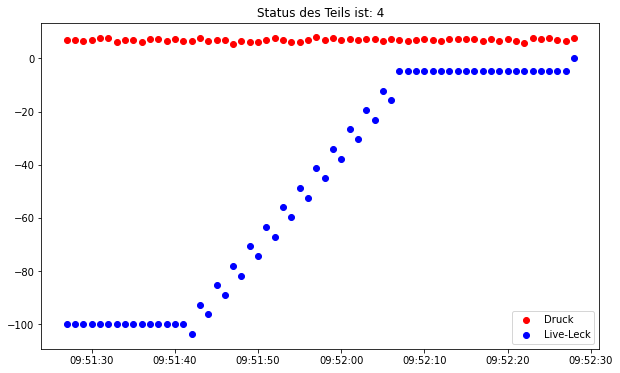

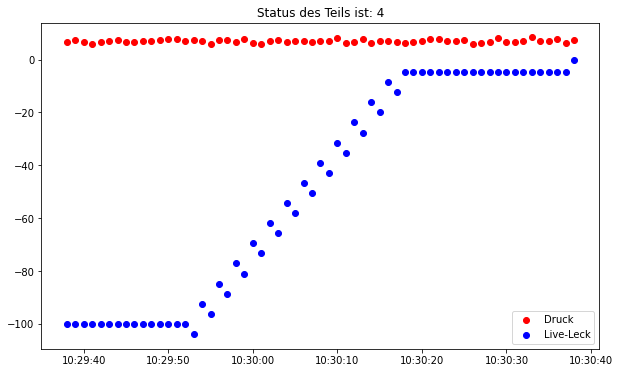

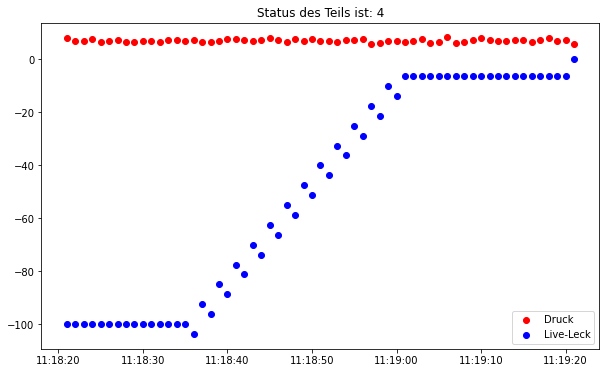

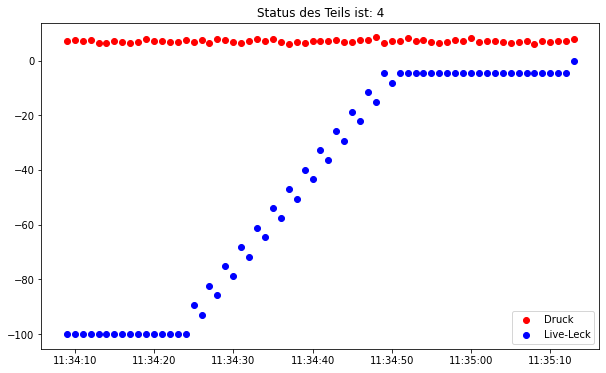

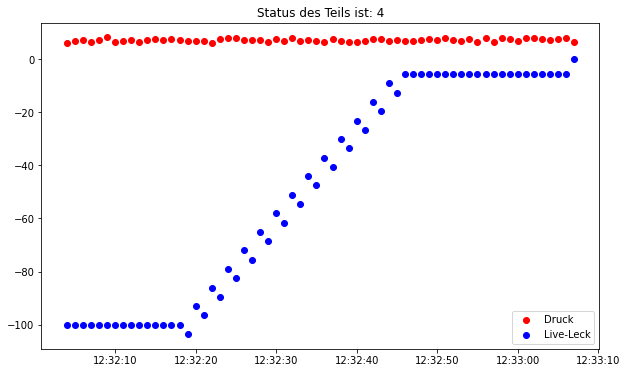

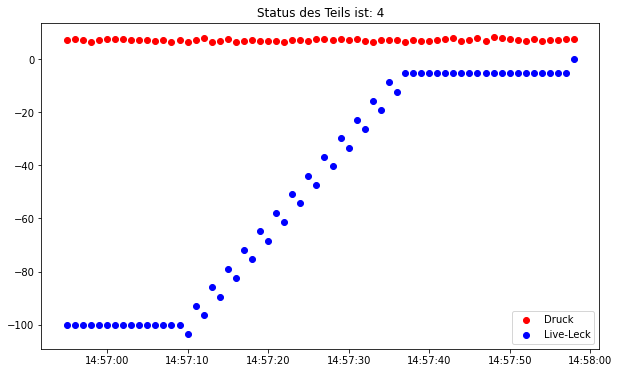

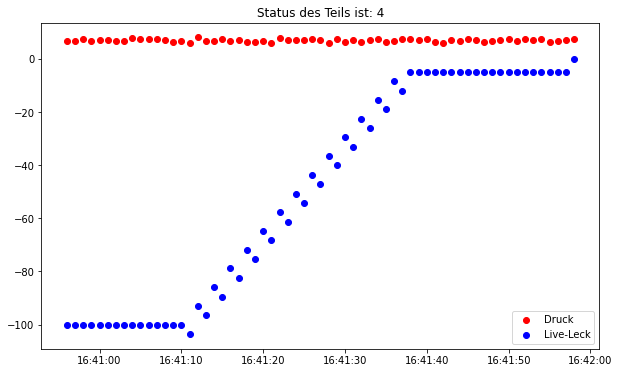

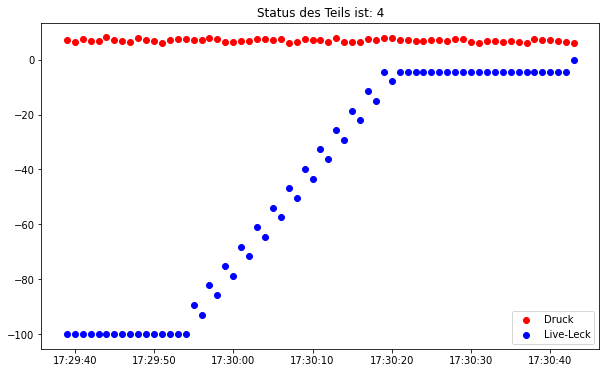

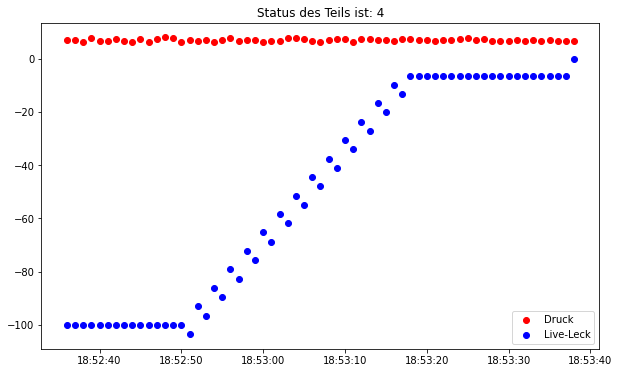

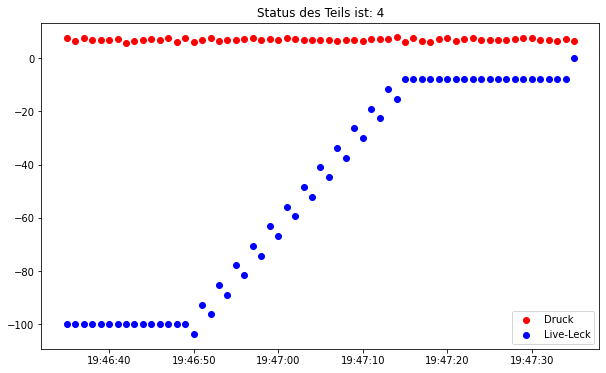

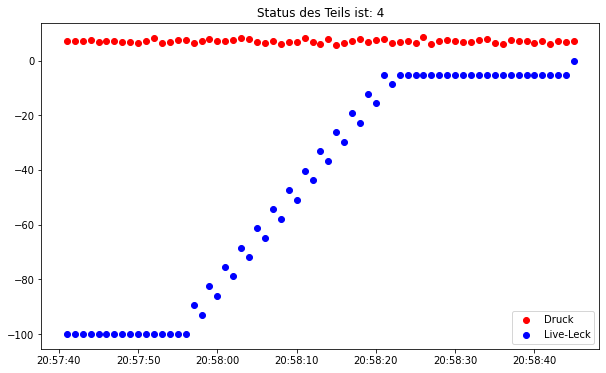

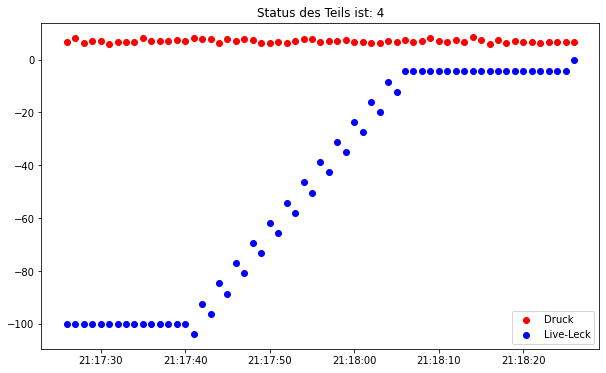

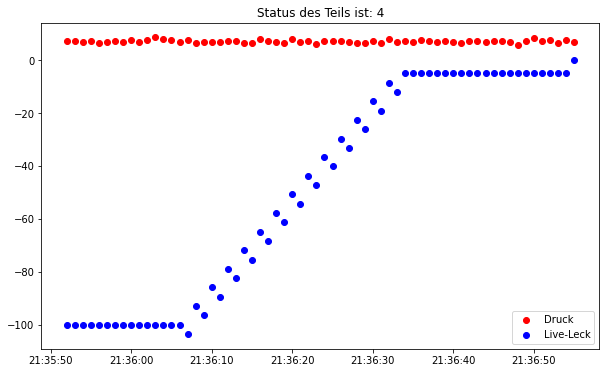

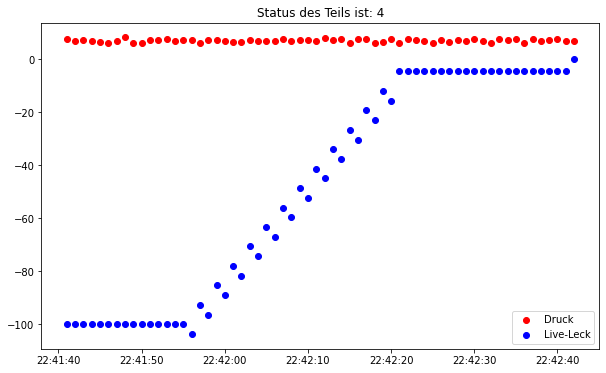

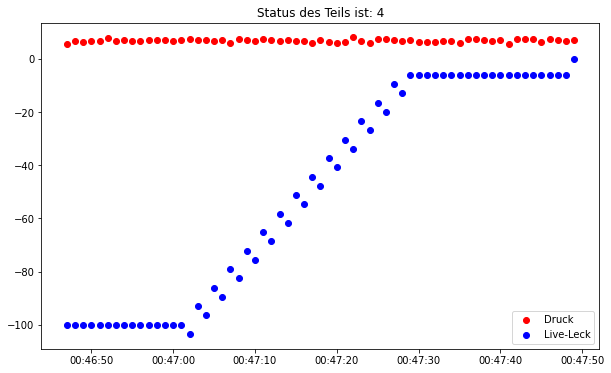

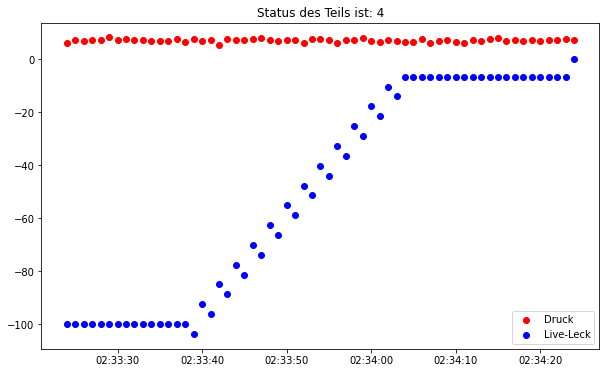

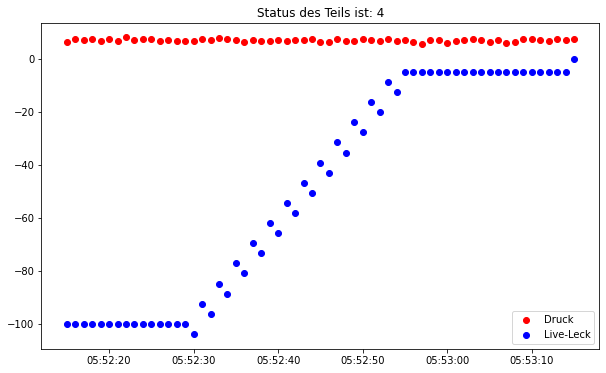

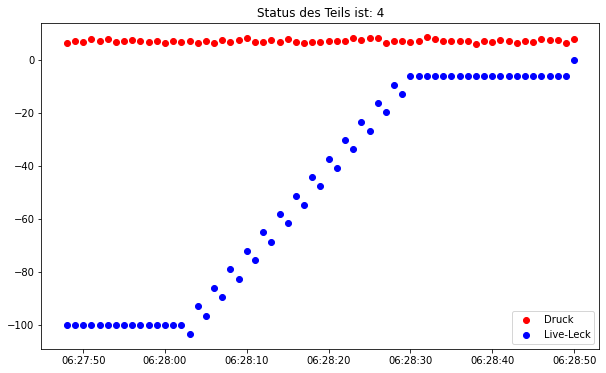

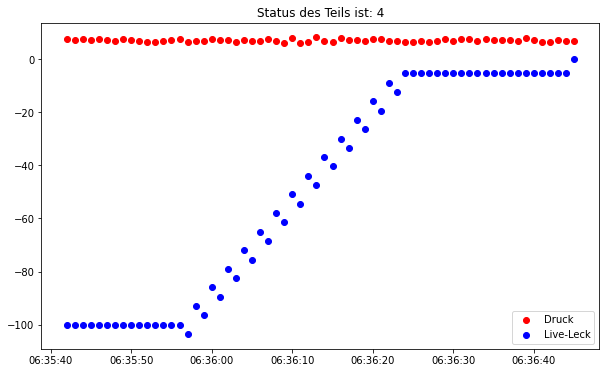

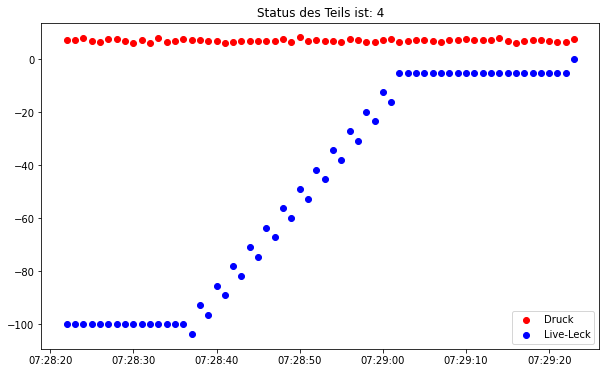

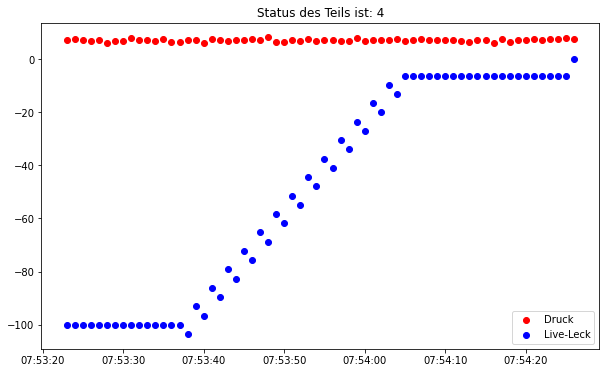

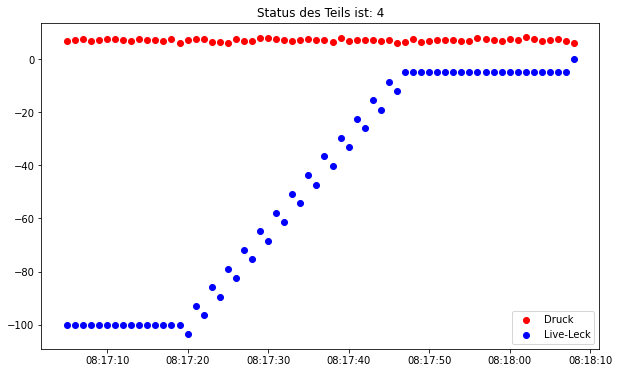

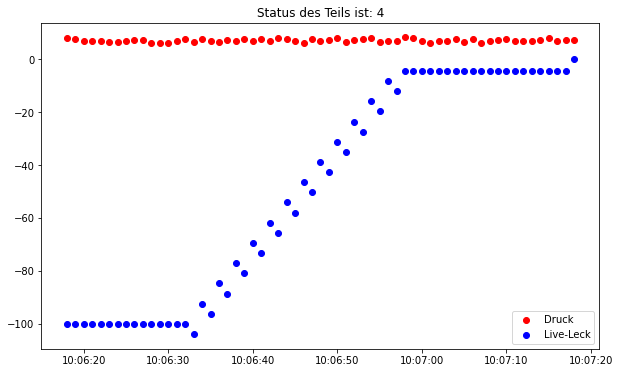

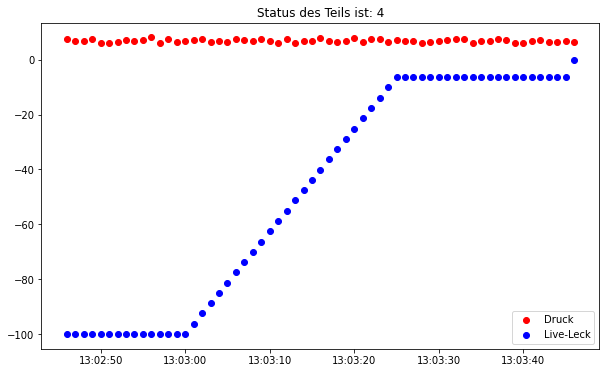

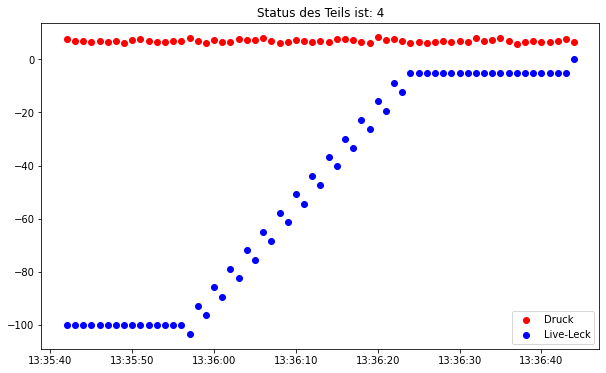

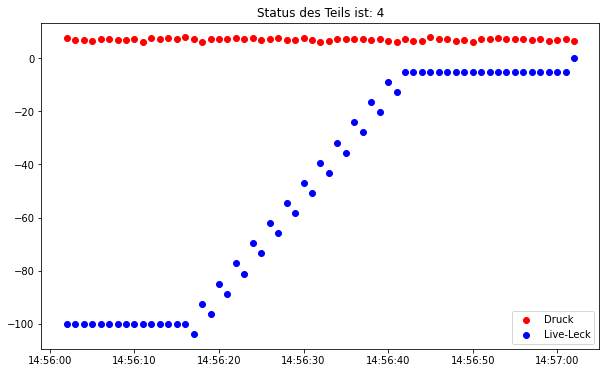

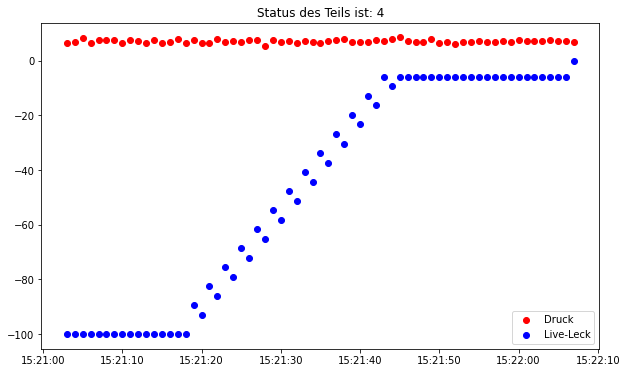

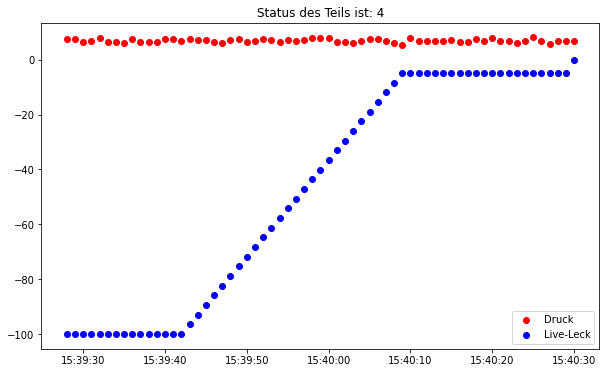

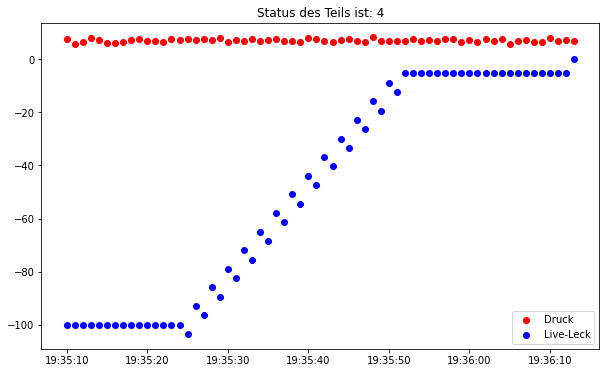

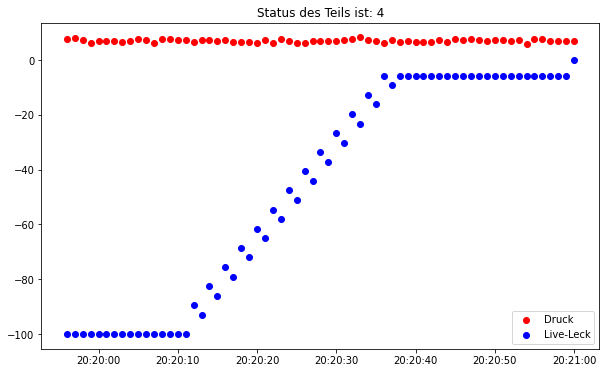

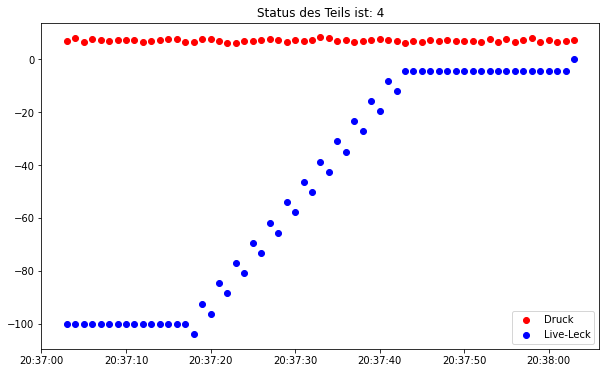

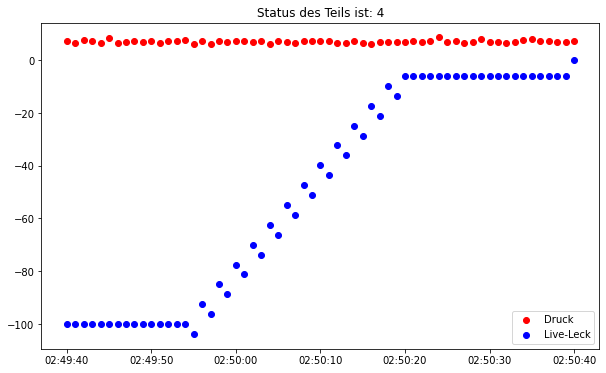

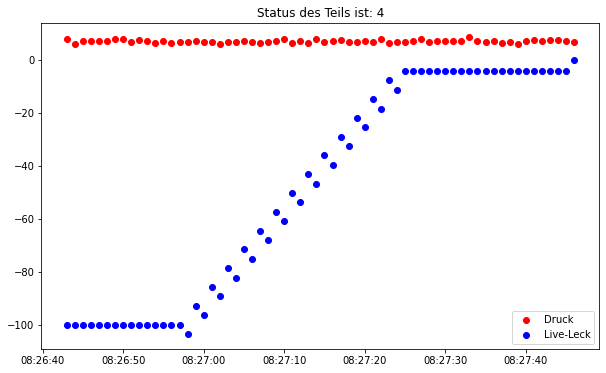

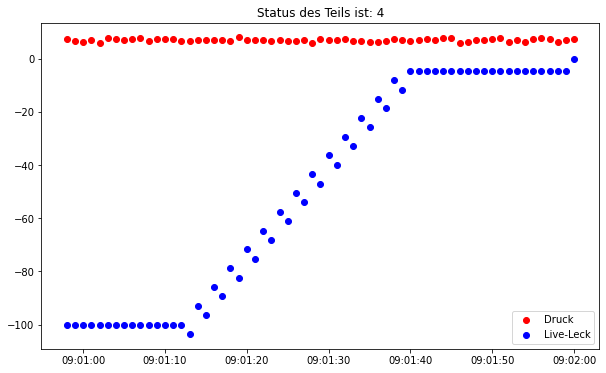

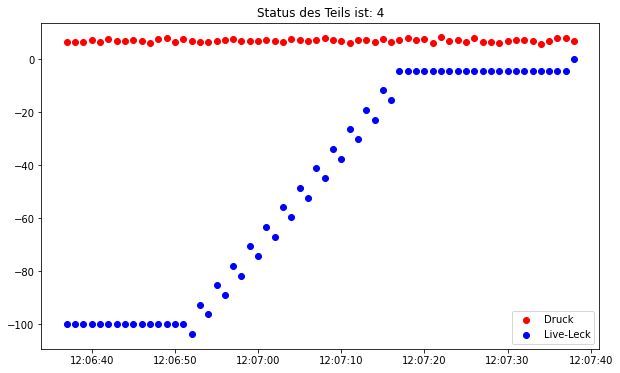

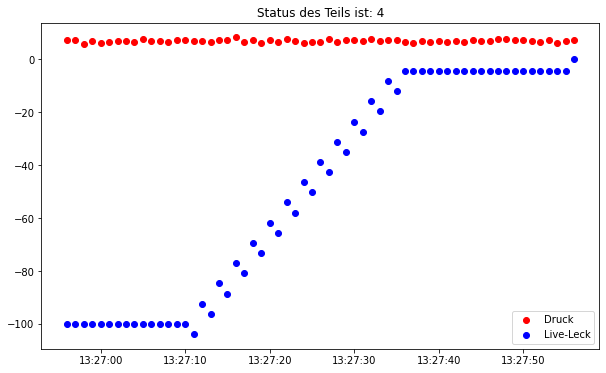

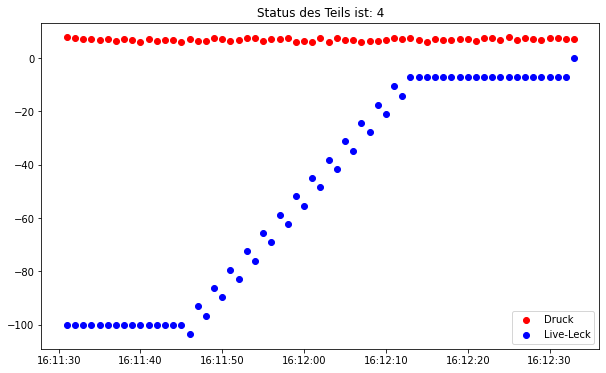

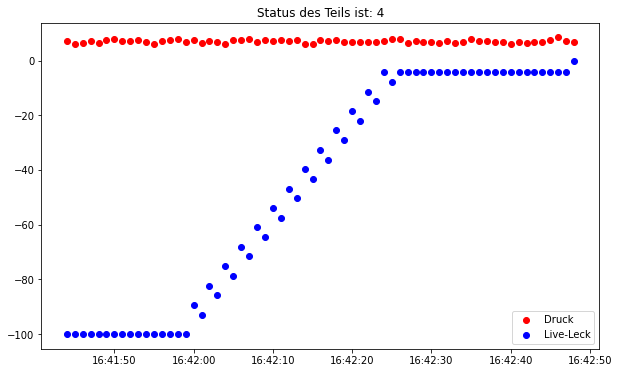

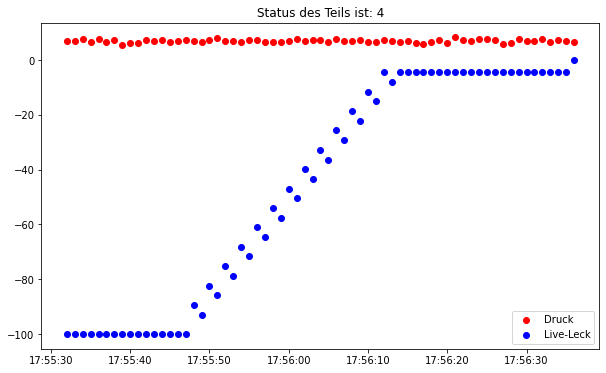

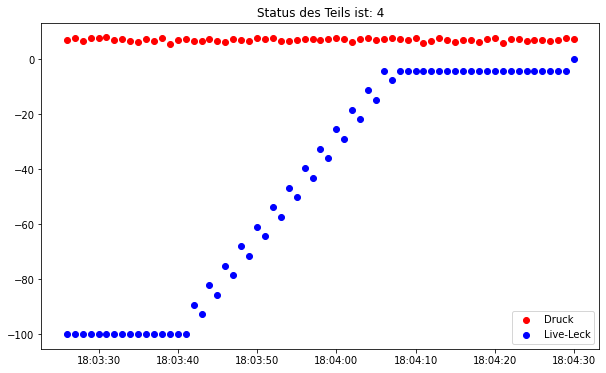

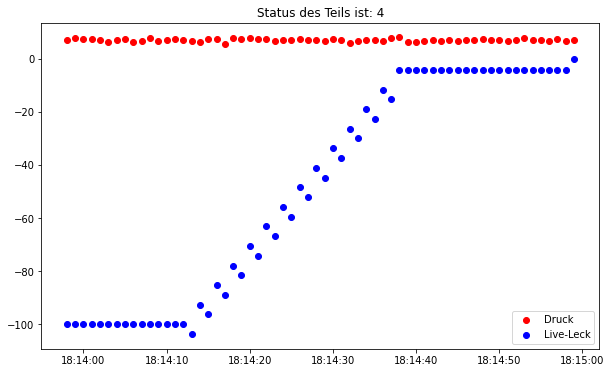

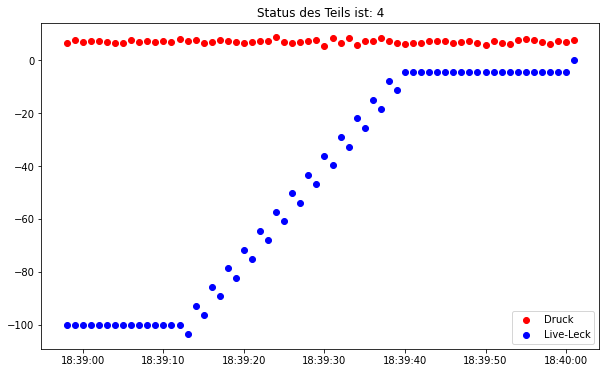

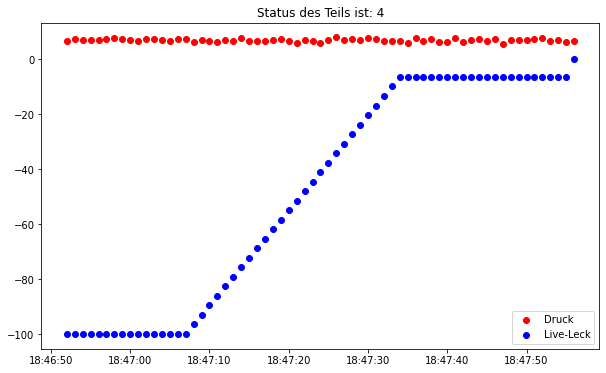

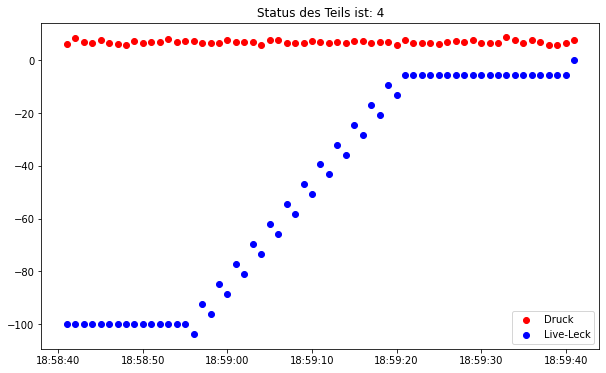

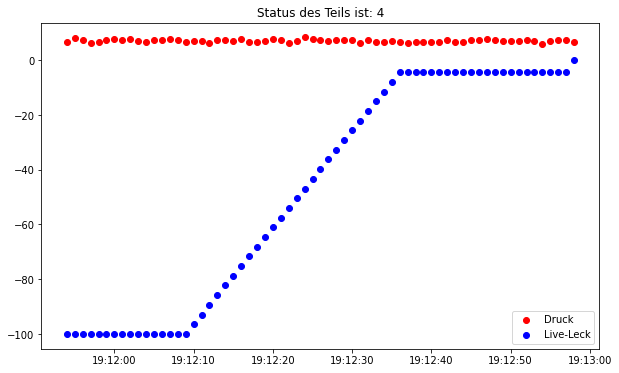

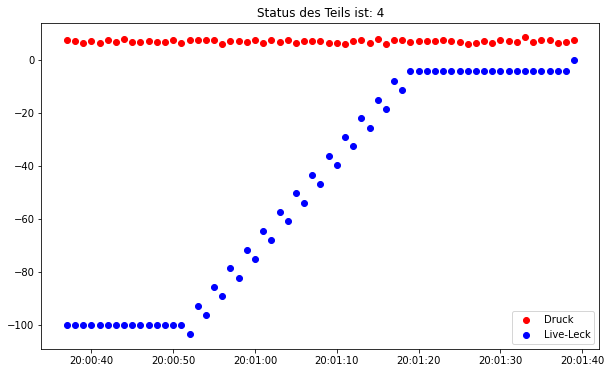

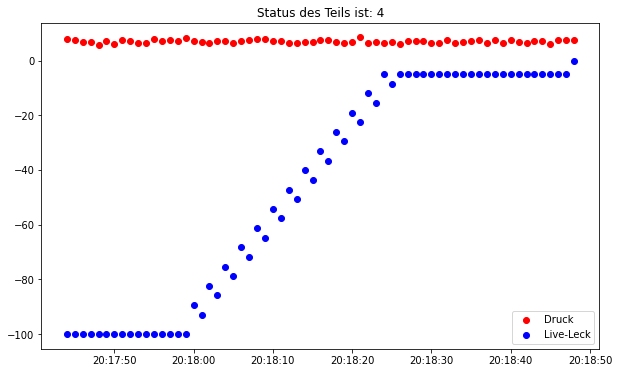

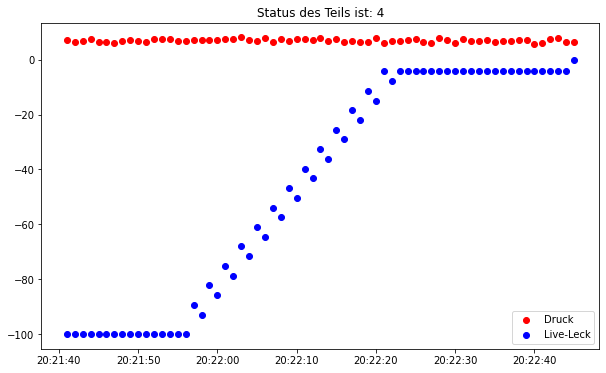

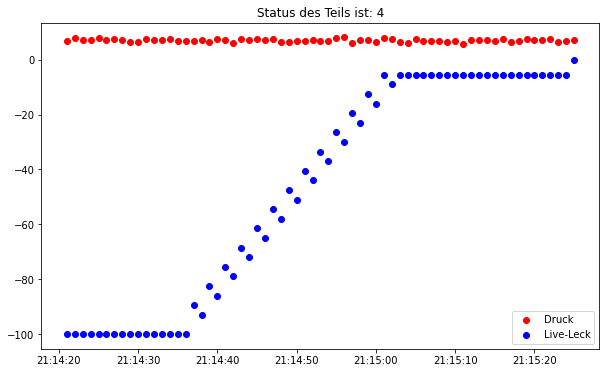

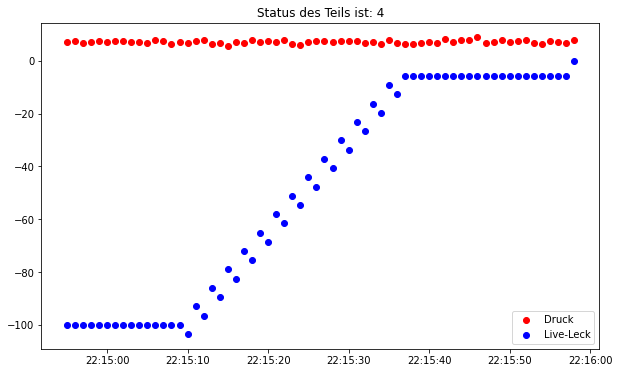

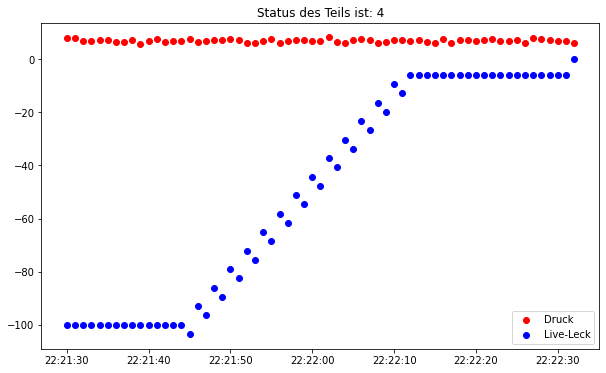

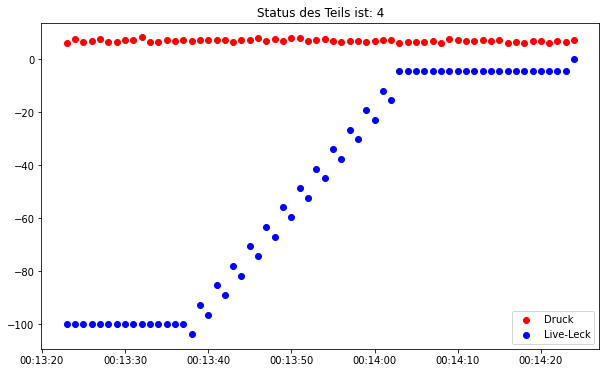

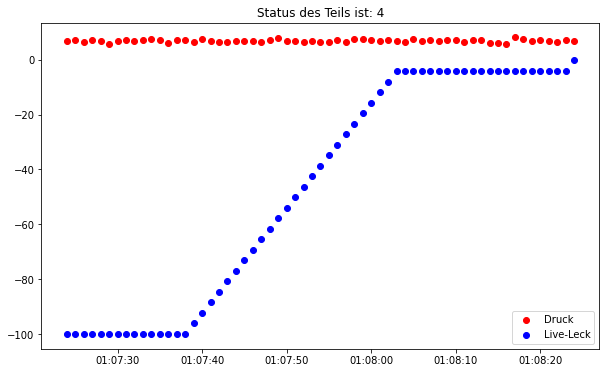

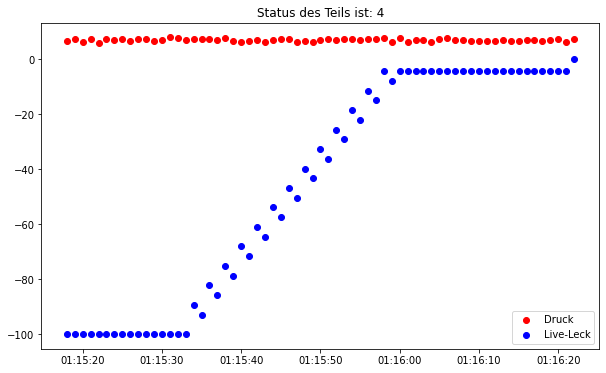

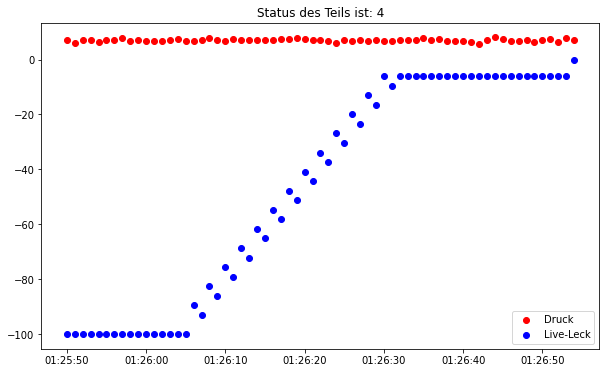

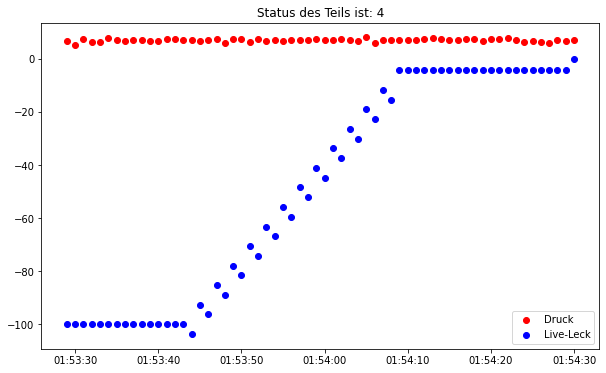

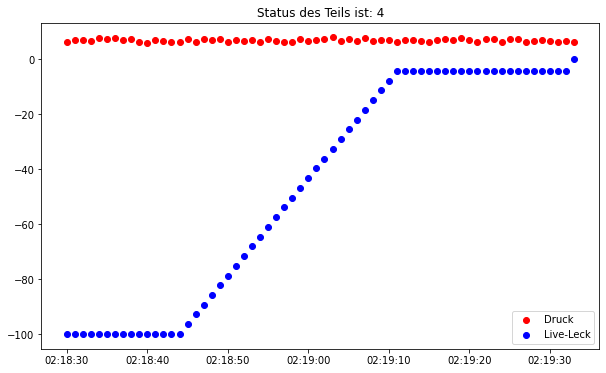

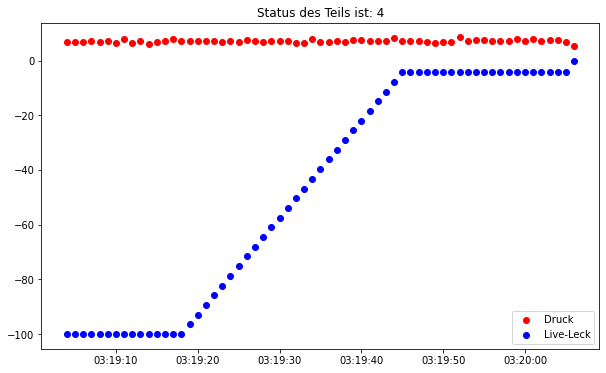

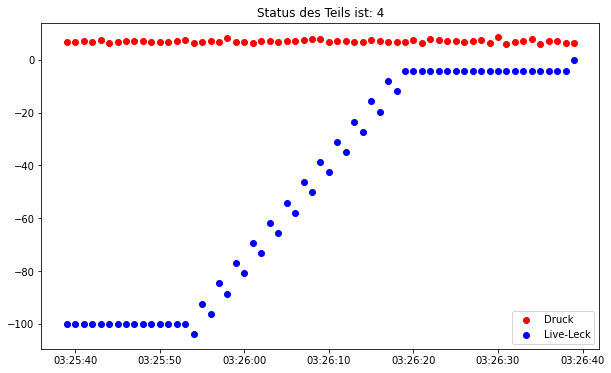

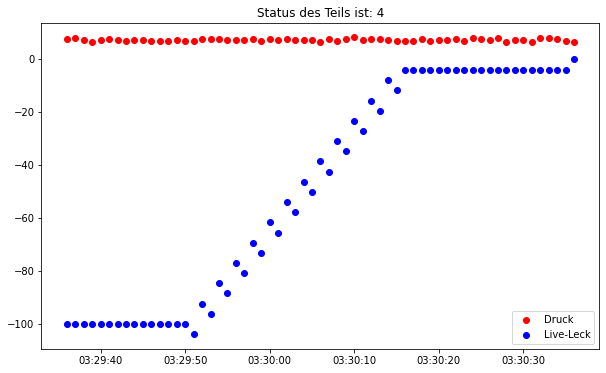

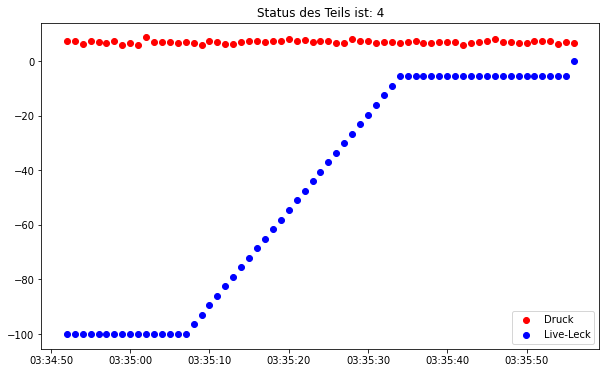

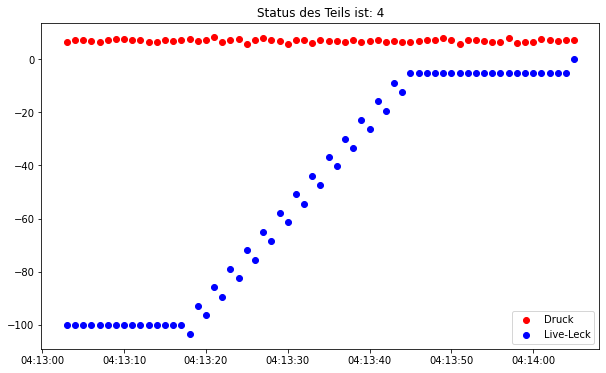

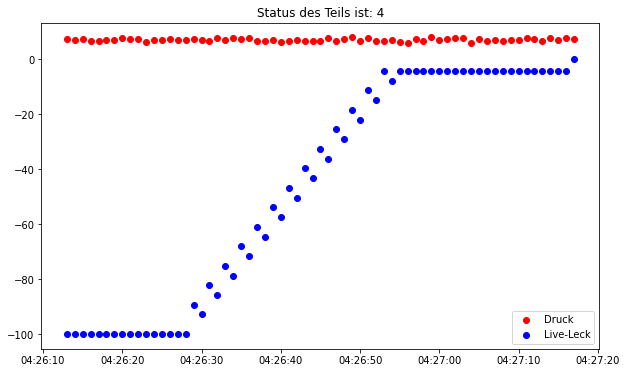

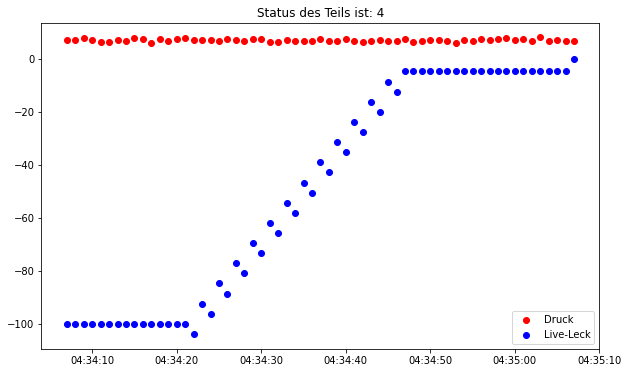

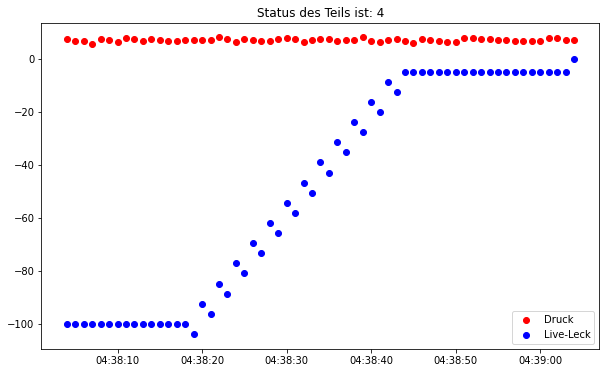

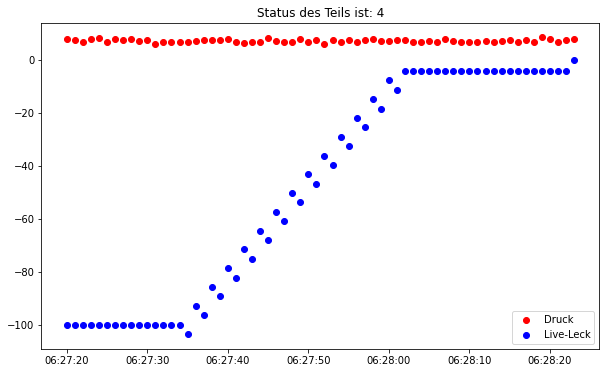

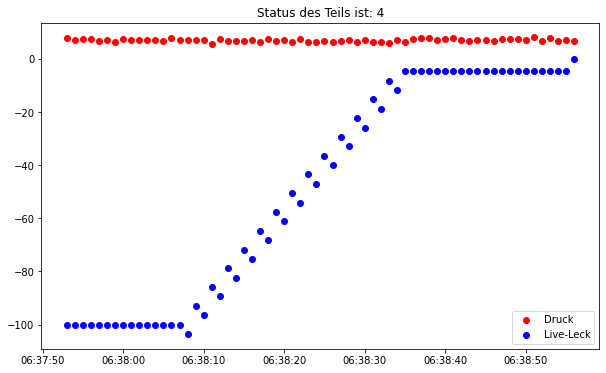

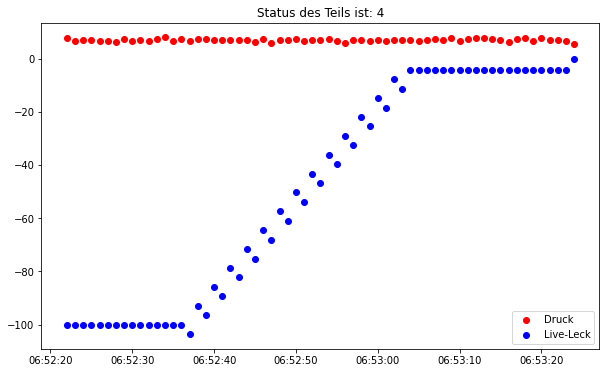

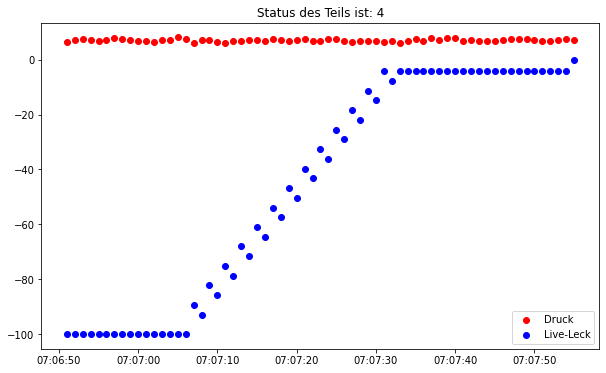

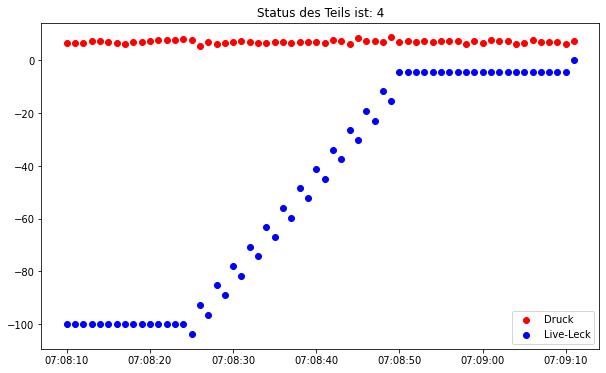

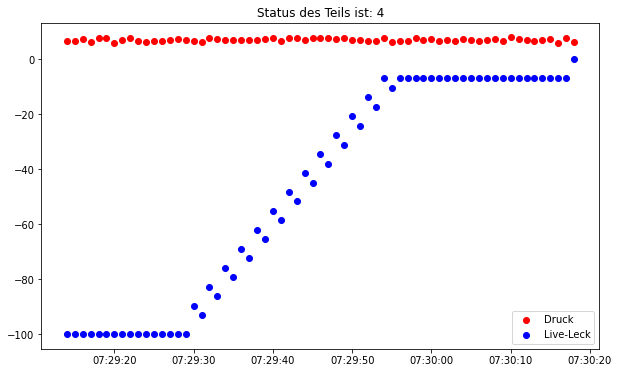

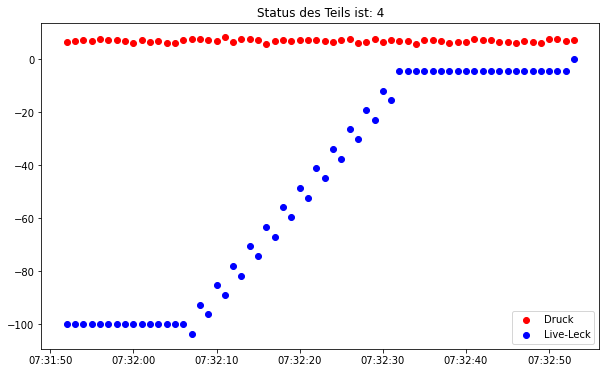

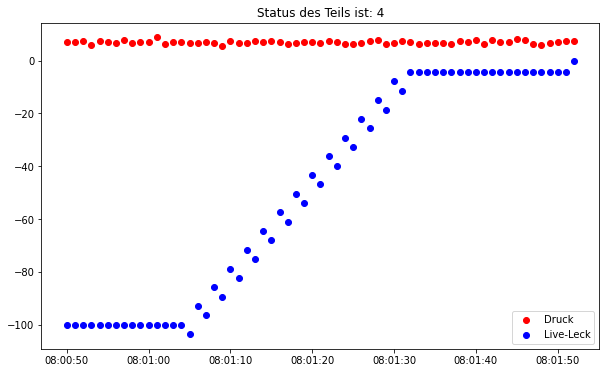

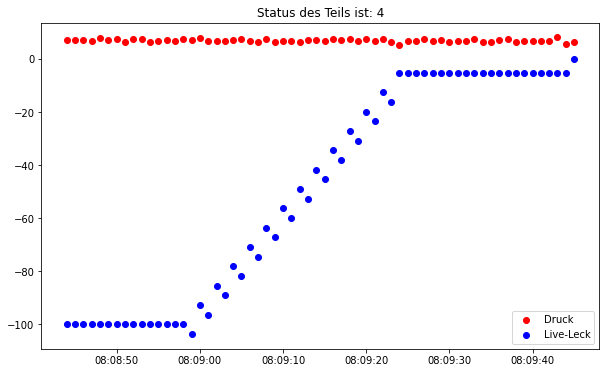

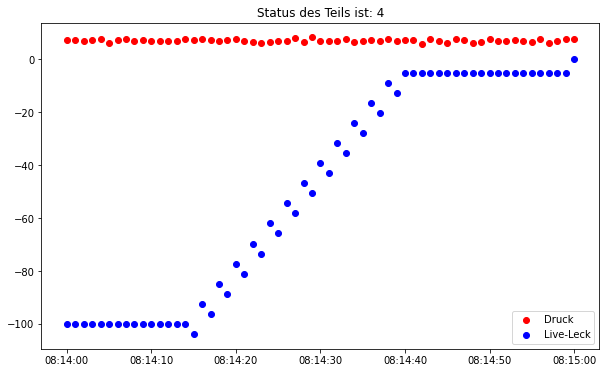

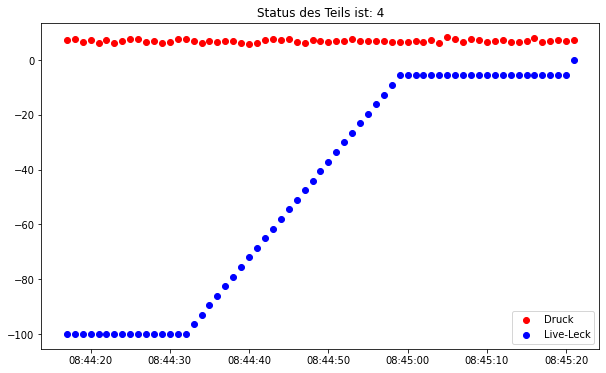

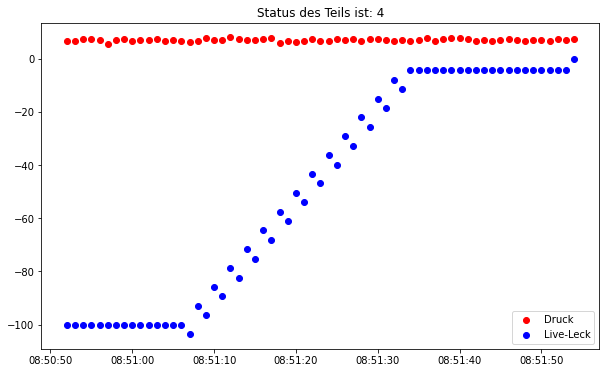

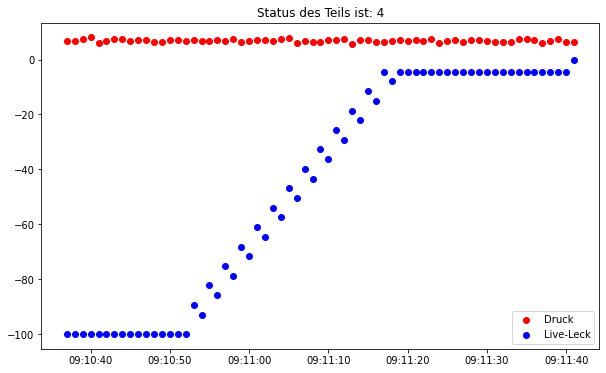

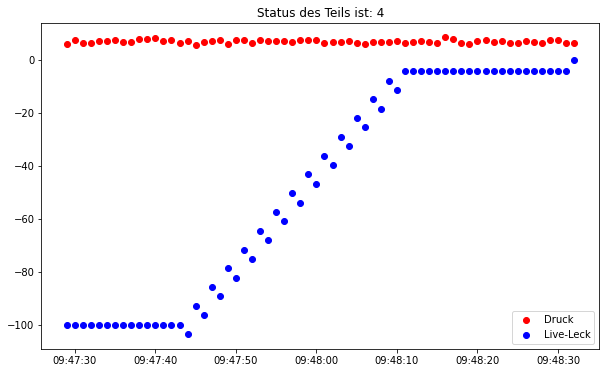

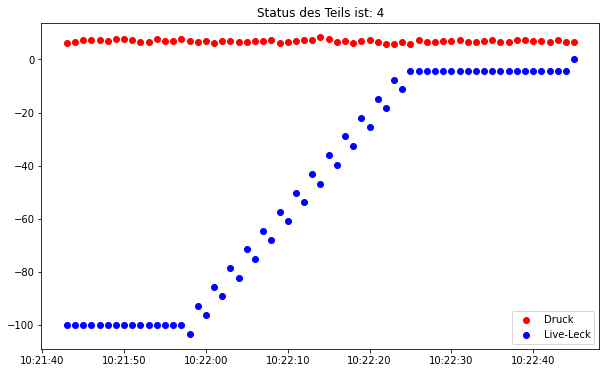

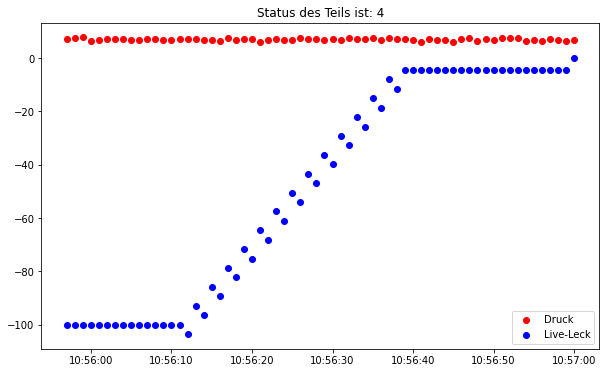

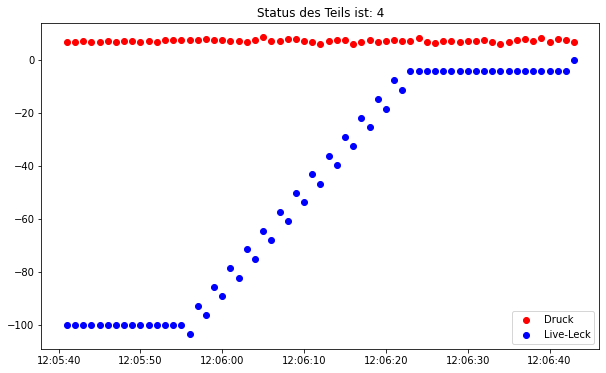

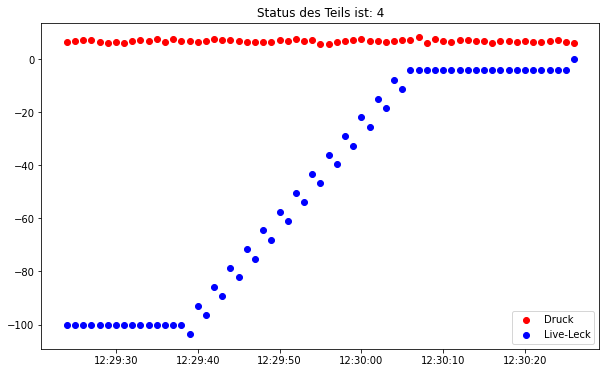

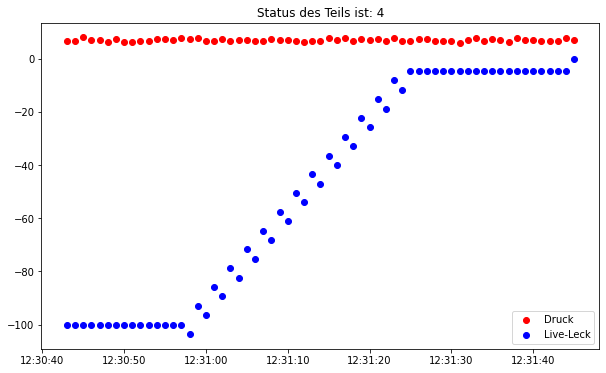

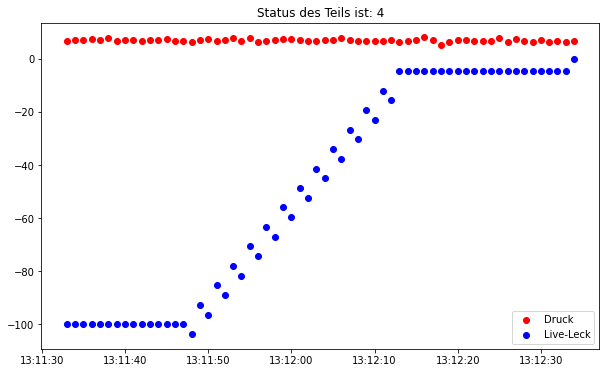

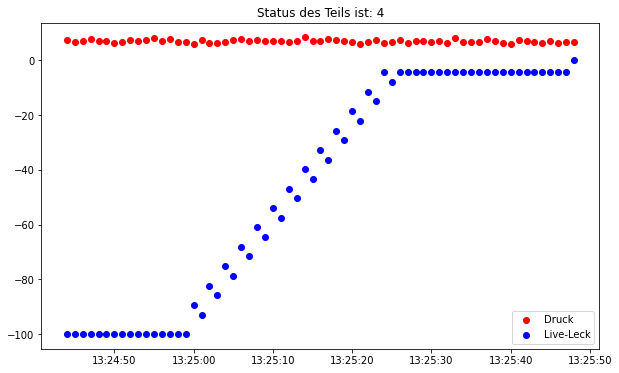

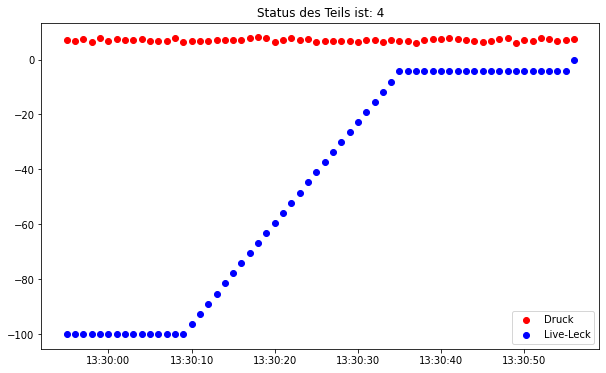

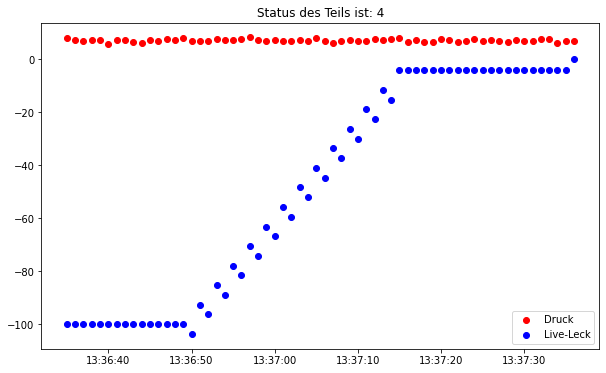

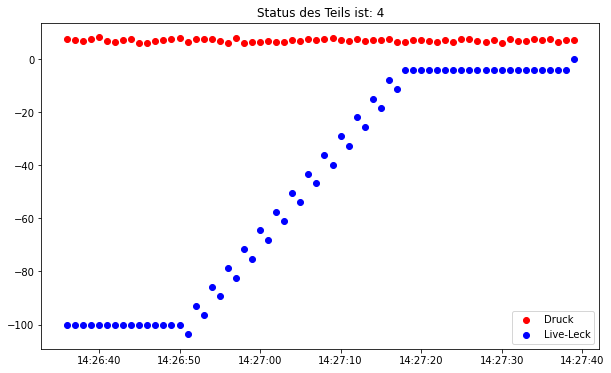

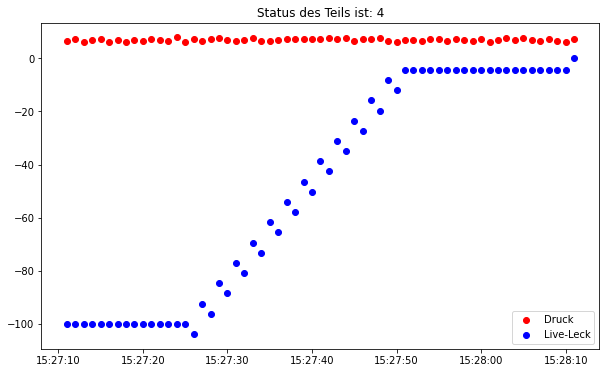

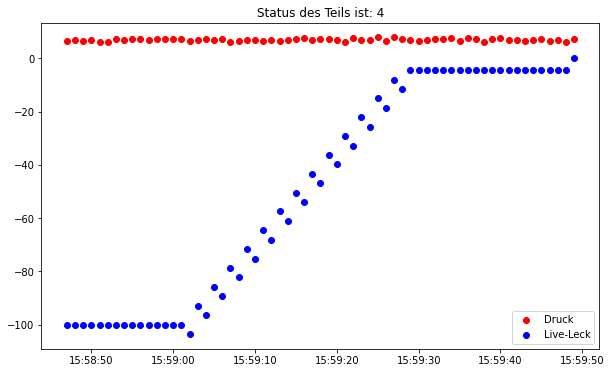

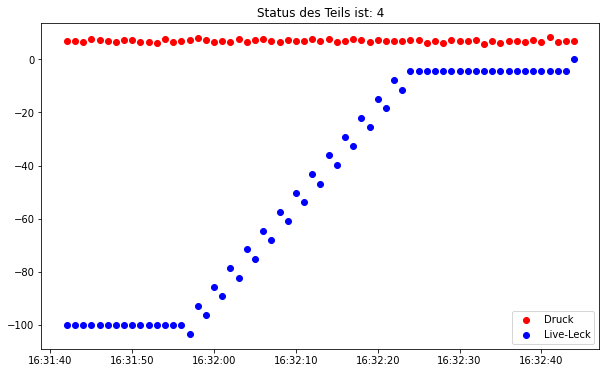

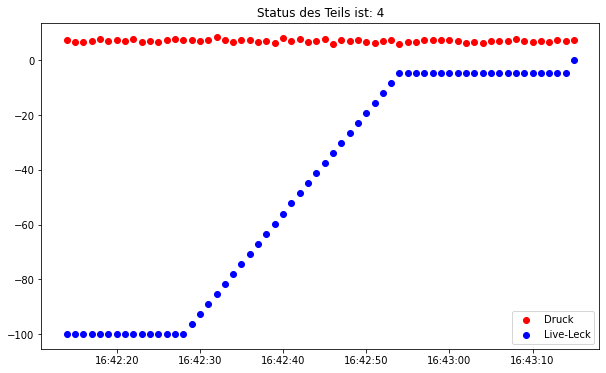

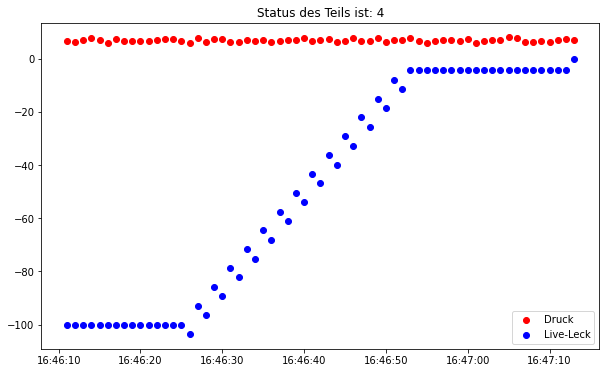

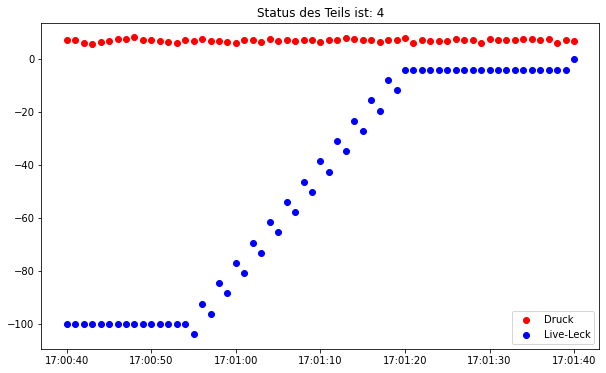

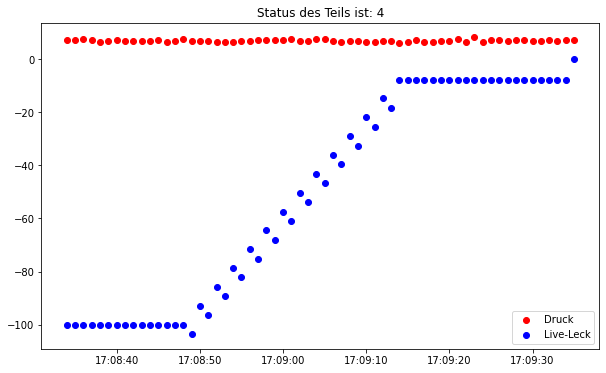

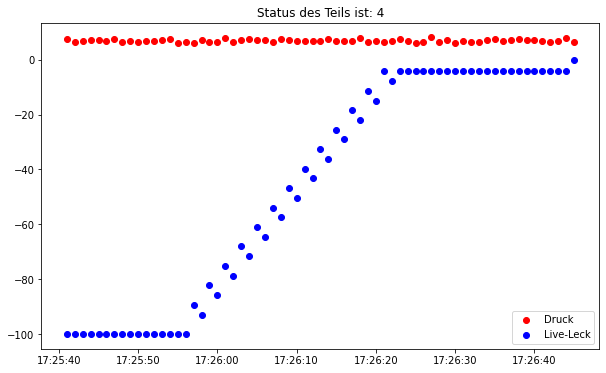

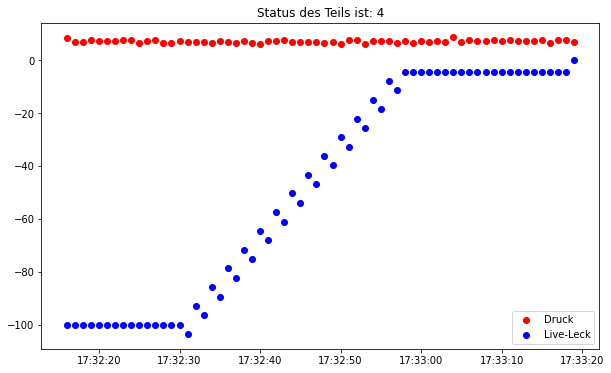

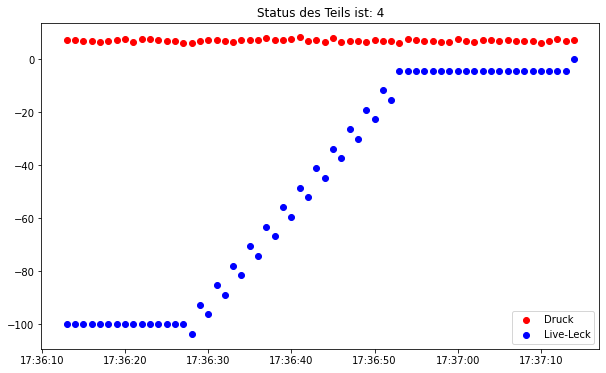

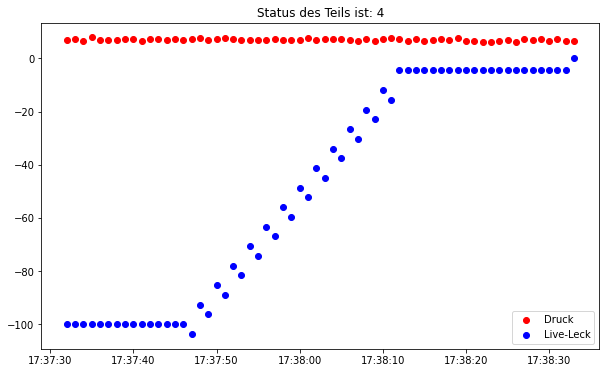

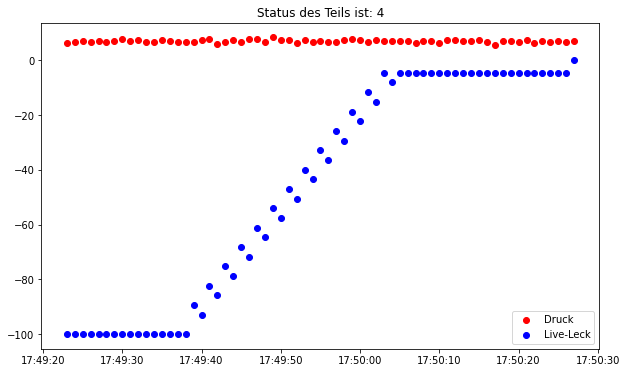

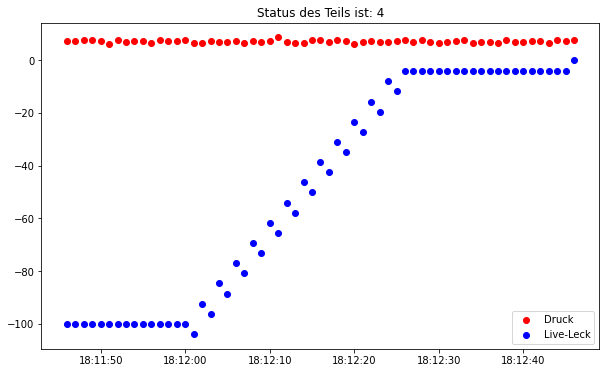

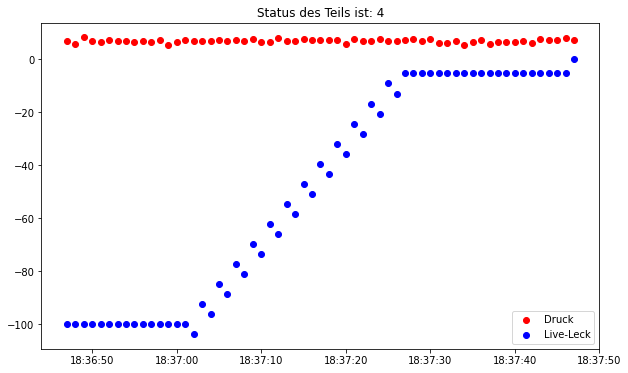

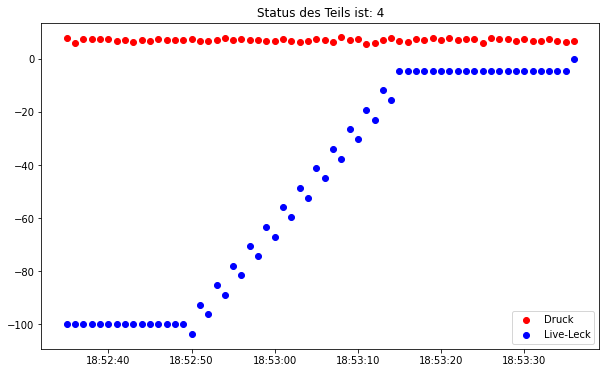

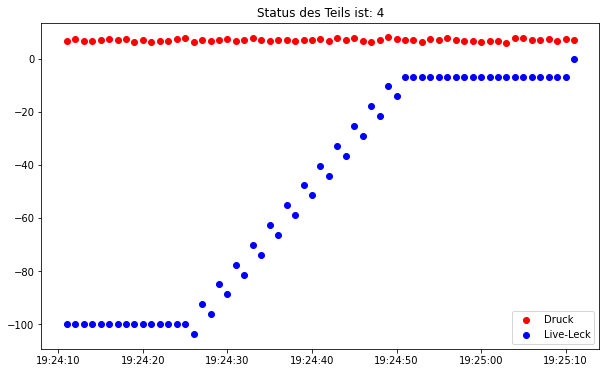

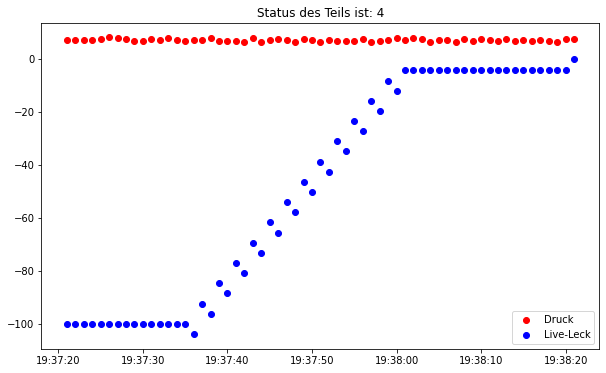

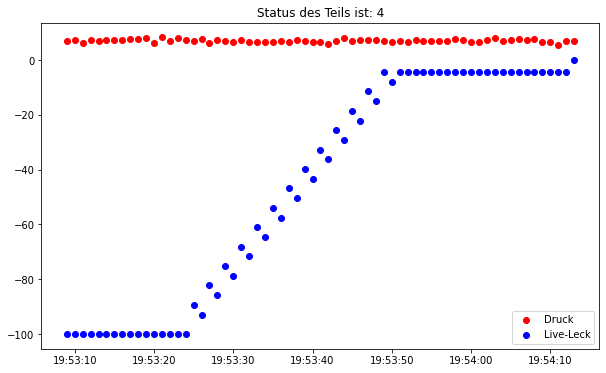

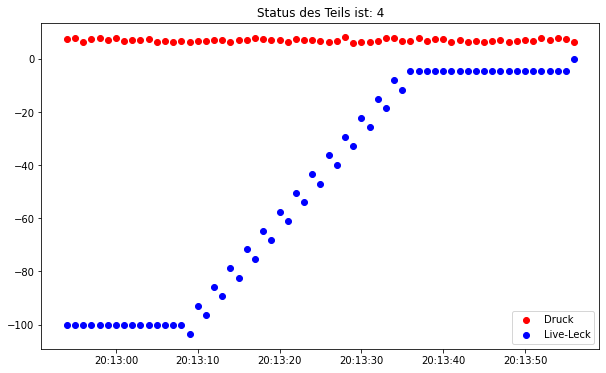

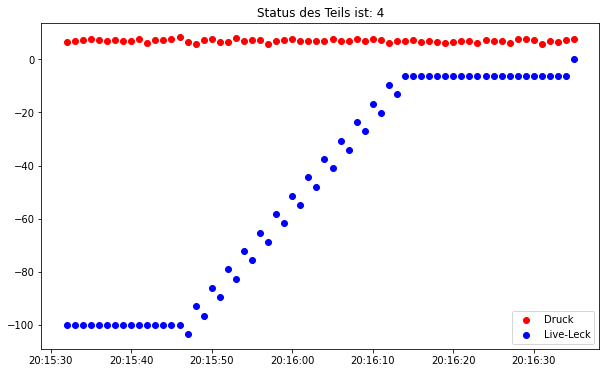

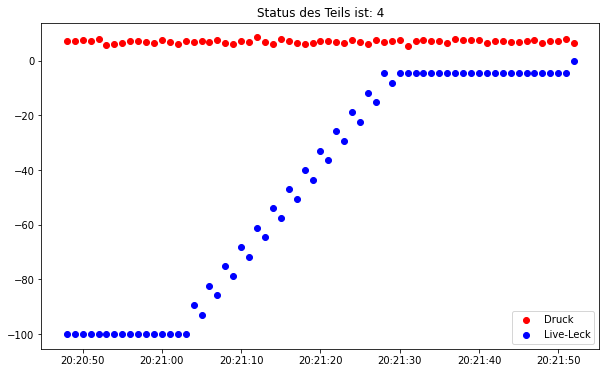

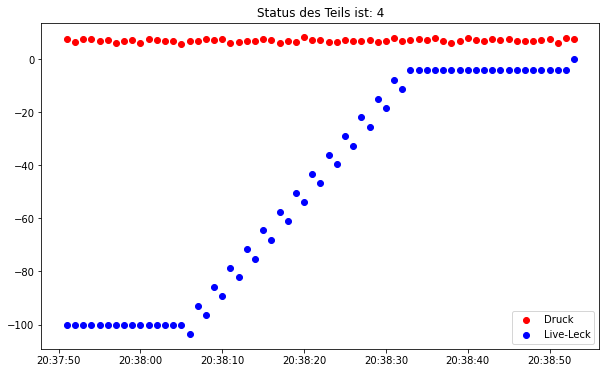

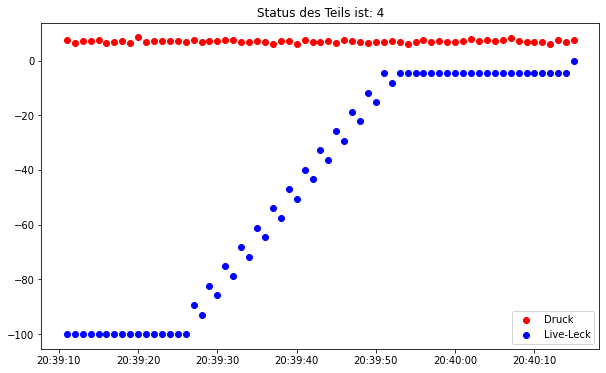

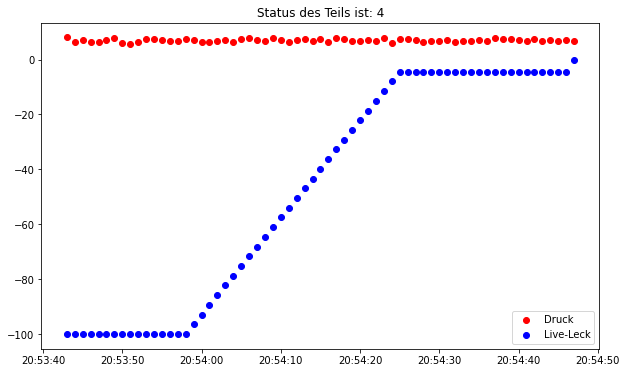

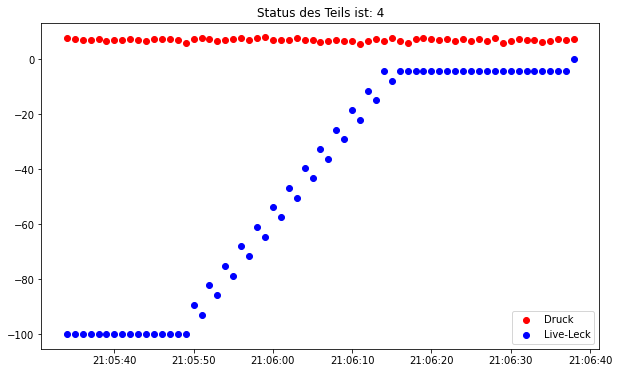

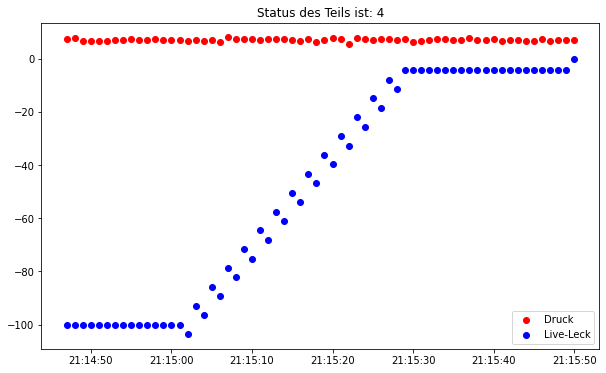

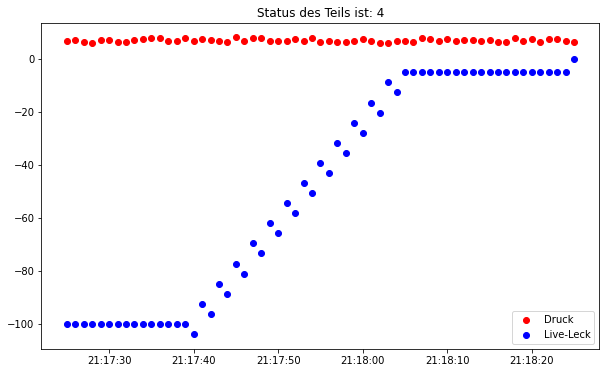

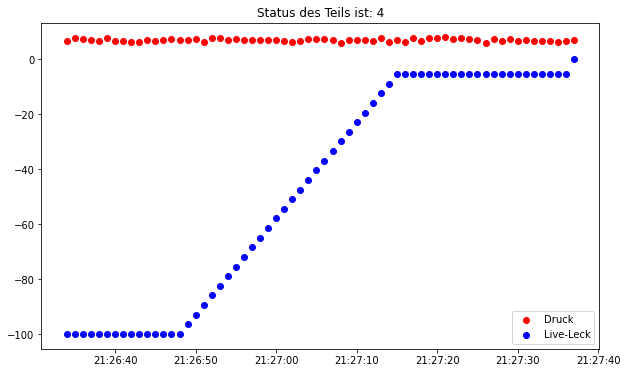

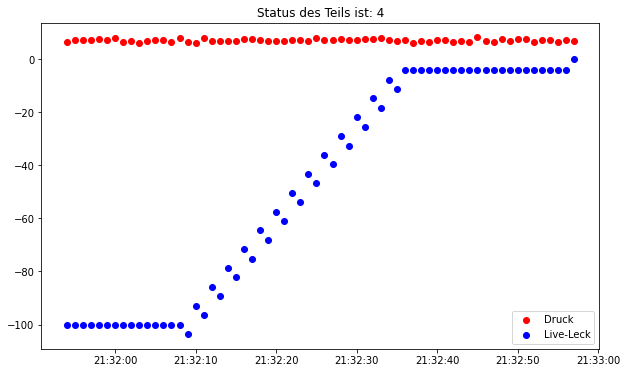

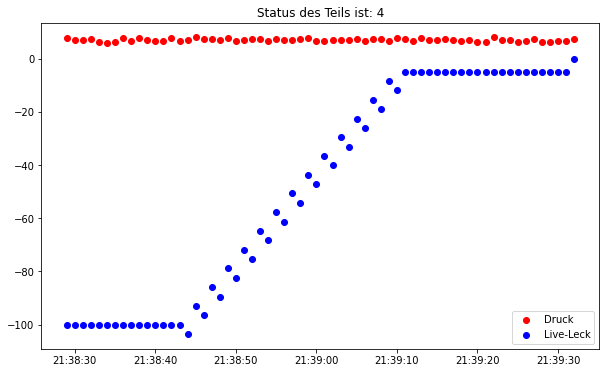

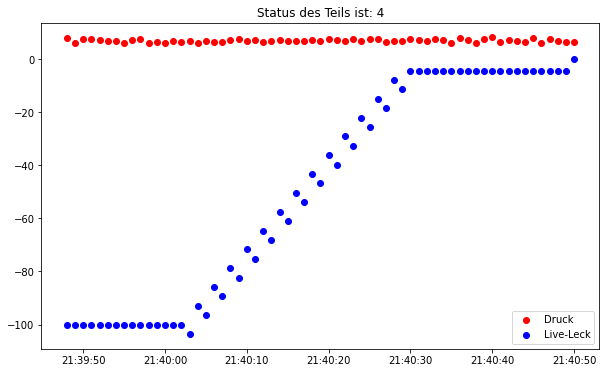

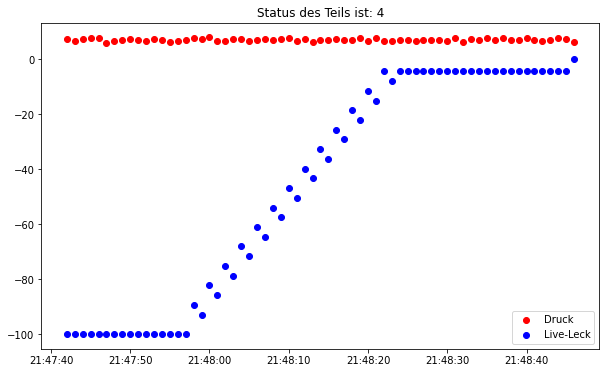

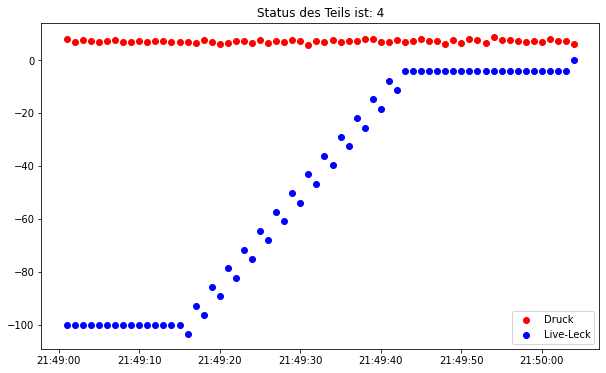

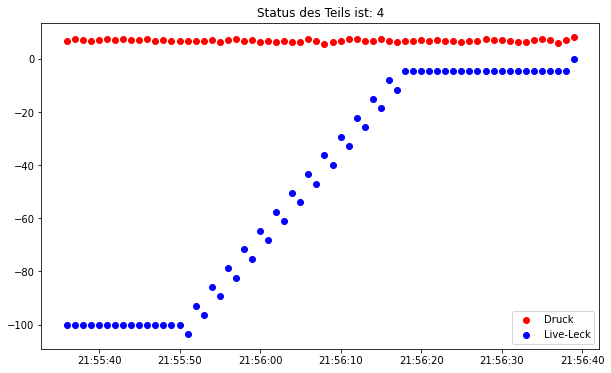

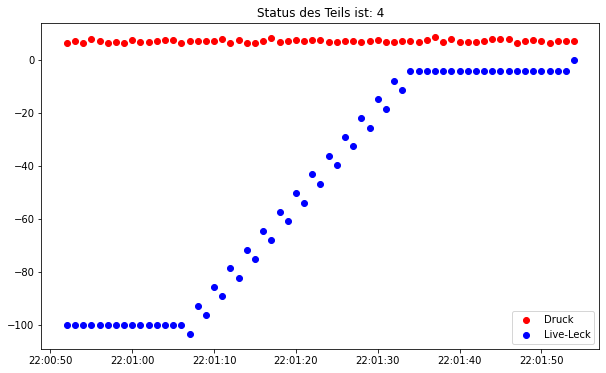

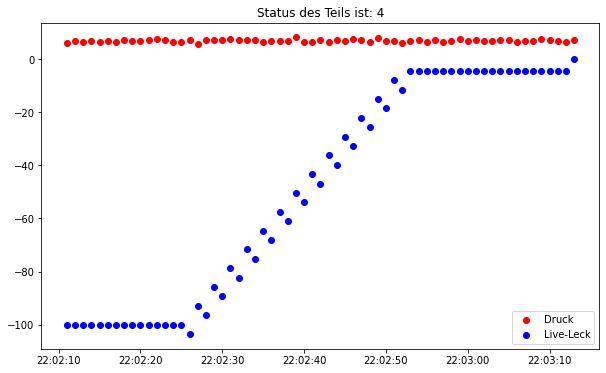

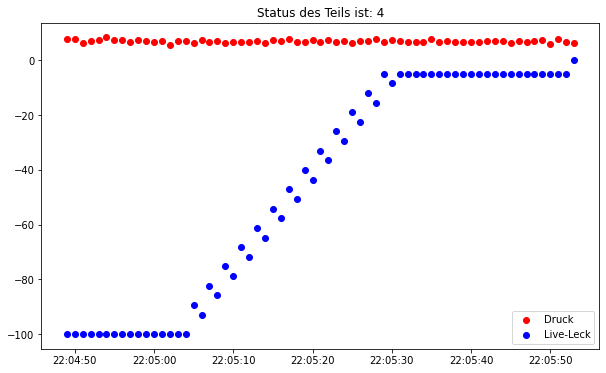

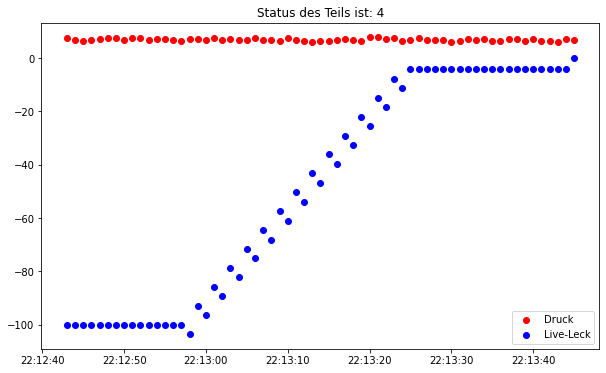

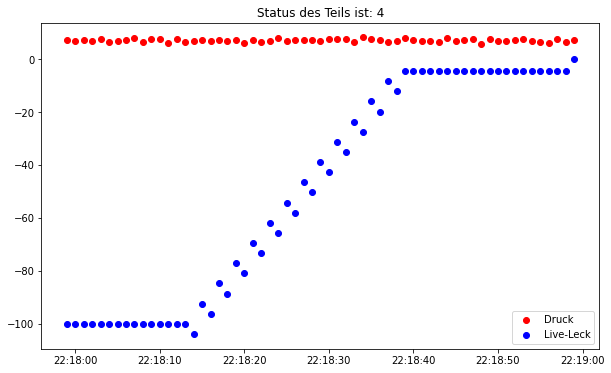

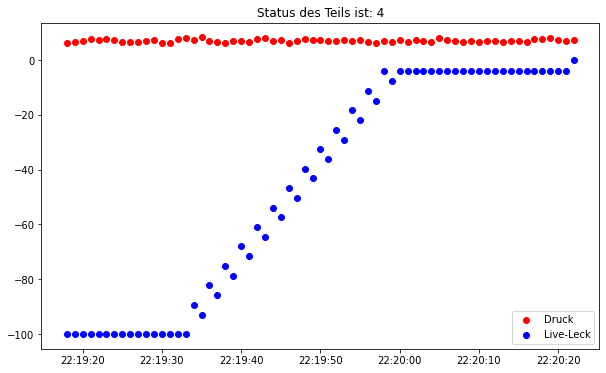

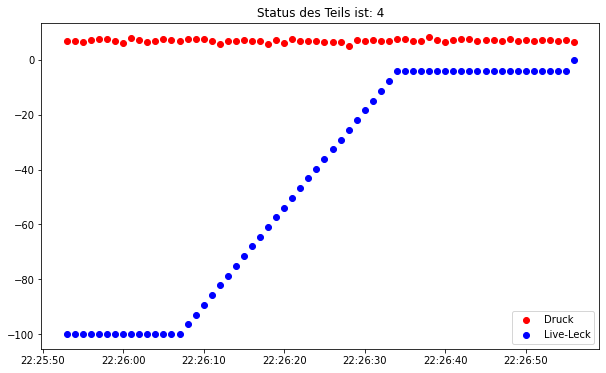

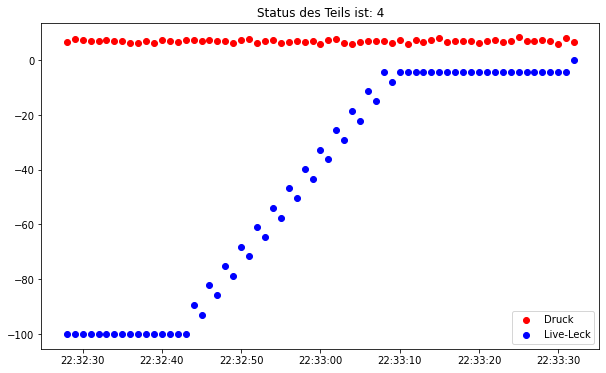

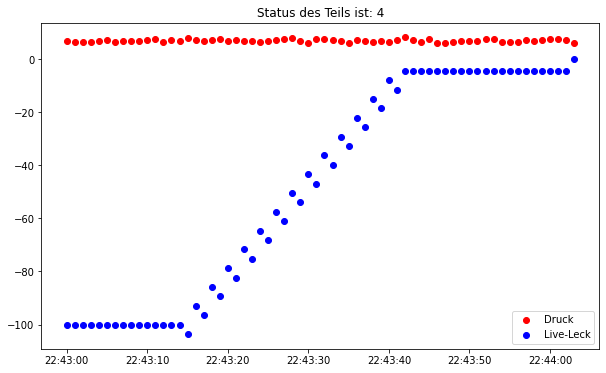

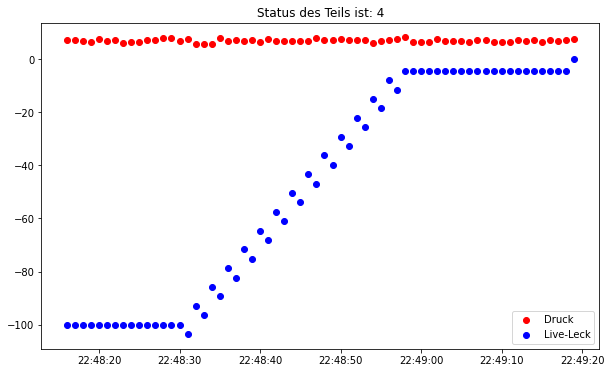

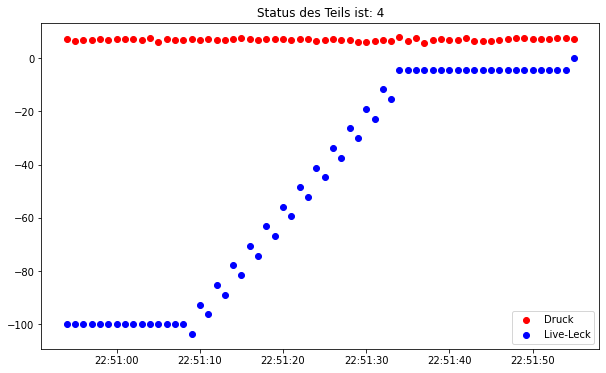

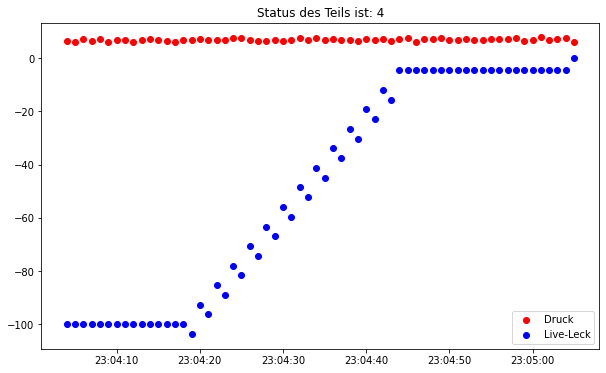

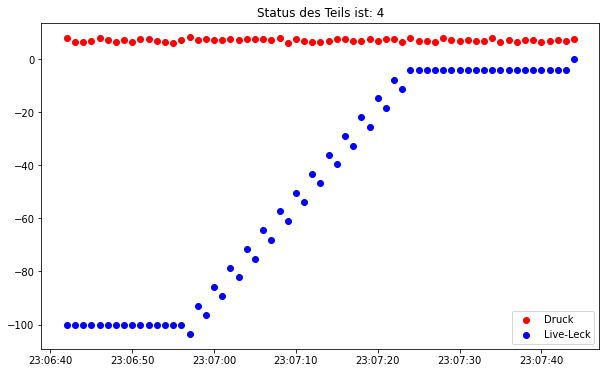

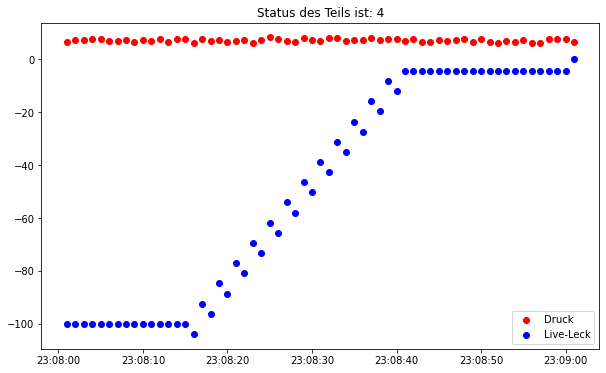

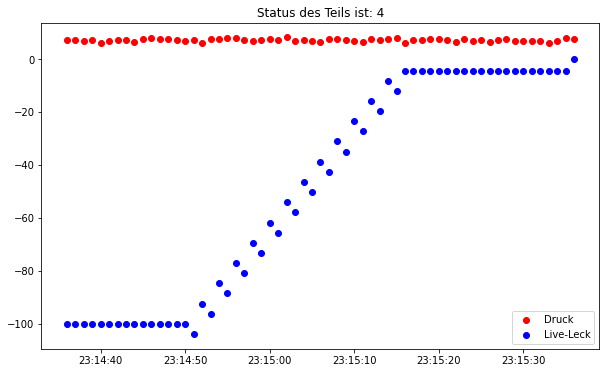

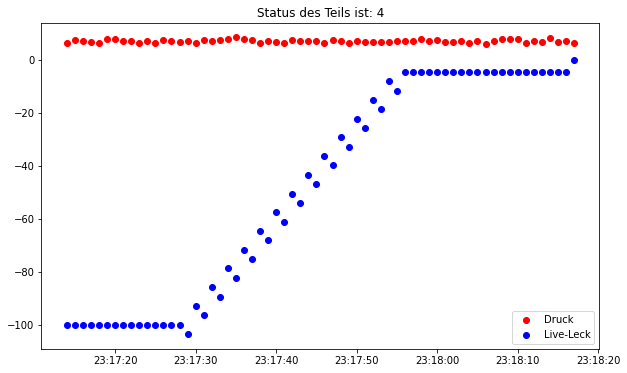

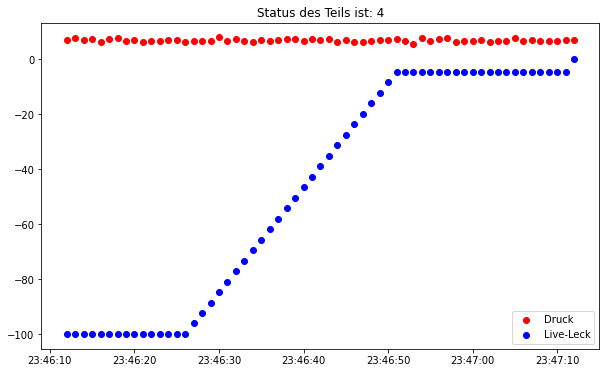

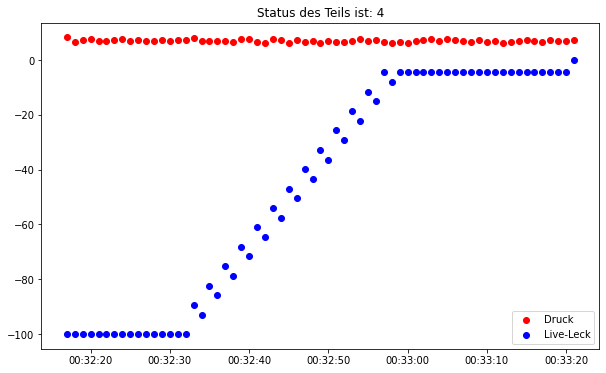

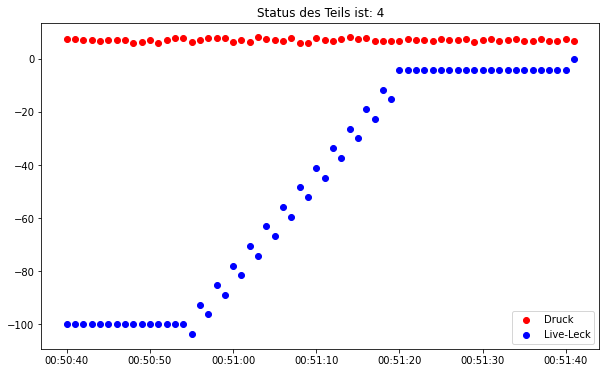

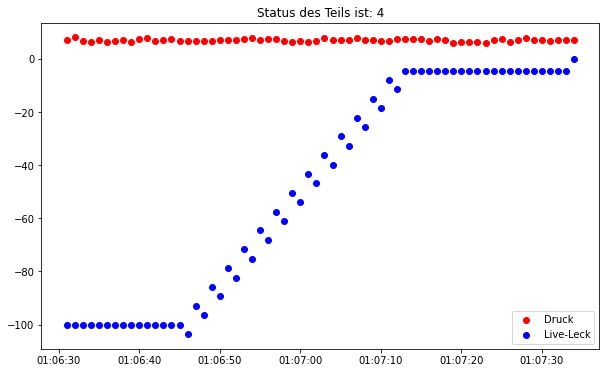

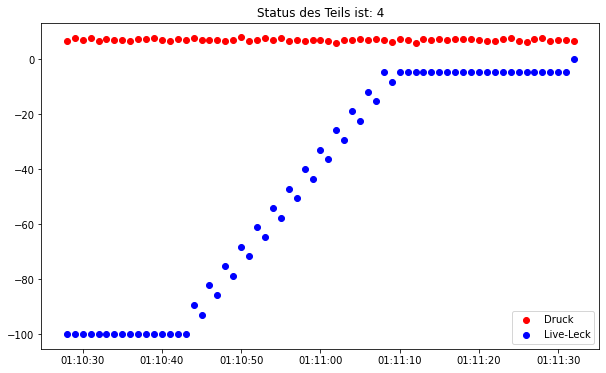

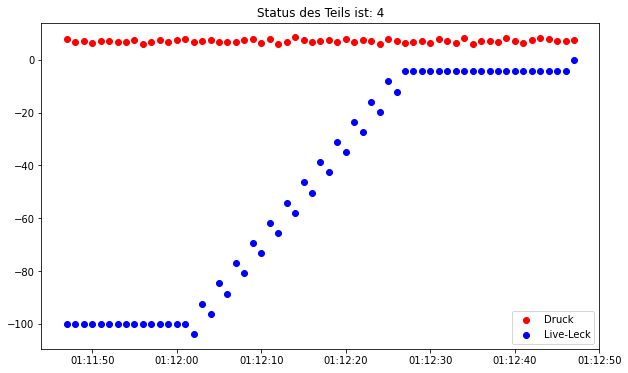

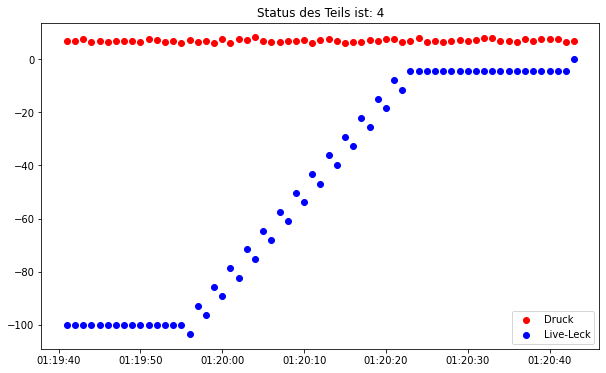

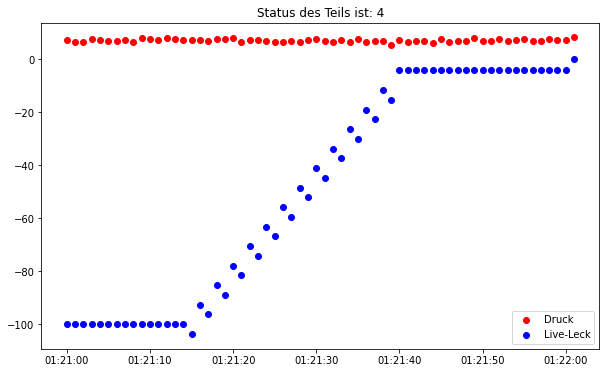

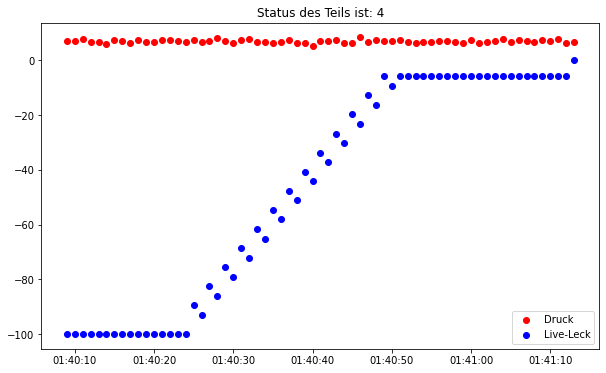

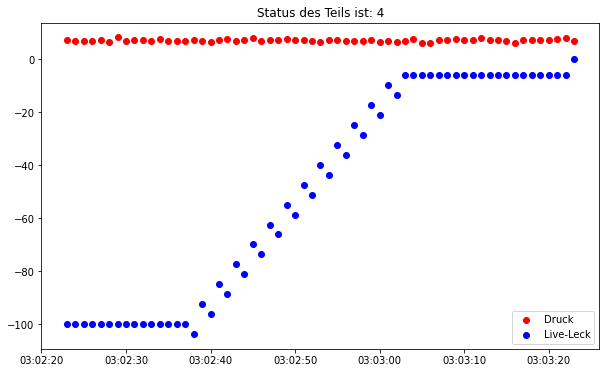

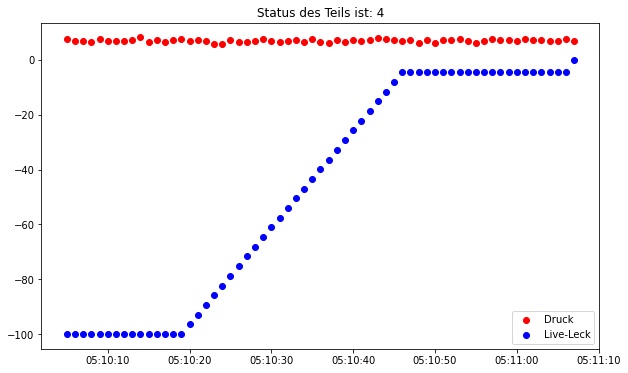

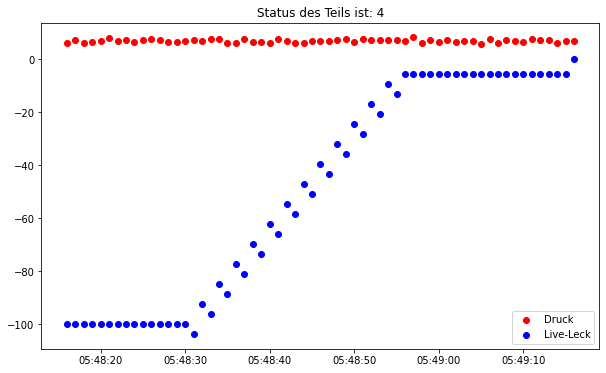

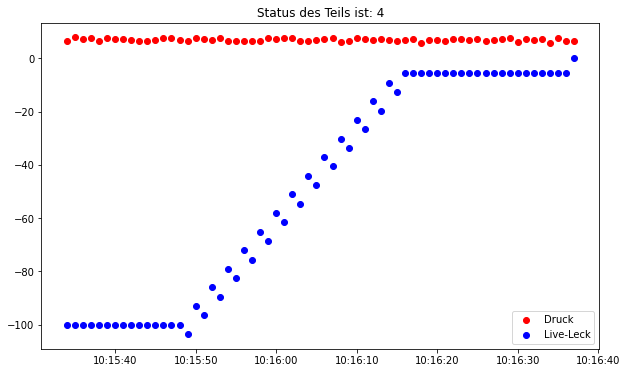

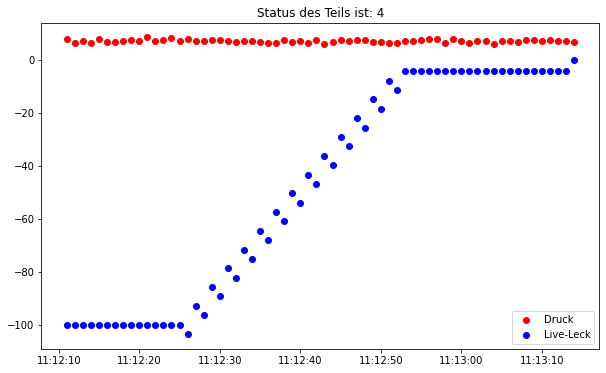

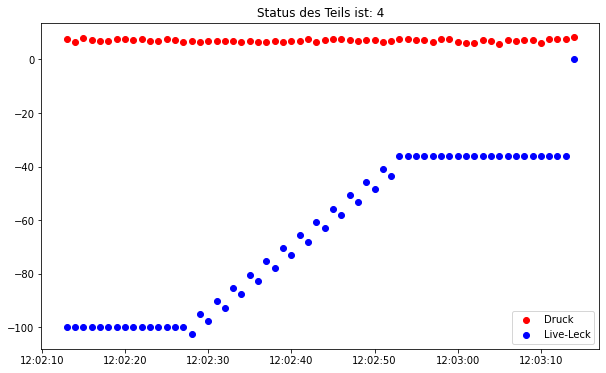

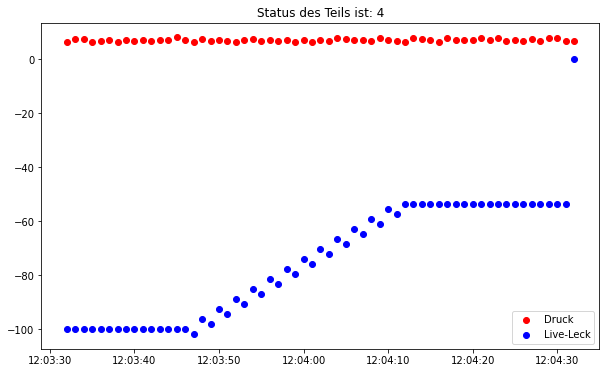

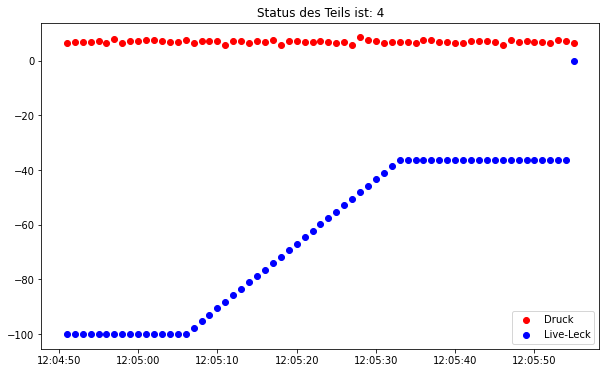

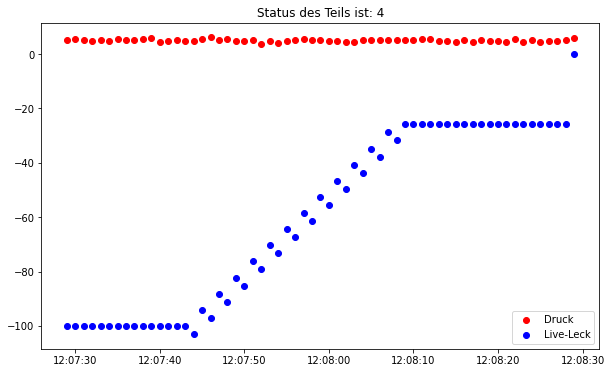

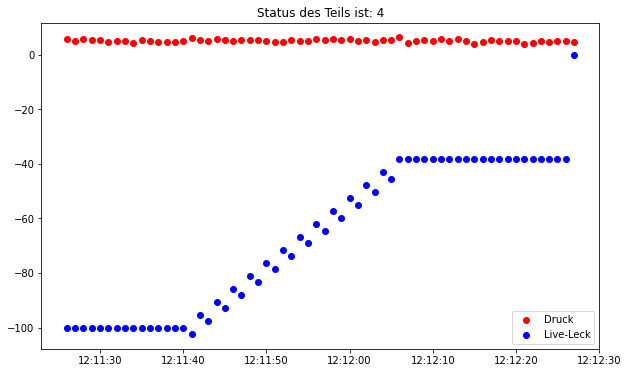

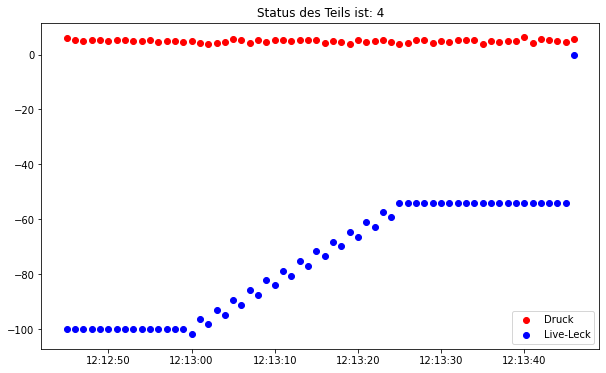

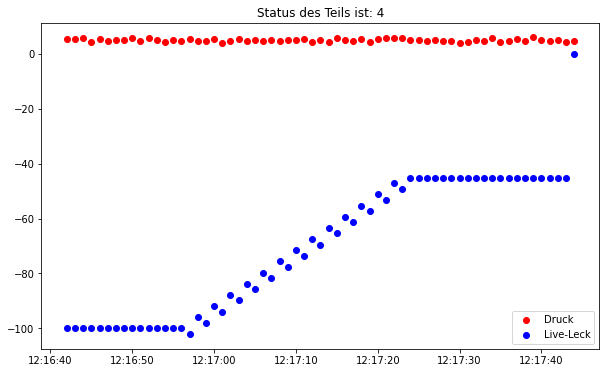

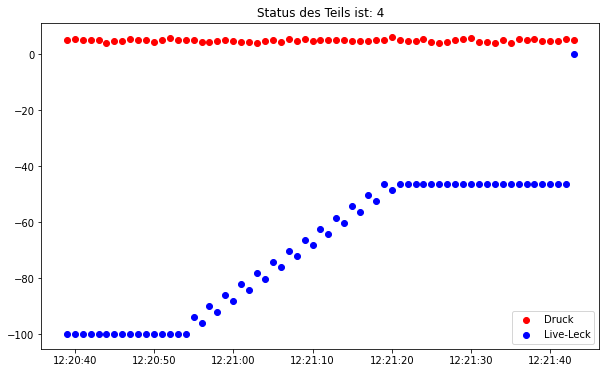

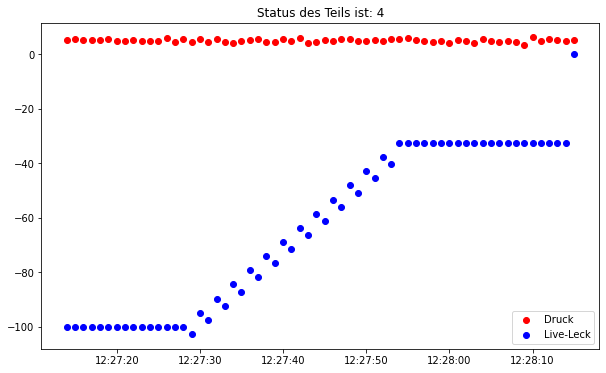

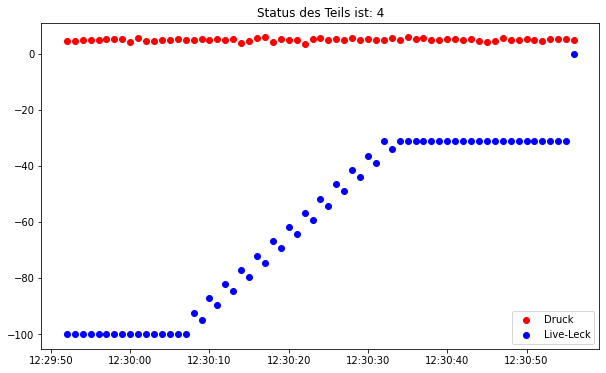

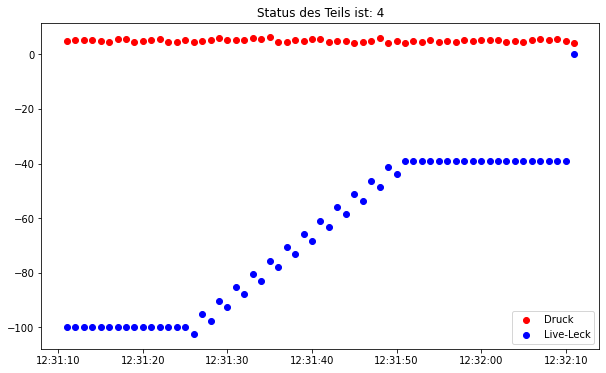

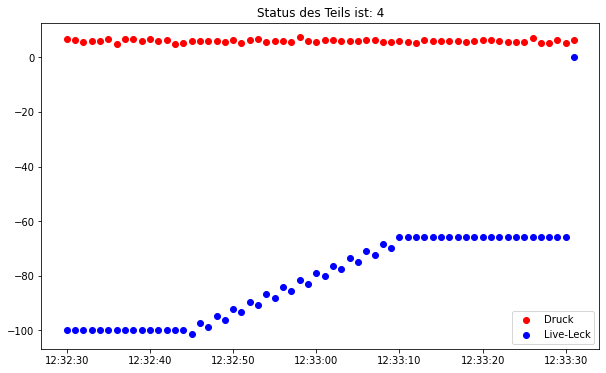

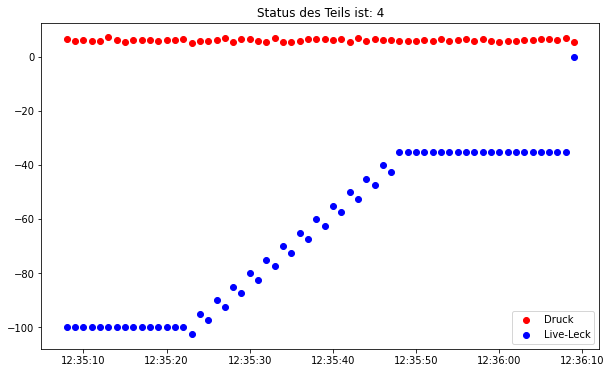

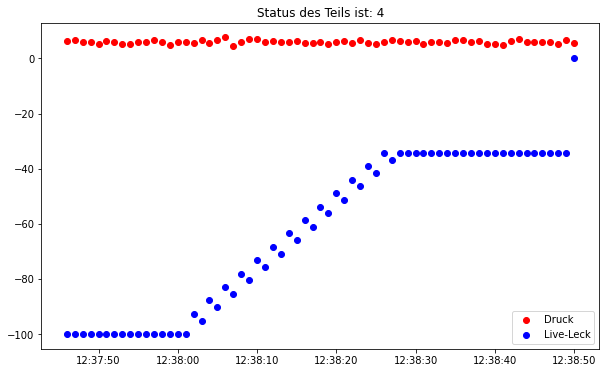

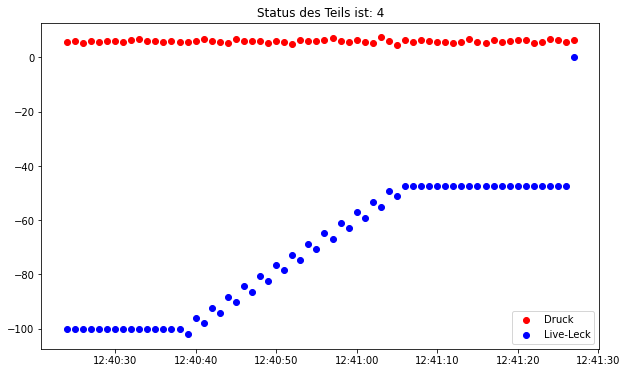

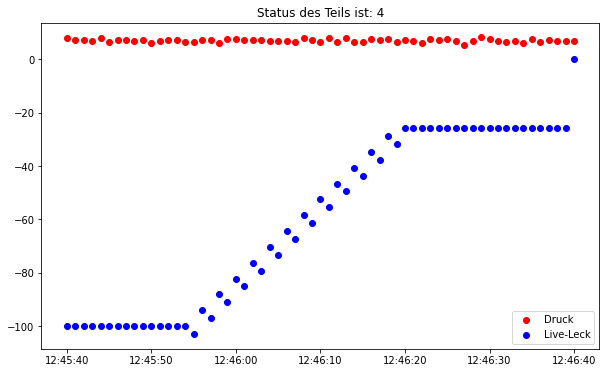

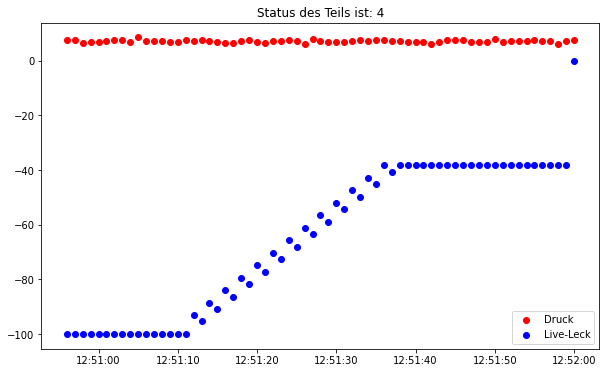

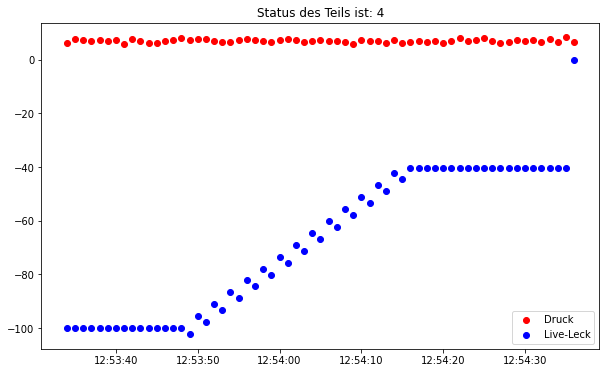

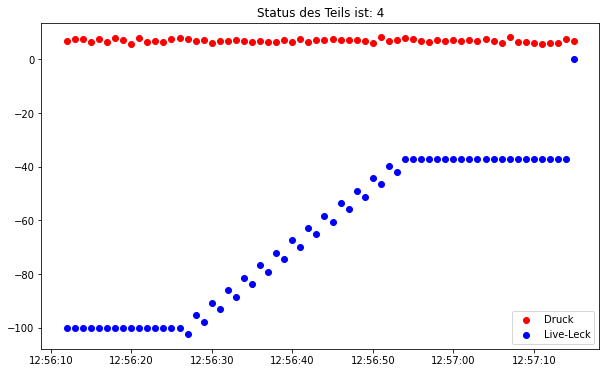

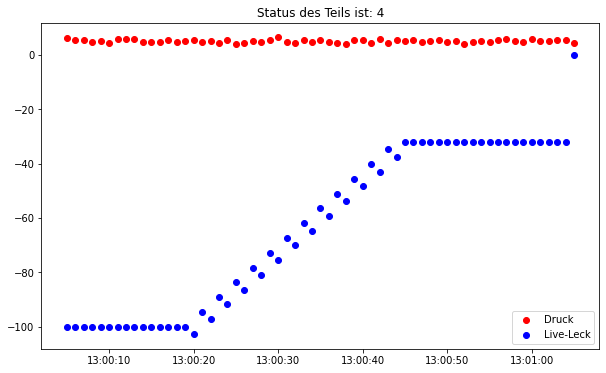

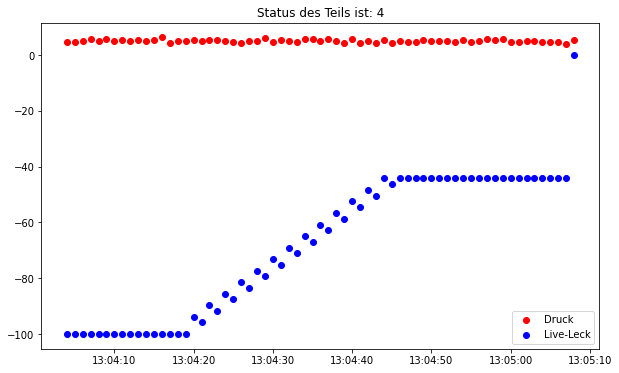

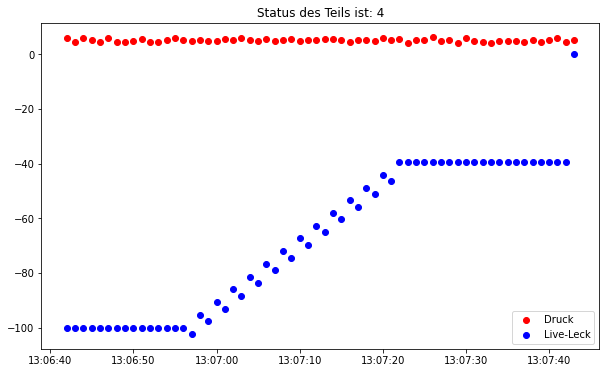

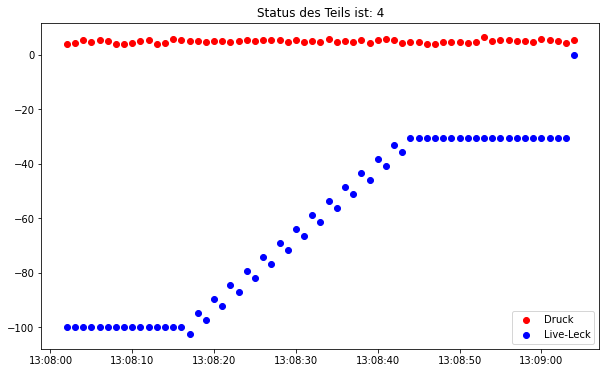

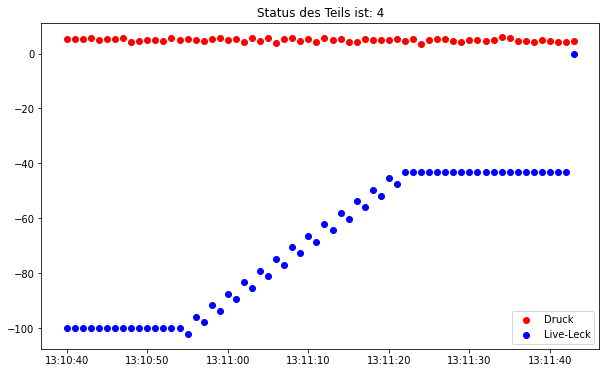

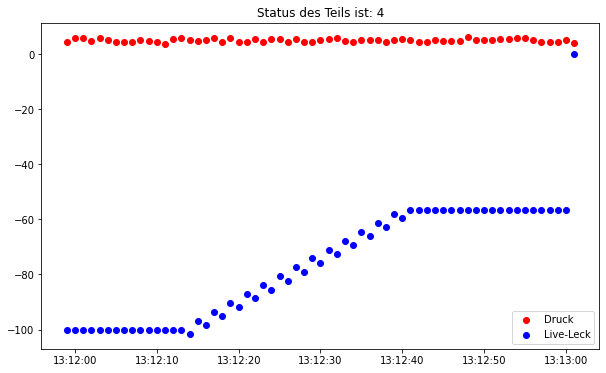

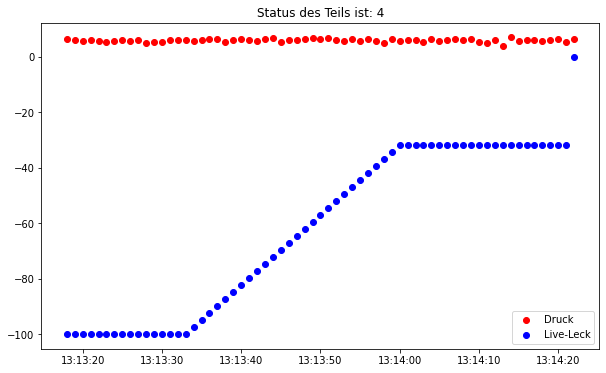

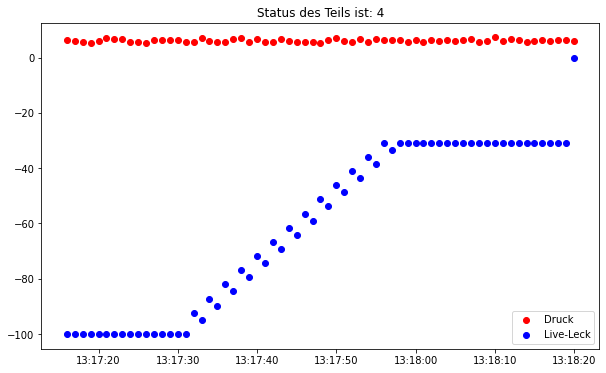

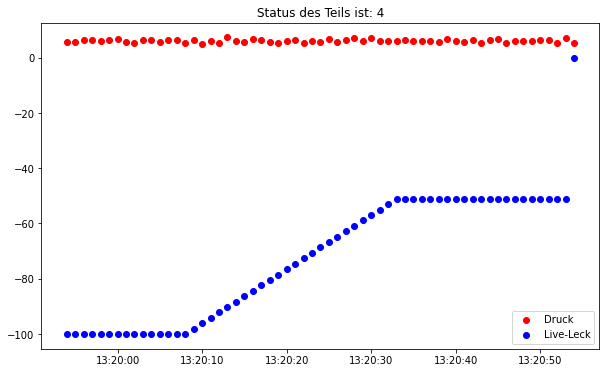

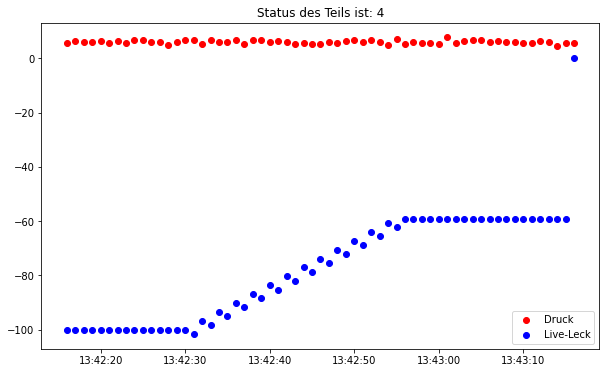

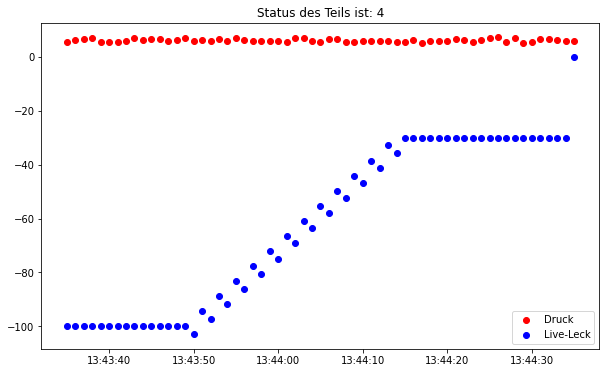

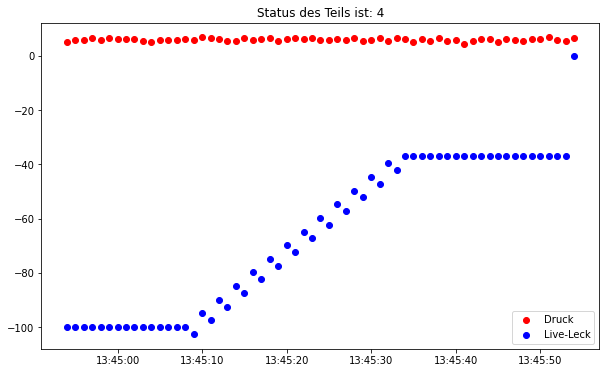

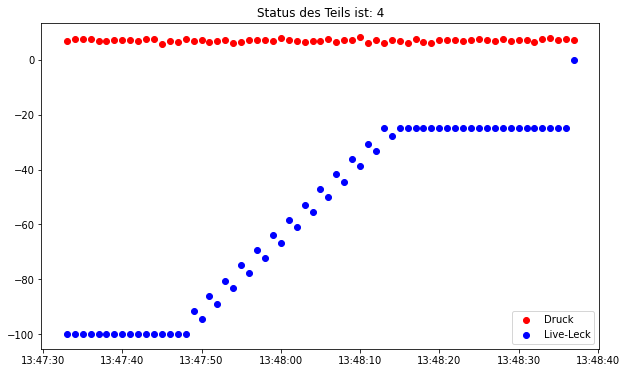

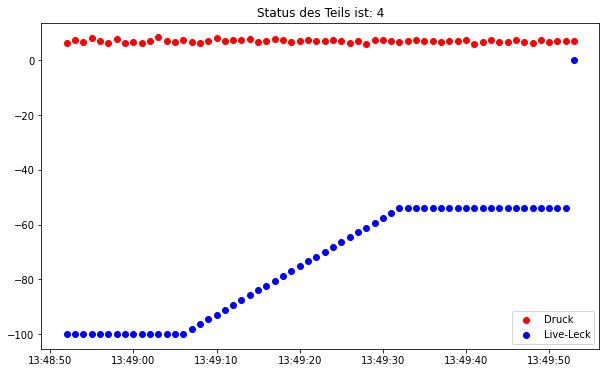

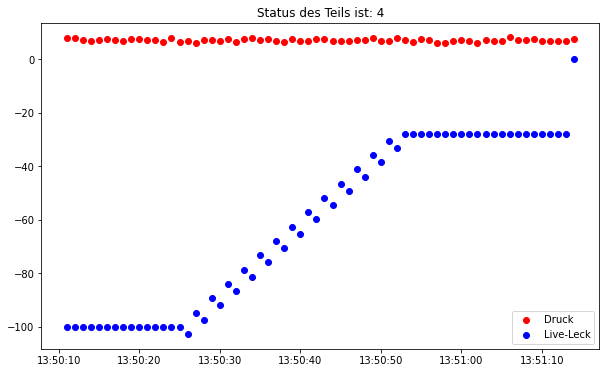

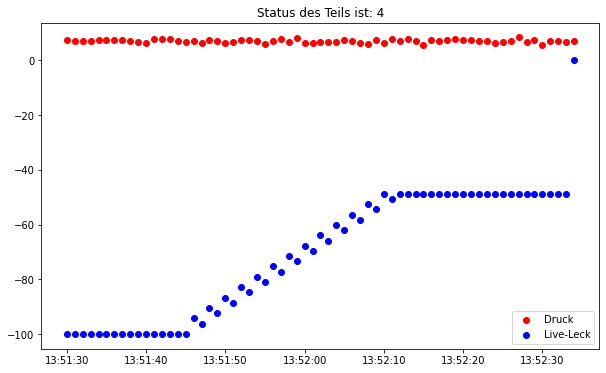

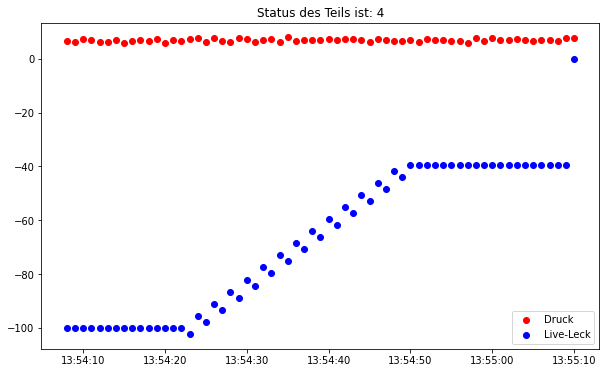

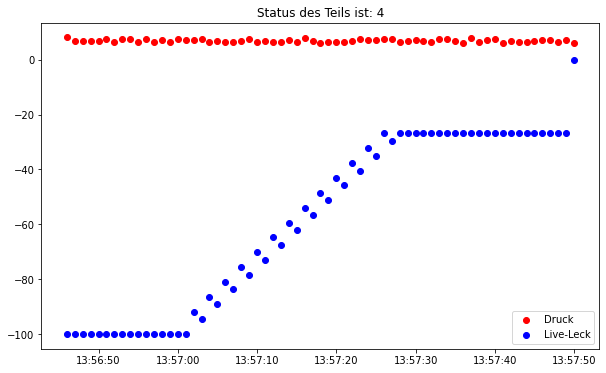

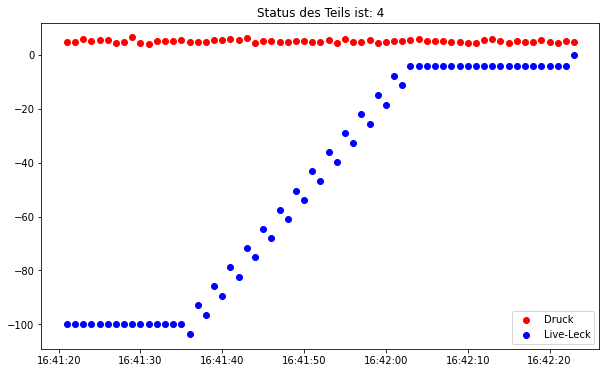

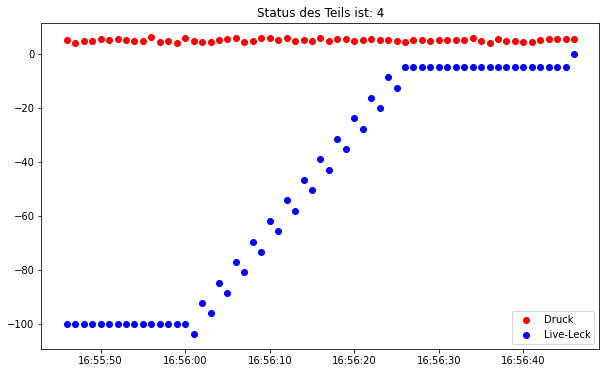

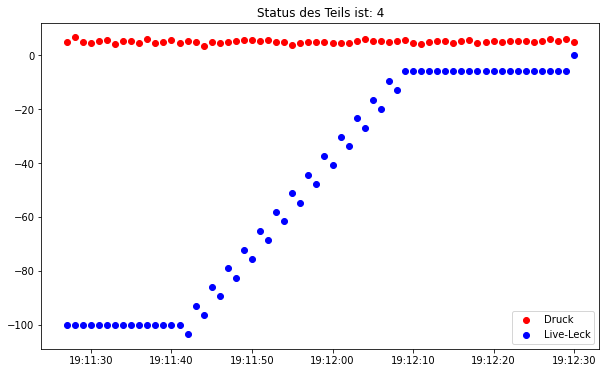

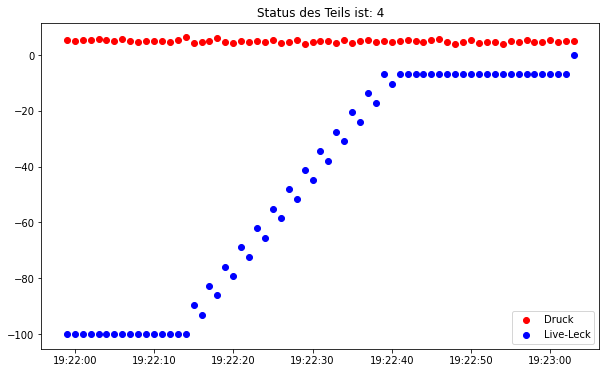

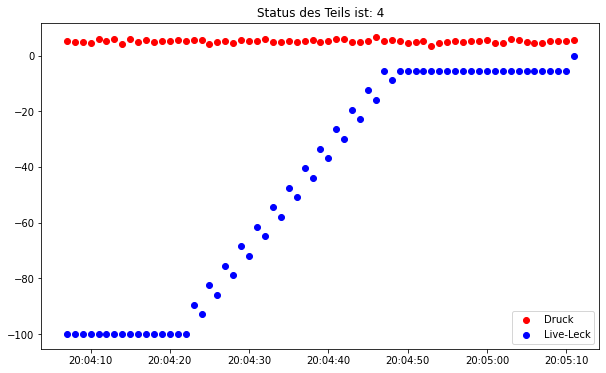

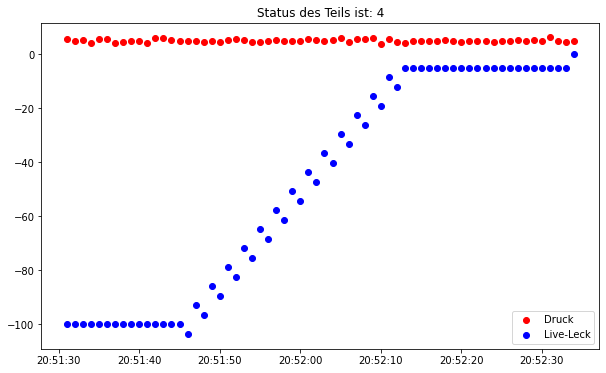

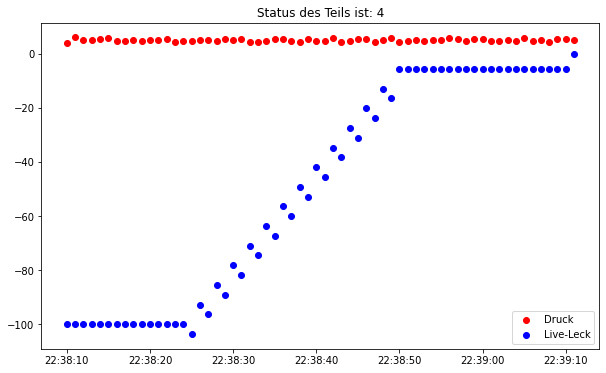

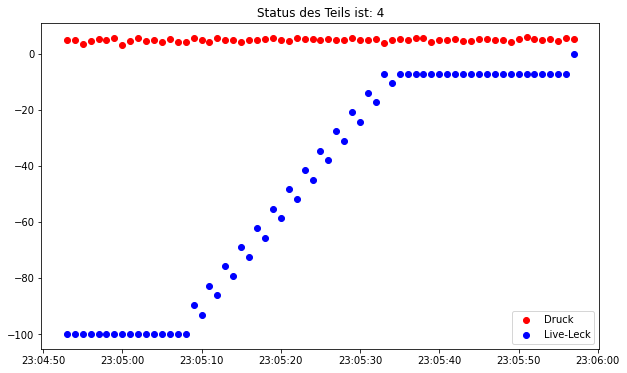

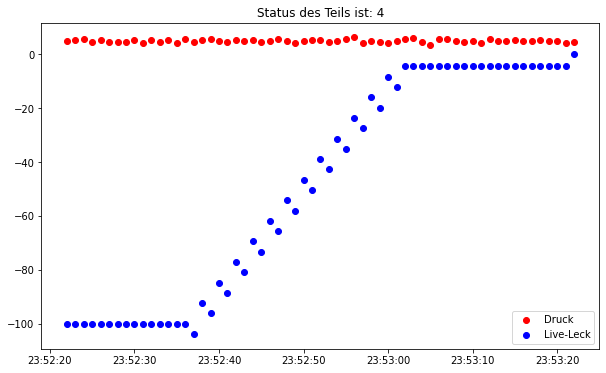

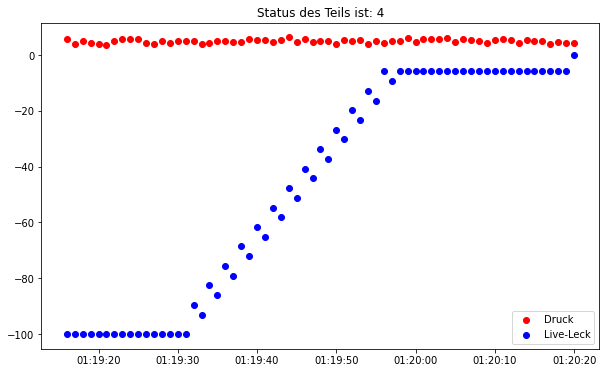

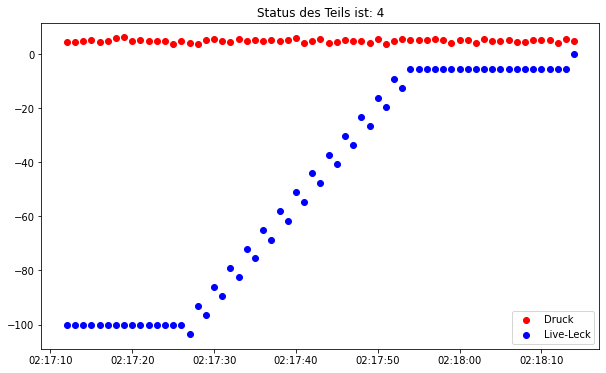

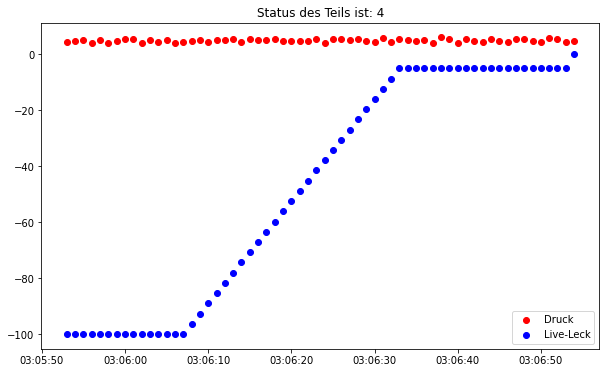

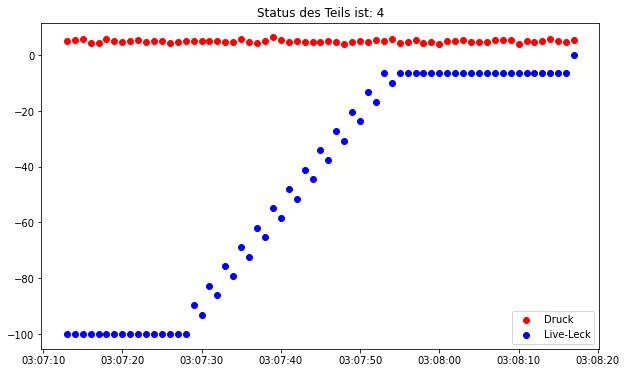

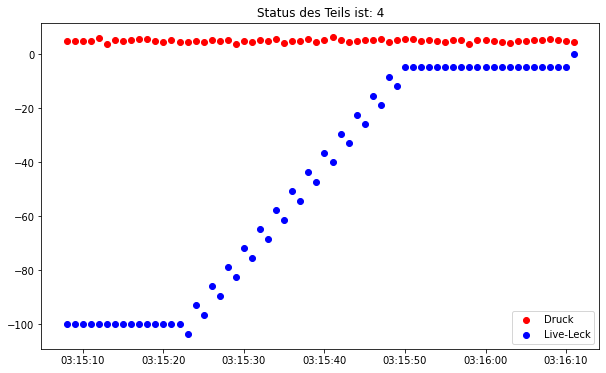

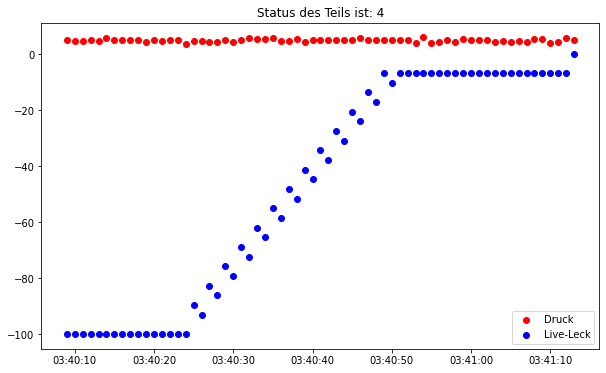

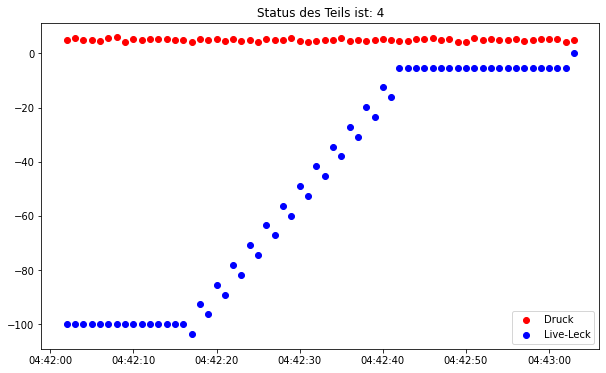

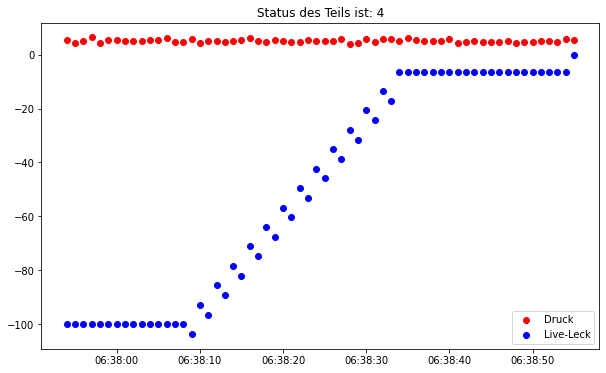

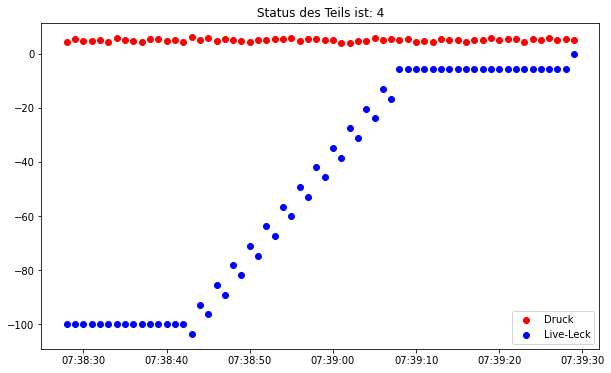

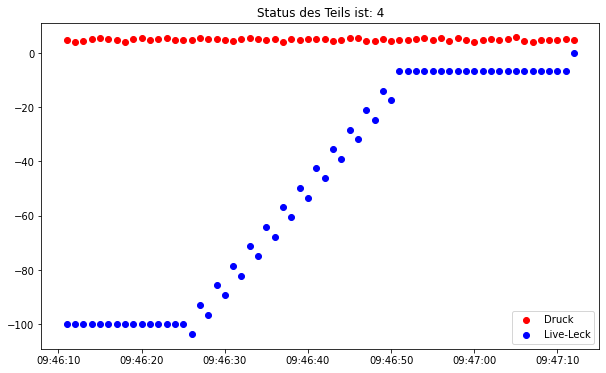

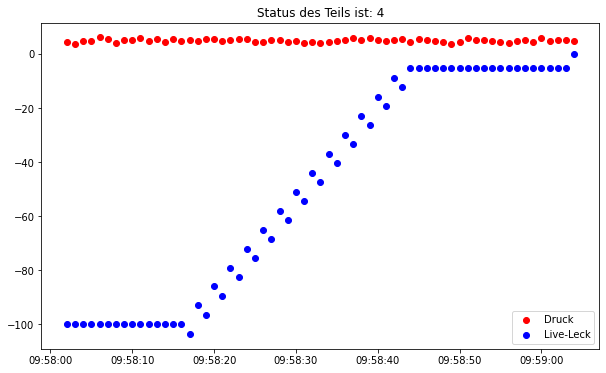

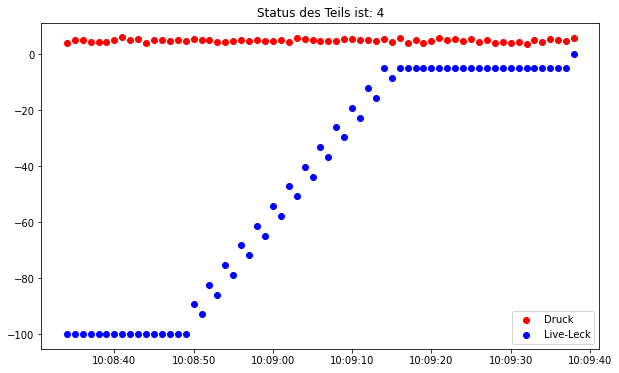

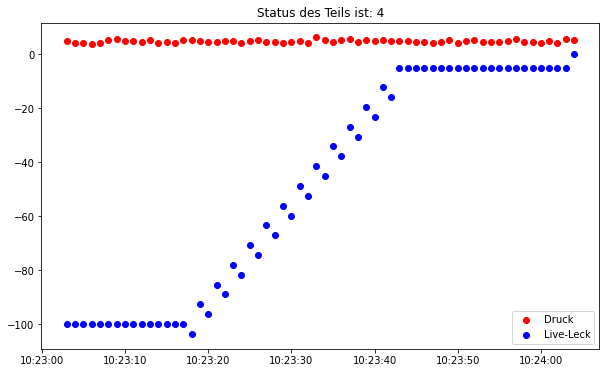

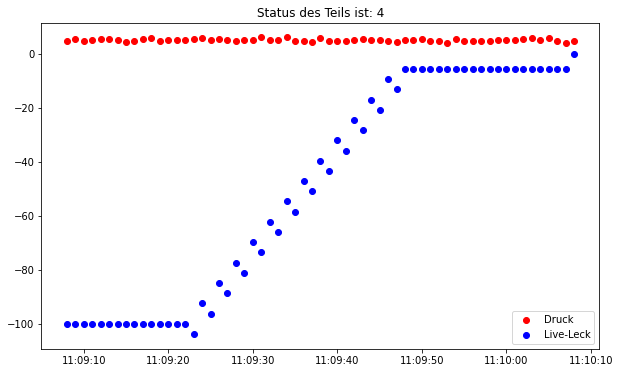

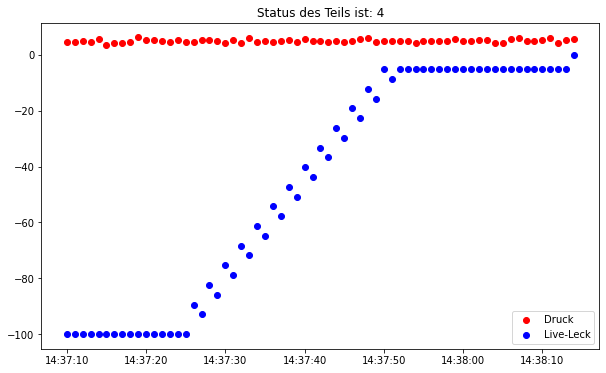

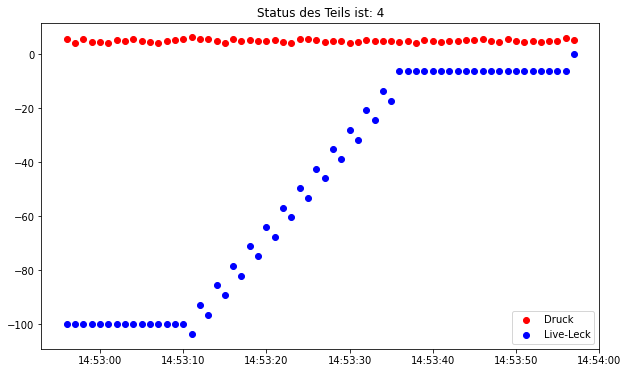

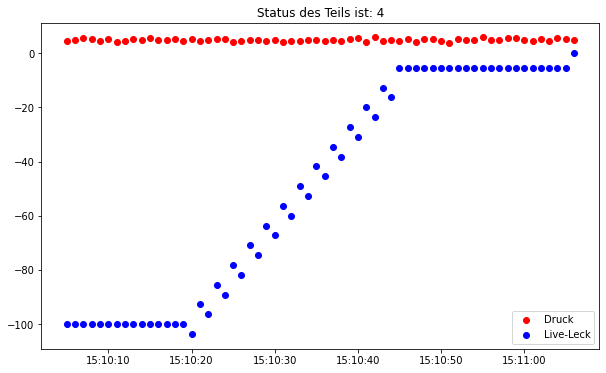

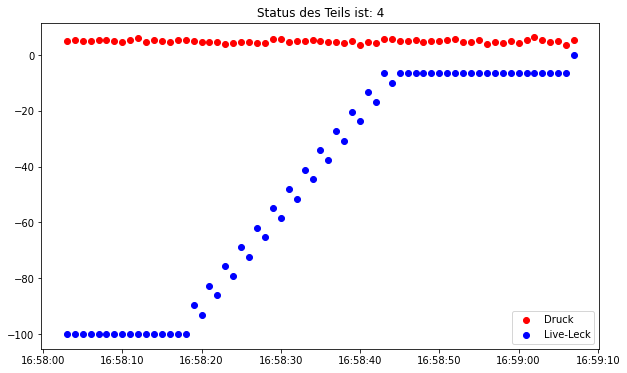

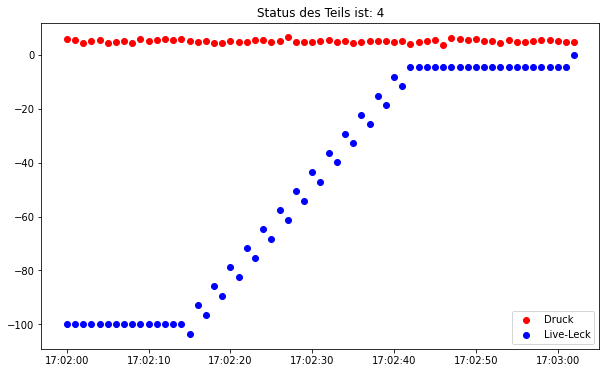

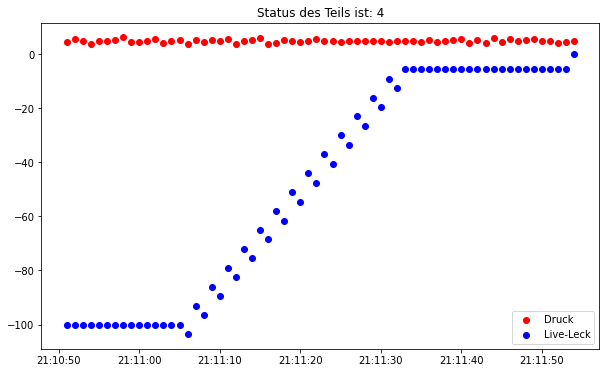

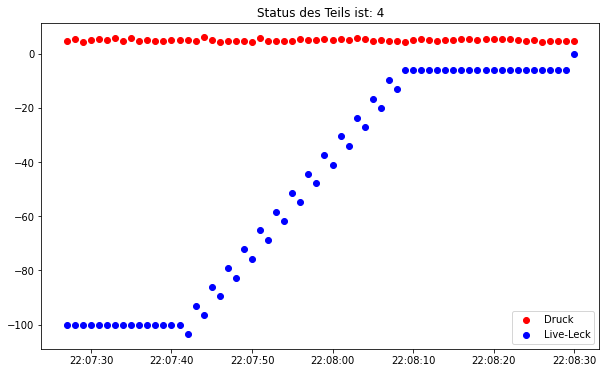

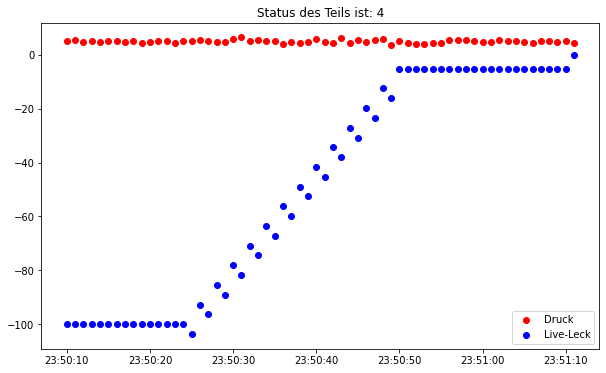

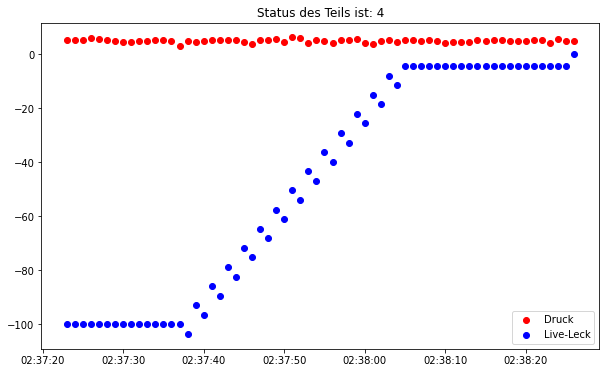

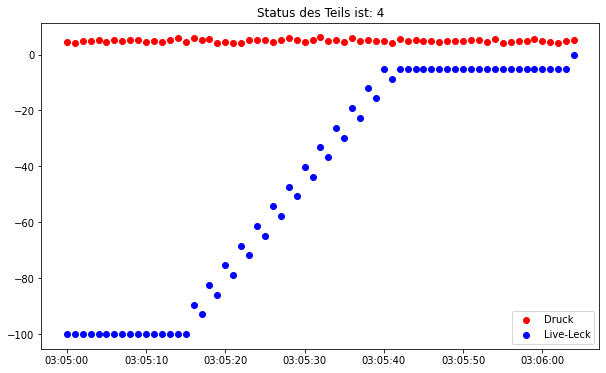

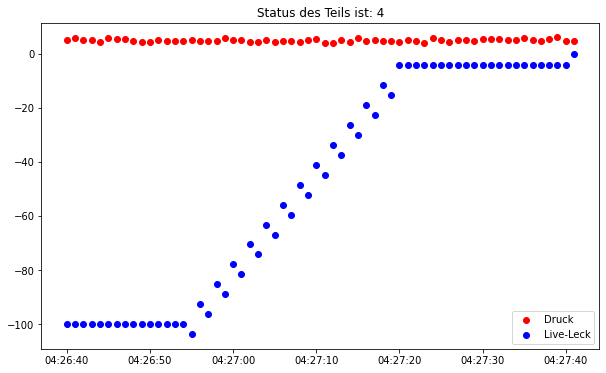

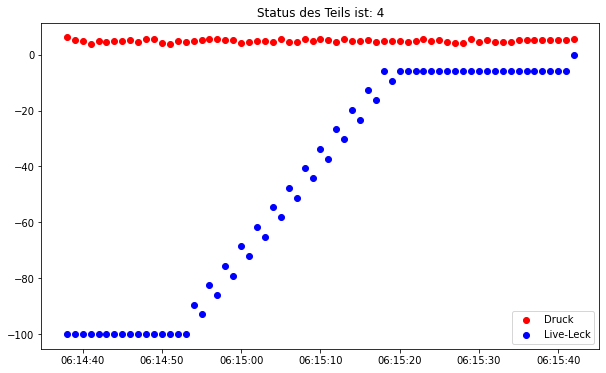

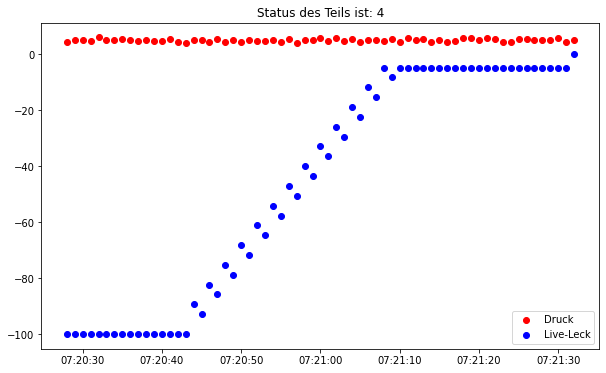

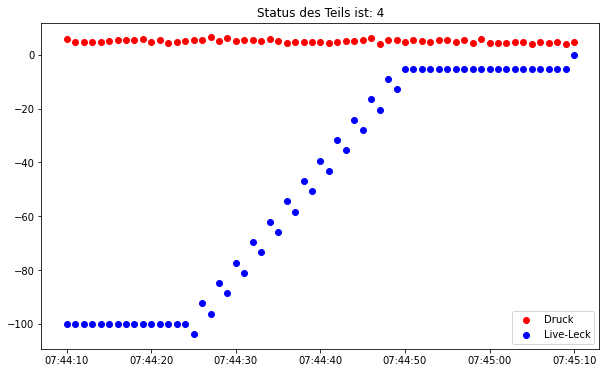

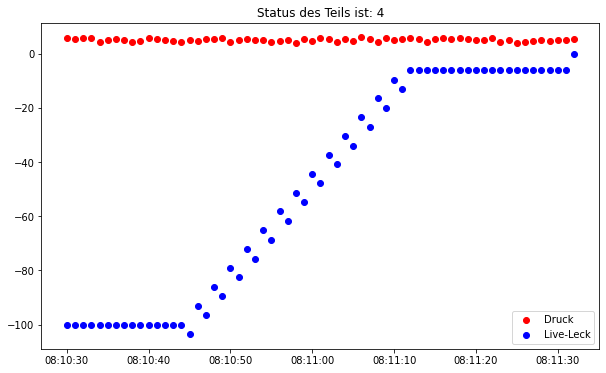

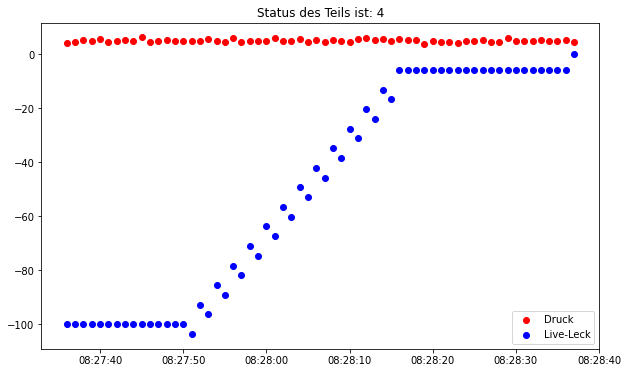

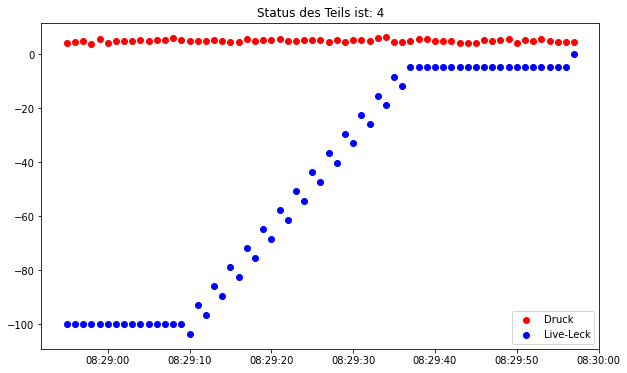

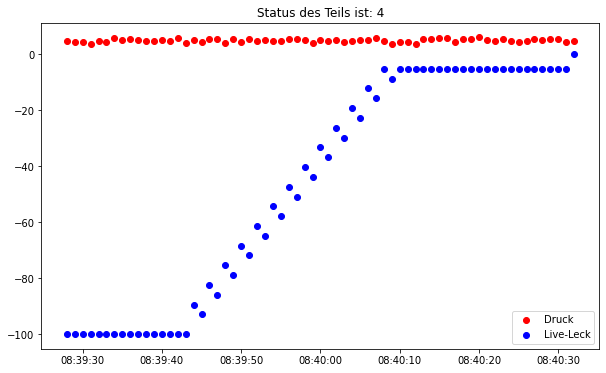

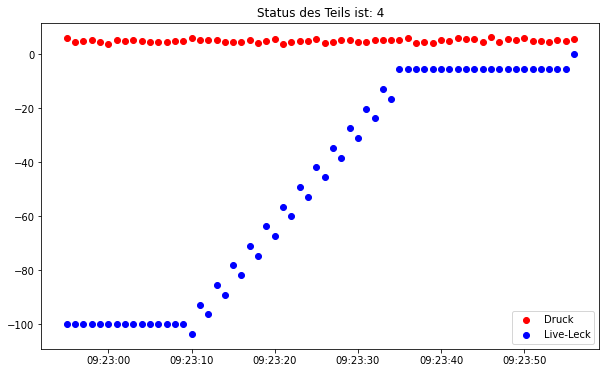

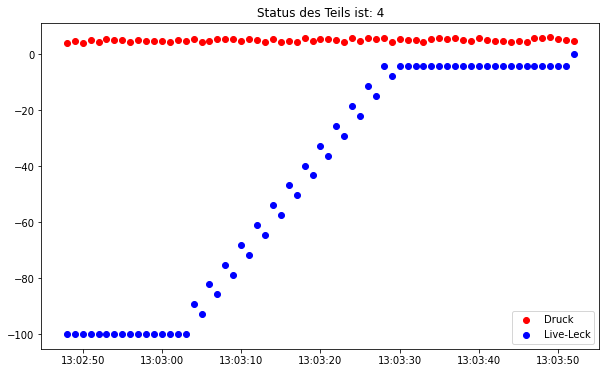

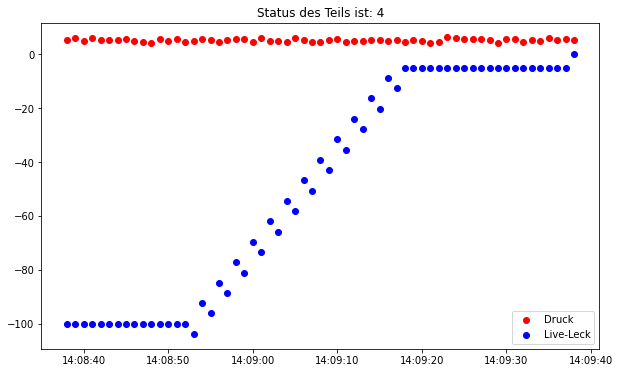

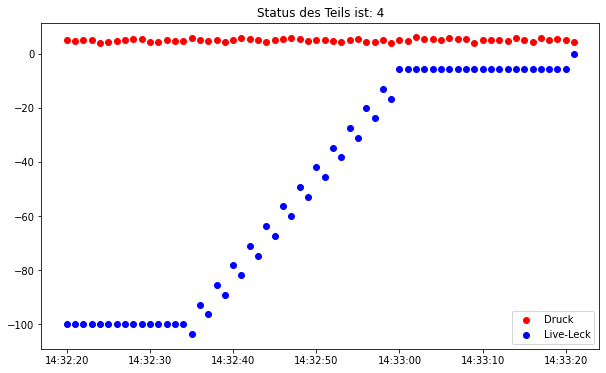

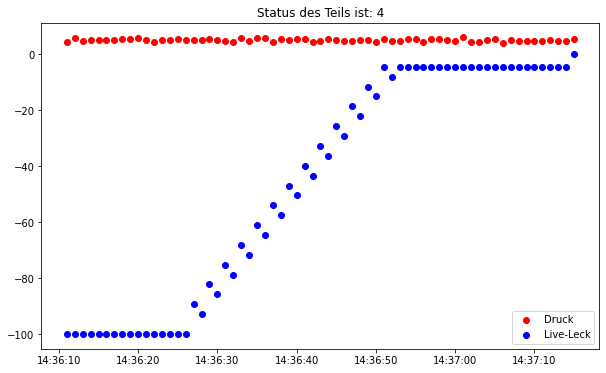

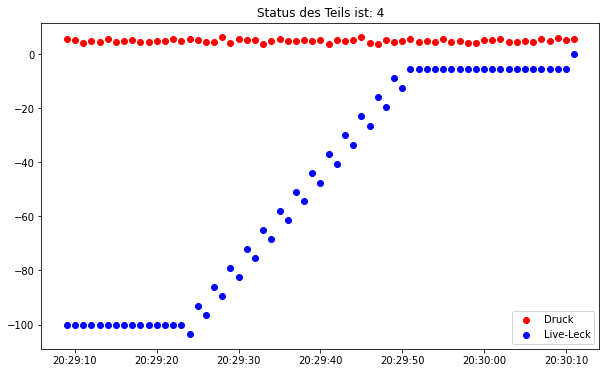

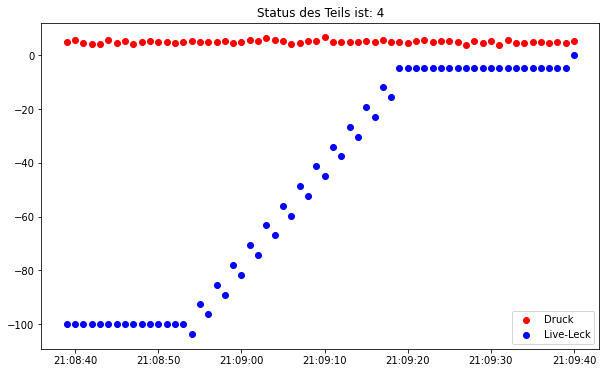

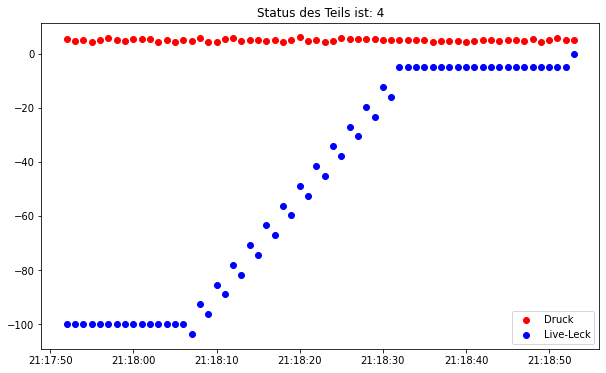

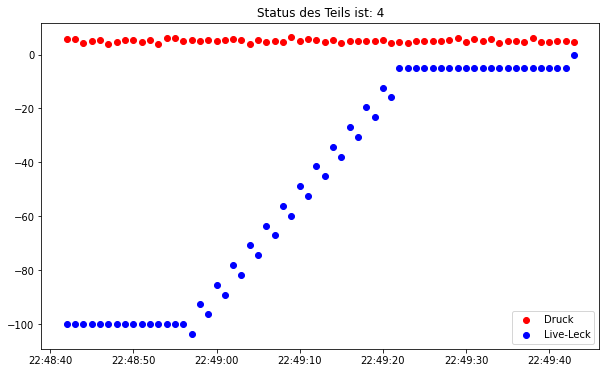

In [ ]:
'''
for t in time_series:
    if t.status[len(t)-1] == 4:
        fig, ax = plt.subplots(figsize=(10,6))
        ax.scatter(t.date, t.druck, color='red', label='Druck')
        ax.scatter(t.date, t.liveleck, color='blue', label='Live-Leck')
        ax.set_title(f"Status des Teils ist: {t.status[len(t)-1]}")
        plt.legend()
        plt.show()
        fig.clear()
'''

In [9]:
leck_liste_s4 = []
for t in status_4:
    leck_liste_s4.append(list(t.liveleck))

In [ ]:
from tslearn.utils import to_time_series_dataset #für variable Länge sollte eig klappen: https://tslearn.readthedocs.io/en/stable/variablelength.html 

In [10]:
from tslearn.utils import to_time_series
formatted_ts_s4 = to_time_series(leck_liste_s4)
print(formatted_ts_s4.shape)

(484, 60)


In [11]:
status_1 = status_1[:-1]

In [12]:
leck_liste_s1 = []
for t in status_1:
    leck_liste_s1.append(list(t.liveleck))

In [13]:
formatted_ts_s1 = to_time_series(leck_liste_s1)
print(formatted_ts_s1.shape)

(17557, 60)


In [14]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k)
    km = km.fit(formatted_ts_s4)
    Sum_of_squared_distances.append(km.inertia_)

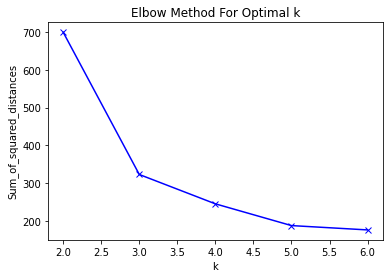

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

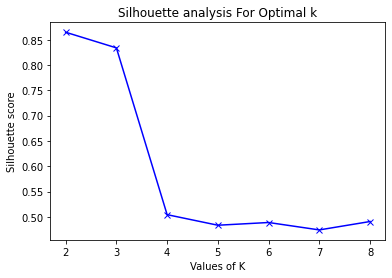

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = TimeSeriesKMeans(n_clusters=num_clusters)
    kmeans.fit(formatted_ts_s4)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(formatted_ts_s4, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

k = 3 am besten

In [15]:
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=42)
y_pred = km.fit_predict(formatted_ts_s4)

437.621 --> 337.376 --> 328.466 --> 323.392 --> 322.705 --> 322.705 --> 


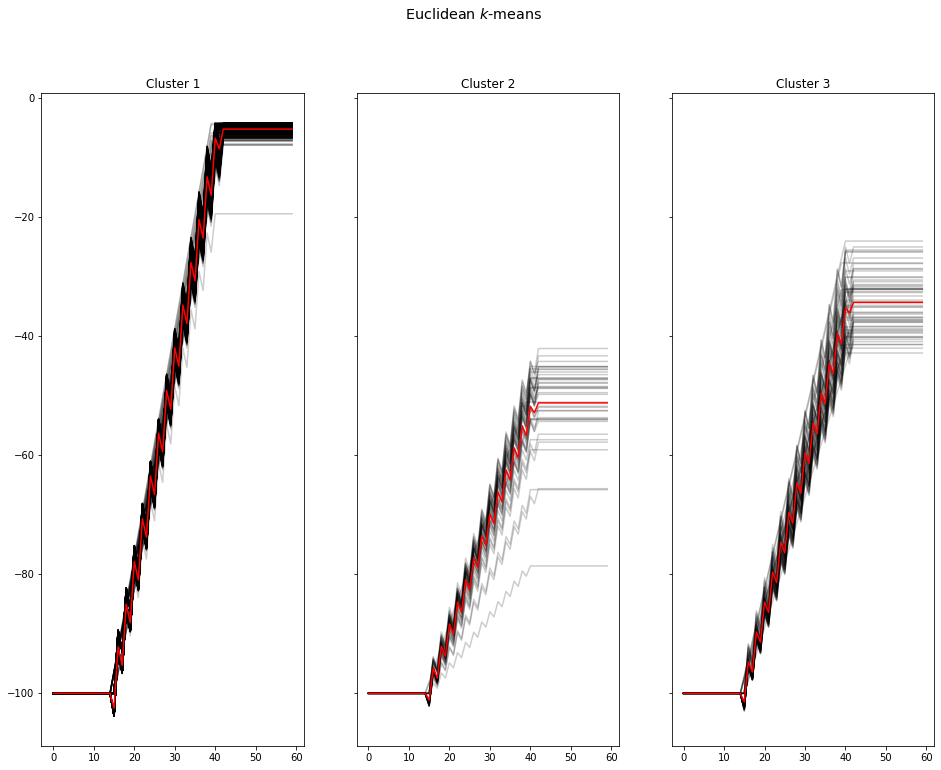

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16,12))
fig.suptitle("Euclidean $k$-means", fontsize='x-large')
for yi in range(3):
    # each axes in the top row gets its own axes title
    ax[yi].set_title('Cluster {}'.format(yi+1))
    for xx in formatted_ts_s4[y_pred == yi]: # pro Cluster die ganzen TS plotten
        ax[yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[yi].plot(km.cluster_centers_[yi].ravel(), "r-") # pro Cluster einmal das Zentrum plotten (red)

In [18]:
from collections import Counter

In [19]:
Counter(df.status)

Counter({0: 796219, 3: 1118214, 1: 53271, 4: 1452})

In [ ]:
Counter(y_pred)

Counter({0: 386, 1: 39, 2: 59})

In [ ]:
formatted_ts_s4[y_pred == 1][0]

array([-100.        , -100.        , -100.        , -100.        ,
       -100.        , -100.        , -100.        , -100.        ,
       -100.        , -100.        , -100.        , -100.        ,
       -100.        , -100.        , -100.        , -100.        ,
        -94.27132766,  -96.1808851 ,  -90.45221276,  -92.36177021,
        -86.63309786,  -88.54265531,  -82.81398297,  -84.72354042,
        -78.99486807,  -80.90442552,  -75.17575318,  -77.08531062,
        -71.35663828,  -73.26619573,  -67.53752338,  -69.44708083,
        -63.71840849,  -65.62796594,  -59.89929359,  -61.80885104,
        -56.0801787 ,  -57.98973614,  -52.2610638 ,  -54.17062125,
        -48.4419489 ,  -50.35150635,  -48.4419489 ,  -48.4419489 ,
        -48.4419489 ,  -48.4419489 ,  -48.4419489 ,  -48.4419489 ,
        -48.4419489 ,  -48.4419489 ,  -48.4419489 ,  -48.4419489 ,
        -48.4419489 ,  -48.4419489 ,  -48.4419489 ,  -48.4419489 ,
        -48.4419489 ,  -48.4419489 ,  -48.4419489 ,  -48.44194

In [ ]:
df_col[(df_col.status == 4) & (df_col.iomaster == True)]

Empty DataFrame
Columns: [iomaster, druck, temperatur, leck, liveleck, status, date]
Index: []

In [ ]:
df[(df.repair_label_change_dichtring == True)].head()

timestamp  iomaster  messenaktiv  handaktiv     druck  temperatur  \
399860  1668180452000     False        False       True  4.868938   24.152021   
399861  1668180453000     False        False       True  4.867993   24.152021   
399862  1668180454000     False        False       True  5.155423   24.152021   
399863  1668180455000     False        False       True  5.062066   24.152021   
399864  1668180456000     False        False       True  4.701738   24.152021   

        leck  liveleck  status  maintenance_label_cleaning  \
399860   0.0       0.0       1                       False   
399861   0.0       0.0       1                       False   
399862   0.0       0.0       1                       False   
399863   0.0       0.0       1                       False   
399864   0.0       0.0       1                       False   

        rework_label_assembly_error  repair_label_change_dichtring  \
399860                        False                           True   
399861                        False                           True   
399862                        False                           True   
399863                        False                           True   
399864                        False                           True   

        configuration_label_druck_change_5  \
399860                               False   
399861                               False   
399862                               False   
399863                               False   
399864                               False   

        configuration_label_druck_change_6  \
399860                               False   
399861                               False   
399862                               False   
399863                               False   
399864                               False   

        configuration_label_druck_change_7                date  
399860                               False 2022-11-11 15:27:32  
399861                               False 2022-11-11 15:27:33  
399862                               False 2022-11-11 15:27:34  
399863                               False 2022-11-11 15:27:35  
399864                               False 2022-11-11 15:27:36

Wenn repair_label_change_dichtring = true: Maschine bleibt so lang im Stillstand bis der Dichtring getauscht wurde

In [ ]:
df[400052:400070]

timestamp  iomaster  messenaktiv  handaktiv     druck  temperatur  \
400052  1668180644000     False        False       True  5.565296   24.152021   
400053  1668180645000     False        False       True  5.194096   24.152021   
400054  1668180646000     False        False       True  5.234143   24.152021   
400055  1668180647000     False        False       True  5.030602   24.152021   
400056  1668180648000     False        False       True  5.178557   24.152021   
400057  1668180649000     False        False       True  4.806058   24.152021   
400058  1668180650000     False        False       True  4.782023   24.152021   
400059  1668180651000     False        False       True  5.621340   24.152021   
400060  1668180653000     False        False      False  4.332024   23.967723   
400061  1668180654000     False        False      False  5.899504   23.967723   
400062  1668180655000     False        False      False  4.621530   23.967723   
400063  1668180656000     False        False      False  5.087535   23.967723   
400064  1668180657000     False        False      False  5.030023   23.967723   
400065  1668180658000     False         True      False  4.863381   23.967723   
400066  1668180659000     False         True      False  4.991181   23.967723   
400067  1668180660000     False         True      False  4.086336   23.967723   
400068  1668180661000     False         True      False  5.417264   23.967723   
400069  1668180662000     False         True      False  5.230538   23.967723   

        leck  liveleck  status  maintenance_label_cleaning  \
400052   0.0       0.0       1                       False   
400053   0.0       0.0       1                       False   
400054   0.0       0.0       1                       False   
400055   0.0       0.0       1                       False   
400056   0.0       0.0       1                       False   
400057   0.0       0.0       1                       False   
400058   0.0       0.0       1                       False   
400059   0.0       0.0       1                       False   
400060   0.0       0.0       0                       False   
400061   0.0       0.0       0                       False   
400062   0.0       0.0       0                       False   
400063   0.0       0.0       0                       False   
400064   0.0       0.0       0                       False   
400065   0.0    -100.0       3                       False   
400066   0.0    -100.0       3                       False   
400067   0.0    -100.0       3                       False   
400068   0.0    -100.0       3                       False   
400069   0.0    -100.0       3                       False   

        rework_label_assembly_error  repair_label_change_dichtring  \
400052                        False                           True   
400053                        False                           True   
400054                        False                           True   
400055                        False                           True   
400056                        False                           True   
400057                        False                           True   
400058                        False                           True   
400059                        False                           True   
400060                        False                          False   
400061                        False                          False   
400062                        False                          False   
400063                        False                          False   
400064                        False                          False   
400065                        False                          False   
400066                        False                          False   
400067                        False                          False   
400068                        False                          False   
400069                        Fal

für Status 1

In [ ]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k)
    km = km.fit(formatted_ts_s1)
    Sum_of_squared_distances.append(km.inertia_)

k = 3 am besten

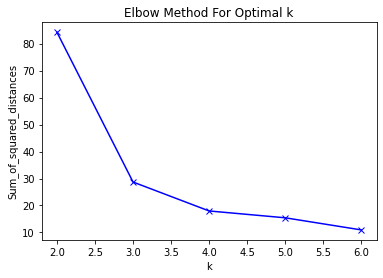

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=42)
y_pred = km.fit_predict(formatted_ts_s1)

39.217 --> 28.972 --> 28.758 --> 28.710 --> 28.698 --> 28.694 --> 28.692 --> 28.692 --> 28.692 --> 28.692 --> 28.692 --> 28.692 --> 


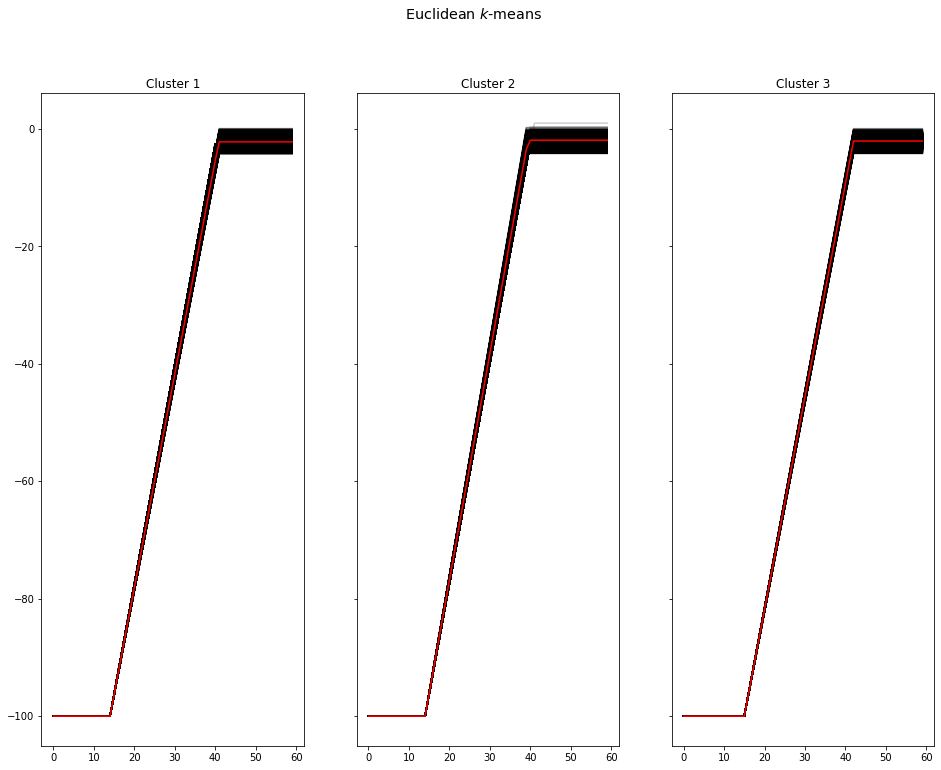

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16,12))
fig.suptitle("Euclidean $k$-means", fontsize='x-large')
for yi in range(3):
    # each axes in the top row gets its own axes title
    ax[yi].set_title('Cluster {}'.format(yi+1))
    for xx in formatted_ts_s1[y_pred == yi]: # pro Cluster die ganzen TS plotten
        ax[yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[yi].plot(km.cluster_centers_[yi].ravel(), "r-") # pro Cluster einmal das Zentrum plotten (red)

In [ ]:
from collections import Counter

In [ ]:
Counter(y_pred)

Counter({2: 3403, 0: 8105, 1: 6049})

In [ ]:
len(y_pred)

17557

#### Soft DTW kmeans

In [ ]:
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=42)
y_pred_sdtw = sdtw_km.fit_predict(formatted_ts_s4)

1133002.799 --> 67993.841 --> 61152.528 --> 60088.424 --> 59819.377 --> 59934.550 --> 59788.318 --> 59862.002 --> 59752.076 --> 59852.191 --> 59724.996 --> 59775.831 --> 59712.065 --> 59740.479 --> 59676.056 --> 59722.293 --> 59646.455 --> 59687.711 --> 59638.956 --> 59670.663 --> 59642.274 --> 59662.324 --> 59642.848 --> 59656.619 --> 59644.195 --> 59653.884 --> 59642.412 --> 59651.032 --> 59644.177 --> 59649.336 --> 59645.061 --> 59648.280 --> 59645.558 --> 59647.605 --> 59645.845 --> 59647.166 --> 59646.020 --> 59646.881 --> 59646.132 --> 59646.694 --> 59646.204 --> 59646.566 --> 59646.247 --> 59646.486 --> 59646.274 --> 59646.433 --> 59646.287 --> 59646.397 --> 59646.300 --> 59646.373 --> 


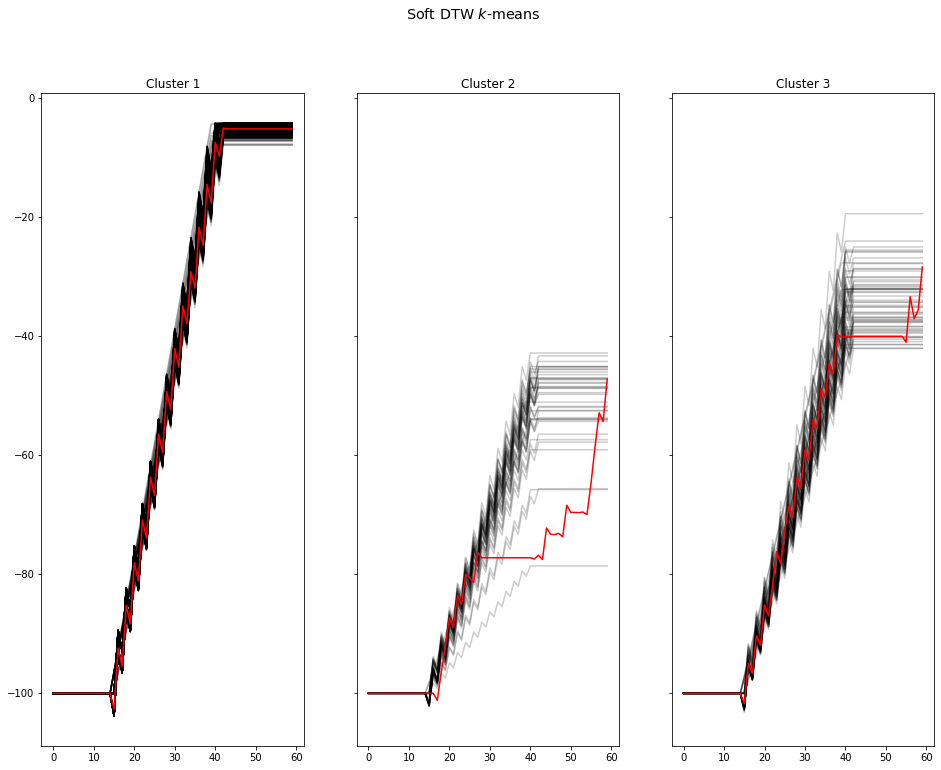

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16,12))
fig.suptitle("Soft DTW $k$-means", fontsize='x-large')
for yi in range(3):
    # each axes in the top row gets its own axes title
    ax[yi].set_title('Cluster {}'.format(yi+1))
    for xx in formatted_ts_s4[y_pred_sdtw == yi]: # pro Cluster die ganzen TS plotten
        ax[yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[yi].plot(sdtw_km.cluster_centers_[yi].ravel(), "r-") # pro Cluster einmal das Zentrum plotten (red)